<a href="https://colab.research.google.com/github/frpbotero/bank_customer_churn_analysis/blob/main/bank_customer_churn_analysis_botero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Instalações e importações

In [ ]:
!pip install pandas
!pip install kaggle --upgrade
!pip install xgboost lightgbm catboost
!pip install feature_engine


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 kB 7.8 MB/s eta 0:00:00


In [ ]:
# ==========================
# 1. Bibliotecas Básicas
# ==========================
import os
import time
import zipfile
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

# ==========================
# 2. Visualização
# ==========================
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# ==========================
# 3. Estatística
# ==========================
import scipy.stats as stats
from scipy.stats import pearsonr, mannwhitneyu, kruskal, chi2_contingency

# ==========================
# 4. Pré-processamento
# ==========================
from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder,
    OneHotEncoder,
    label_binarize
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from feature_engine.outliers import Winsorizer

# ==========================
# 5. Modelos de Machine Learning
# ==========================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# ==========================
# 6. Clusterização
# ==========================
from sklearn.cluster import KMeans, DBSCAN

# ==========================
# 7. Avaliação de Modelos
# ==========================
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

# ==========================
# 8. Validação e Otimização
# ==========================
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score
)

# ==========================
# 9. Pipelines e Redução de Dimensão
# ==========================
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as ImbPipeline

# ==========================
# 10. Balanceamento de Classes
# ==========================
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# ==========================
# 11. Persistência
# ==========================
import joblib

# ==========================
# 12. Recursos Específicos
# ==========================
from google.colab import userdata


In [ ]:
try:
    os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
    os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
    print("Credenciais configuradas via variáveis de ambiente.")
except Exception as e:
    print("Erro: Configure os Secrets do Colab com KAGGLE_USERNAME e KAGGLE_KEY.")

import kaggle

Credenciais configuradas via variáveis de ambiente.


## Introdução

A retenção de clientes é um dos pilares essenciais para a sustentabilidade financeira de qualquer empresa do setor bancário. A perda de clientes — conhecida como churn — representa não apenas redução imediata de receita, mas também custos adicionais para aquisição de novos consumidores e possíveis impactos na reputação da instituição. Compreender os fatores que levam um cliente a encerrar seu relacionamento é, portanto, um passo decisivo para construir estratégias mais eficazes de fidelização.

Este projeto tem como objetivo analisar e interpretar as variáveis associadas ao churn em um banco fictício, identificando padrões, correlações e pesos relativos de cada feature no comportamento de saída dos clientes. A partir desse entendimento, busca-se responder à dor central do negócio: por que clientes deixam o banco e como podemos antecipar esses casos?

O sucesso, dentro deste contexto, está diretamente relacionado à capacidade de prever a probabilidade de churn com precisão e orientar ações práticas que reduzam a perda de clientes. Quanto melhor o modelo entender os fatores críticos de evasão, maior será a possibilidade de intervenção preventiva e, consequentemente, de retenção.

## Sobre o Dataset


O dataset utilizado neste estudo é o repositório público radheshyamkollipara/bank-customer-churn, composto por 10.000 registros e 18 variáveis que descrevem informações demográficas, características de conta, produtos financeiros e o indicador final de churn. Embora fictício, o conjunto de dados apresenta complexidade suficiente para simular um cenário realista de análise de comportamento de clientes no ambiente bancário.

In [ ]:
import kaggle
# Definir o nome do dataset
dataset_name = 'radheshyamkollipara/bank-customer-churn'

# Opcional: Criar um diretório para o dataset
download_path = './kaggle_data'
if not os.path.exists(download_path):
    os.makedirs(download_path)

# Baixar o dataset
print(f"Baixando o dataset {dataset_name}...")
kaggle.api.dataset_download_files(dataset_name, path=download_path, unzip=True)
print(f"Dataset baixado e descompactado em {download_path}/")

# Listar os arquivos baixados (opcional)
print("Arquivos baixados:")
for file_name in os.listdir(download_path):
    print(f"- {file_name}")

# Encontrar o arquivo CSV principal e carregar no pandas
csv_file = None
for file_name in os.listdir(download_path):
    if file_name.endswith('.csv'):
        csv_file = os.path.join(download_path, file_name)
        break

if csv_file:
    print(f"Carregando o arquivo {csv_file} em um DataFrame do pandas...")
    df_model = pd.read_csv(csv_file)
    display(df_model.head())
else:
    print("Nenhum arquivo CSV encontrado no dataset baixado.")

Baixando o dataset radheshyamkollipara/bank-customer-churn...
Dataset URL: https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn
Dataset baixado e descompactado em ./kaggle_data/
Arquivos baixados:
- Customer-Churn-Records.csv
Carregando o arquivo ./kaggle_data/Customer-Churn-Records.csv em um DataFrame do pandas...


RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  Complain  Satisfaction Score Card Type  \
0        101348.88       1         1                   2   DIAMOND   
1        112542.58       0         1                   3   DIAMOND   
2        113931.57       1         1                   3   DIAMOND   
3         93826.63       0         0                   5      GOLD   
4         79084.10       0         0                   5      GOLD   

   Point Earned  
0           464  
1           456  
2           377  
3           350  
4           425

## Informações do Dataset

In [ ]:
print("Analise de Features\n")
print(df_model.info())

print("\nVerificando valores unicos\n")
print(df_model.nunique())

Analise de Features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-nul

## Verificando valores nulos ou faltantes

In [ ]:
print(df_model.isnull().sum())

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64


### Remoção de colunas irrelevantes para o modelo

In [ ]:
cols_to_drop = ['RowNumber', 'CustomerId', 'Surname']
df_model = df_model.drop(cols_to_drop, axis=1)

# Analise Exploratória de Dados (EDA)

## Analise Univariada

### Definição de Variáveis

In [ ]:
var_qualitativas = ["IsActiveMember", "HasCrCard", "Gender", "Exited", "Geography", "Card Type", "Complain"]
var_quantitativas = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary", "Satisfaction Score", "Point Earned"]

In [ ]:
print("Informações do Dataset")
display(Markdown("### Variaveis Qualitativas"))
display(df_model[var_qualitativas].astype('object').describe())

display(Markdown("### Variaveis Quantitativas"))
display(df_model[var_quantitativas].describe())

Informações do Dataset


### Variaveis Qualitativas

IsActiveMember  HasCrCard Gender  Exited Geography Card Type  Complain
count            10000      10000  10000   10000     10000     10000     10000
unique               2          2      2       2         3         4         2
top                  1          1   Male       0    France   DIAMOND         0
freq              5151       7055   5457    7962      5014      2507      7956

### Variaveis Quantitativas

CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288       1.530200   
std       96.653299     10.487806      2.892174   62397.405202       0.581654   
min      350.000000     18.000000      0.000000       0.000000       1.000000   
25%      584.000000     32.000000      3.000000       0.000000       1.000000   
50%      652.000000     37.000000      5.000000   97198.540000       1.000000   
75%      718.000000     44.000000      7.000000  127644.240000       2.000000   
max      850.000000     92.000000     10.000000  250898.090000       4.000000   

       EstimatedSalary  Satisfaction Score  Point Earned  
count     10000.000000        10000.000000  10000.000000  
mean     100090.239881            3.013800    606.515100  
std       57510.492818            1.405919    225.924839  
min          11.580000            1.000000    119.000000  
25%       51002.110000            2.000000    410.000000  
50%      100193.915000            3.000000    605.000000  
75%      149388.247500            4.000000    801.000000  
max      199992.480000            5.000000   1000.000000

#### Váriaveis Qualitativas

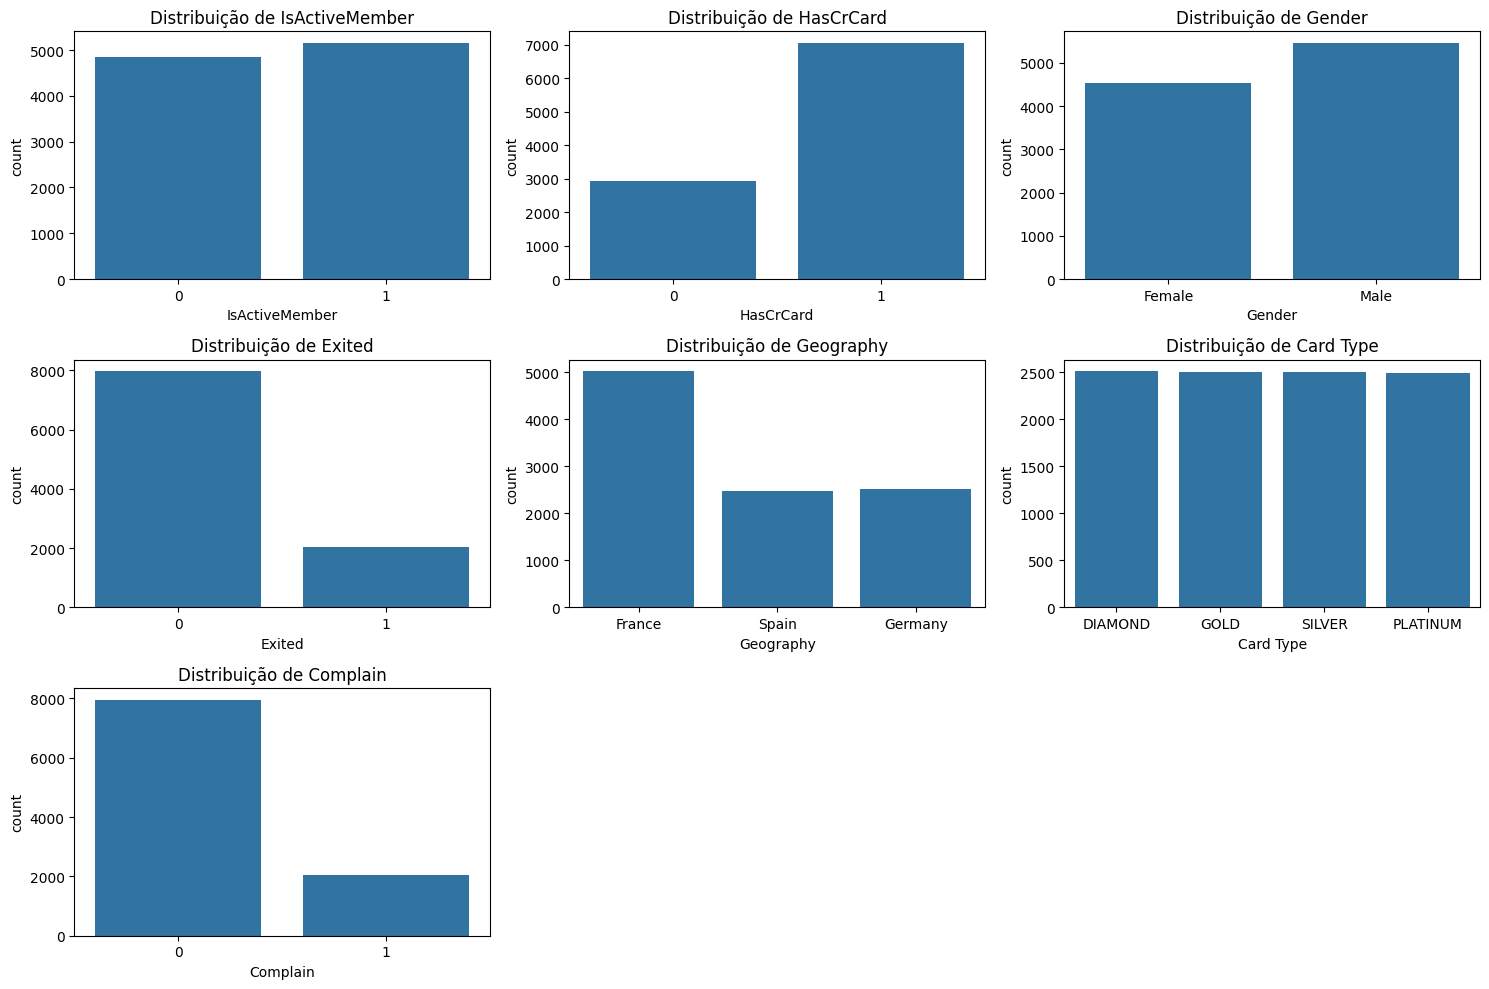

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração do tamanho da figura
plt.figure(figsize=(15, 10))

# Loop para criar um subplot para cada variável
for i, col in enumerate(var_qualitativas):
    plt.subplot(3, 3, i + 1) # Ajuste o grid (3x3) conforme a quantidade de vars
    sns.countplot(data=df_model, x=col)
    plt.title(f'Distribuição de {col}')
    plt.tight_layout()

plt.show()

---

### 📈 Análise das Variáveis Qualitativas

#### 🟦 **Atividade e Engajamento**

* **50% dos clientes permanecem ativos** na base.
* **20% dos clientes saíram** (exit), indicando churn relevante.

#### 💳 **Uso de Produtos**

* **70% dos clientes possuem cartão de crédito.**

#### 👥 **Perfil Demográfico**

* **Mais de 50% dos clientes são homens.**
* **50% dos clientes são da França.**

#### 📞 **Relacionamento**

* **80% dos clientes não fizeram reclamações**, um volume significativamente maior que o dos clientes que registraram algum problema.

#### 📅 **Histórico**

* **Tempo máximo de permanência:** 10 anos.

---

#### ⚠️ **Pontos de Atenção (Resumo Crítico)**

* **A variável alvo é fortemente desbalanceada**, exigindo técnicas específicas para evitar vieses durante o treinamento do modelo.
* **Predomínio de clientes franceses** pode introduzir vieses geográficos, especialmente se o comportamento financeiro for distinto entre franceses, espanhóis e alemães.

---

#### 🧭 **Conclusão (Simplificada)**

A base apresenta **boa adesão a produtos**, **poucas reclamações** e **engajamento razoável**, mas o **churn de 20%** e o **desbalanceamento da variável alvo** devem ser tratados cuidadosamente para garantir modelos preditivos mais consistentes.

---


#### Variaveis Quantitativas

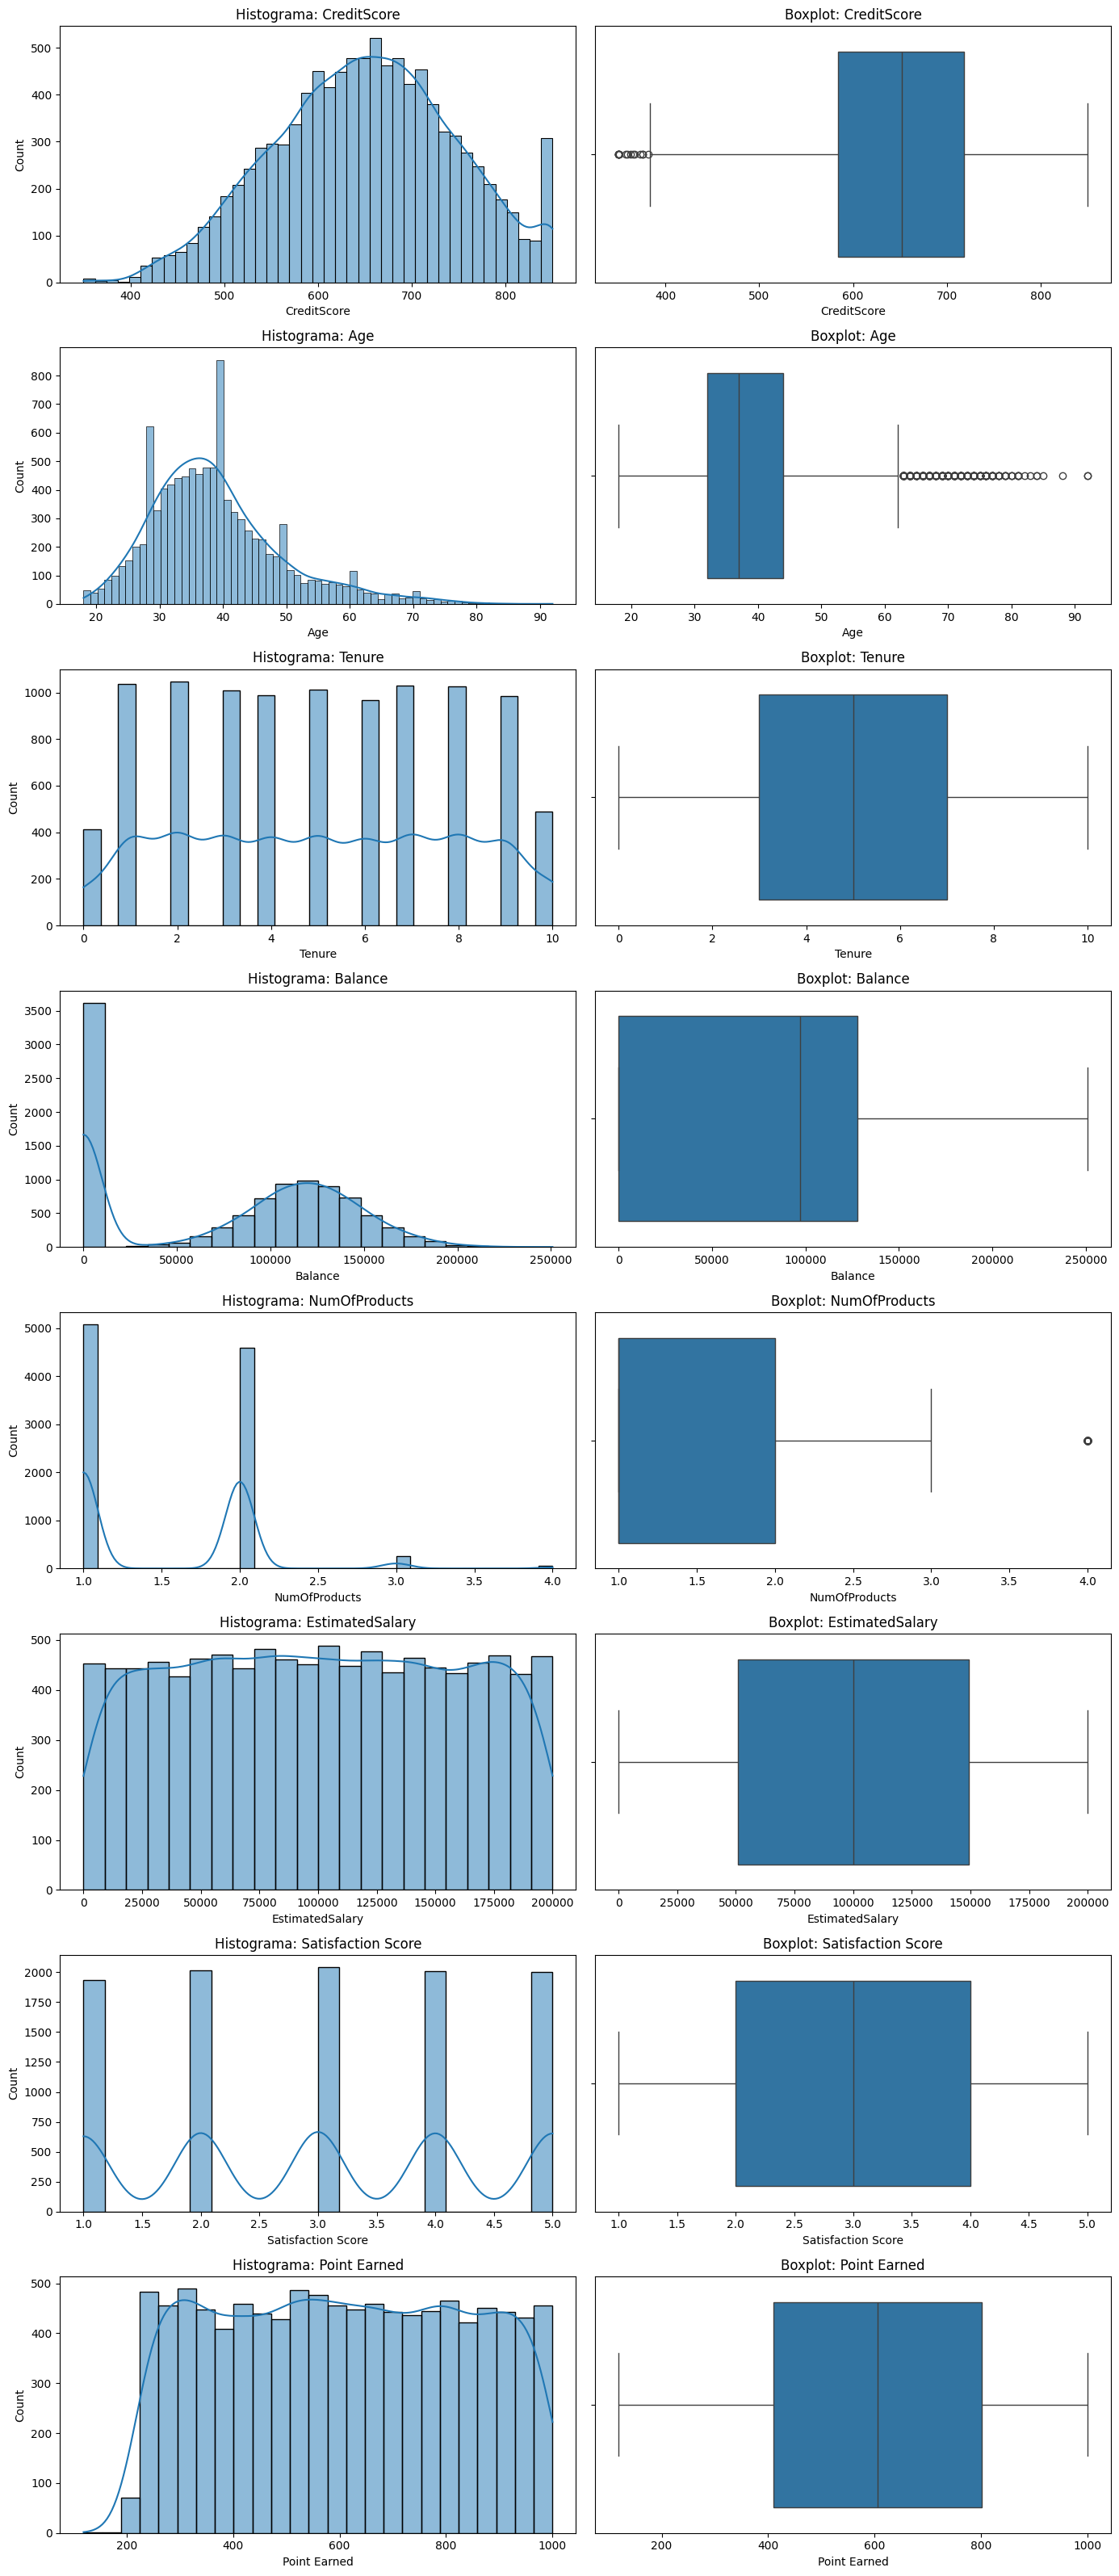

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ajustando o tamanho para caber tudo
fig, axes = plt.subplots(len(var_quantitativas), 2, figsize=(14, len(var_quantitativas) * 4))

for i, col in enumerate(var_quantitativas):
    # Histograma (lado esquerdo)
    sns.histplot(data=df_model, x=col, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histograma: {col}')

    # Boxplot (lado direito)
    sns.boxplot(data=df_model, x=col, ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot: {col}')

plt.tight_layout()
plt.show()

---

### 📈 **Análise das Variáveis Quantitativas**

#### ⭐ **Credit Score**

* A distribuição é **levemente deslocada para a esquerda**, indicando que a pontuação de crédito tende a ser **um pouco mais alta**.
* Isso sugere que a base é composta majoritariamente por **clientes com bom perfil de crédito**.

---

#### 👤 **Idade**

* A idade apresenta distribuição **suavemente inclinada à esquerda**, mostrando **maior concentração de clientes jovens**.
* A faixa predominante está entre **32 e 45 anos**.
* Existem **alguns outliers acima de 64 anos**, mas representam minoria.

---

#### 🕒 **Tempo de Relacionamento**

* **Menos de 400 clientes têm menos de 1 ano de relacionamento**.
* O tempo máximo é de **10 anos**, mas representa apenas cerca de **500 clientes**.
* A maior concentração está no intervalo de **3 a 7 anos**, exibindo **distribuição bastante uniforme** nessa faixa.

---

#### 🏦 **Balanço (Saldo em Conta)**

* **Mais de 45% dos clientes não possuem saldo**, o que pode indicar:

  * Contas recém-criadas sem movimentação, ou
  * Clientes que não utilizam o banco como instituição financeira principal.

---

#### 📦 **Número de Produtos**

* **Mais de 50% dos clientes possuem pelo menos 1 produto**.
* **Cerca de 40% possuem 2 produtos**.
* Aproximadamente **200 clientes possuem 3 produtos** do banco.

---

#### 💼 **Estimativa Salarial**

* A distribuição de salário é **uniforme**, com maior concentração no intervalo de **50.000 a 150.000**.

---

#### ⭐ **Nota de Satisfação**

* A distribuição das notas é equilibrada, com **maior frequência de avaliações acima de 2 pontos** — sinalizando tendência à satisfação moderada ou elevada.

---


## Analise Bivariada

#### Váriaveis Quantitativa

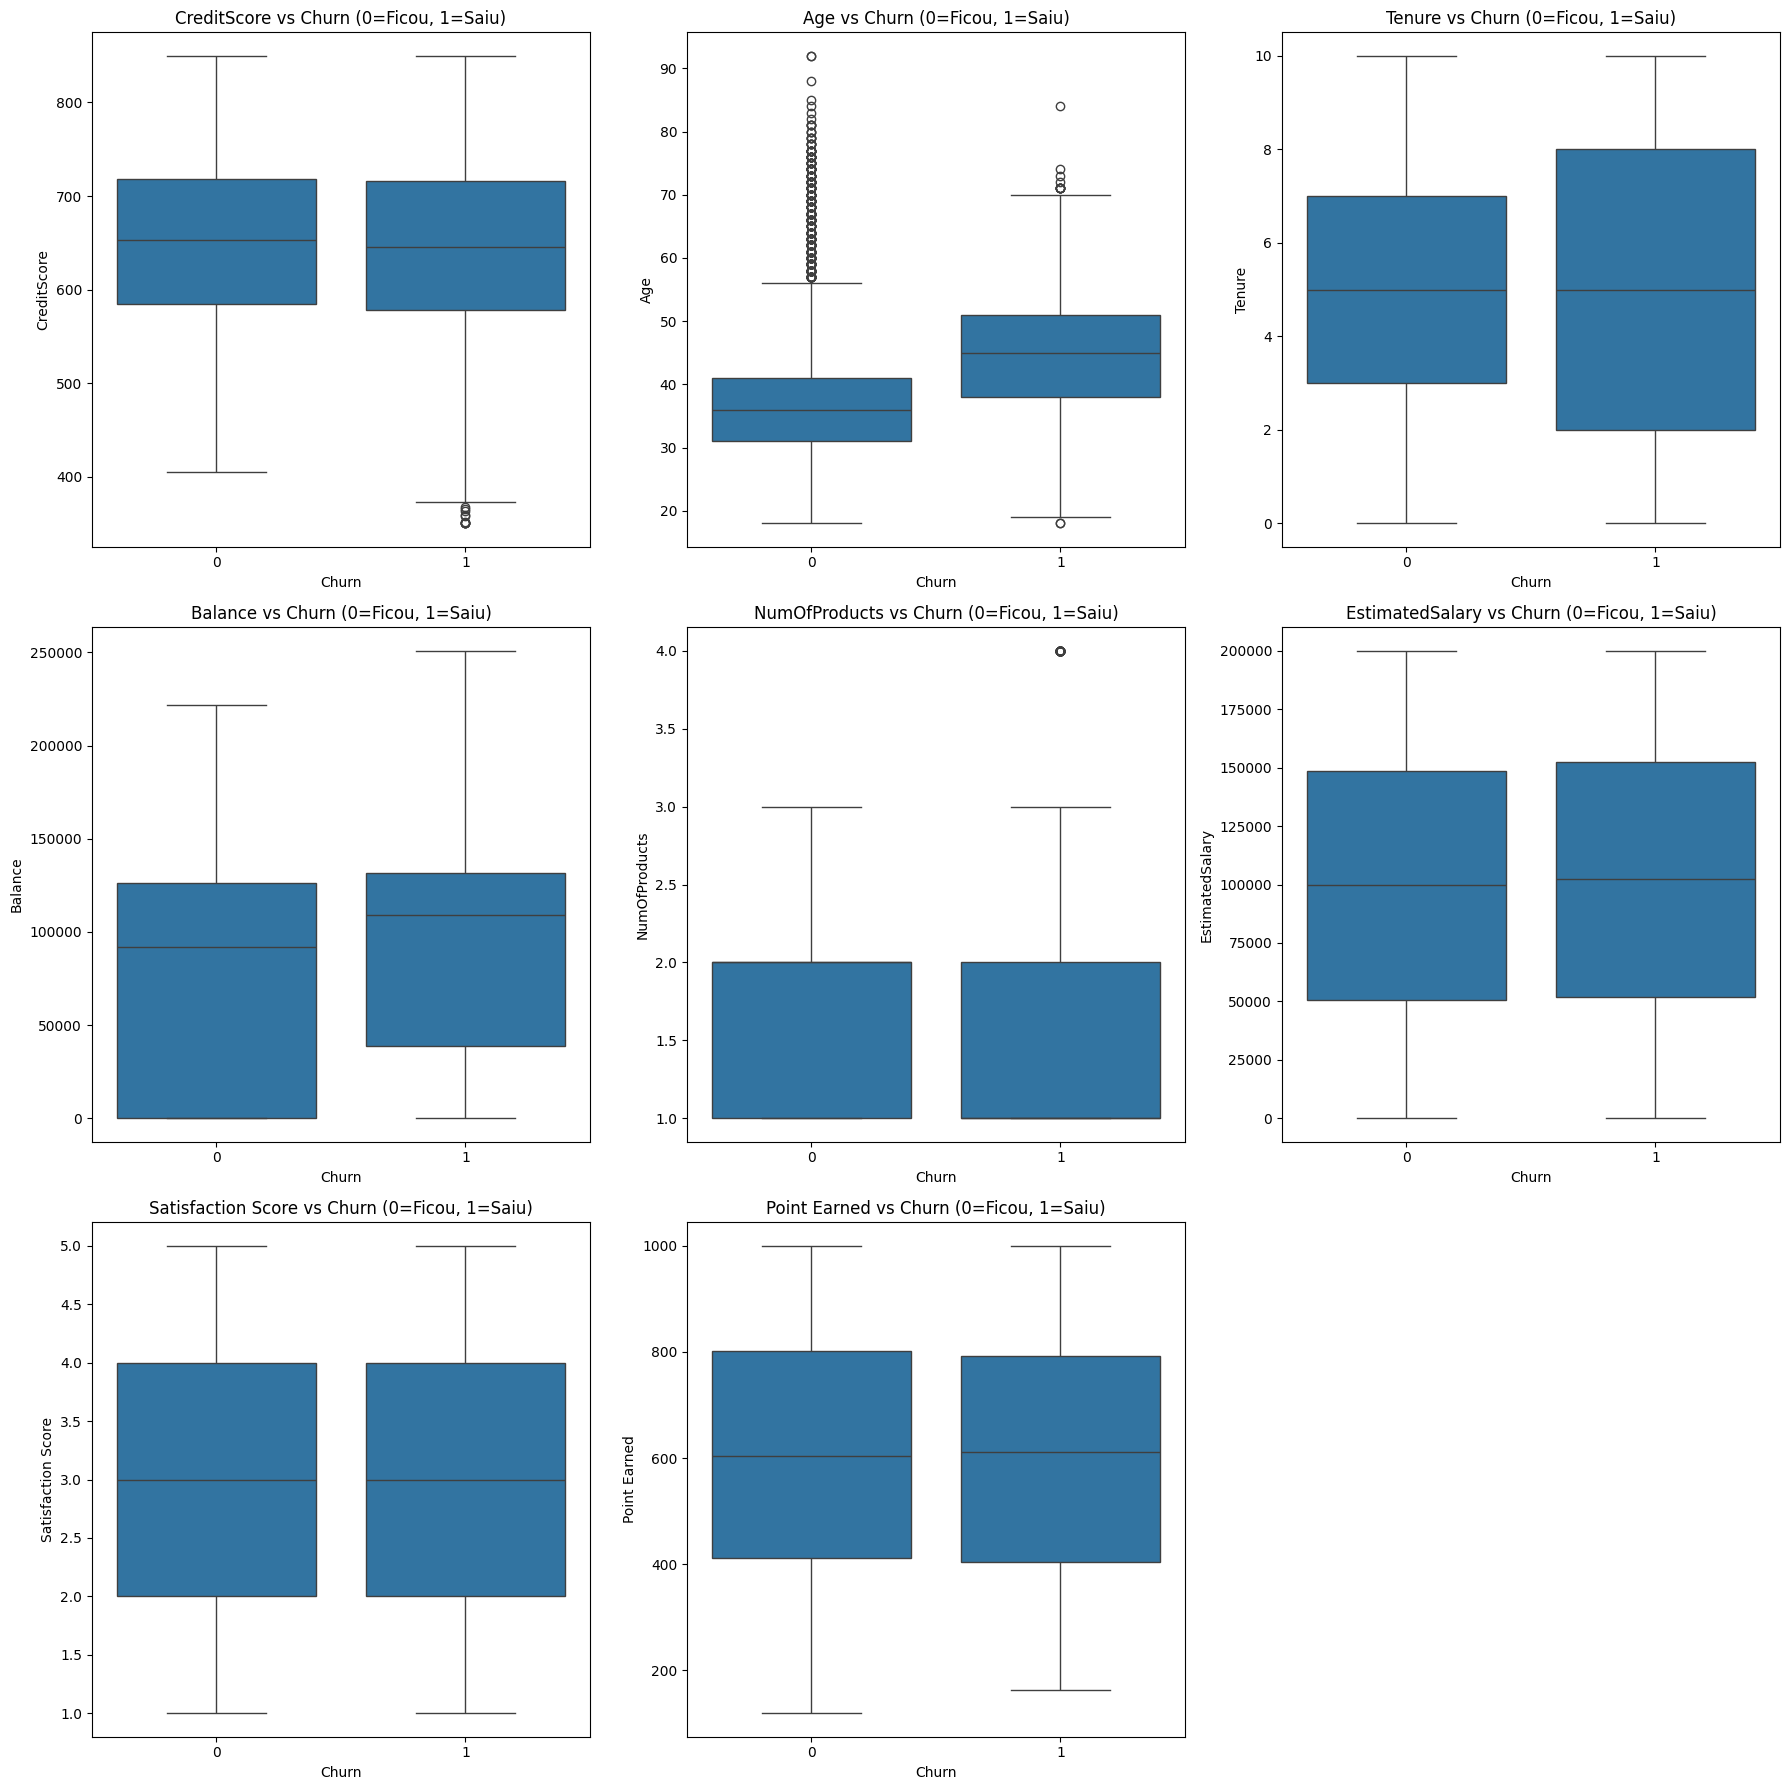

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Número de variáveis quantitativas
n = len(var_quantitativas)

# Define uma grade de subplots (3 colunas e linhas automáticas)
cols = 3
rows = (n + cols - 1) // cols  # cálculo para número ideal de linhas

fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
axes = axes.flatten()  # facilita indexação linear

# Gera um boxplot por variável
for i, col in enumerate(var_quantitativas):
    sns.boxplot(data=df_model, x='Exited', y=col, ax=axes[i])
    axes[i].set_title(f'{col} vs Churn (0=Ficou, 1=Saiu)', fontsize=12)
    axes[i].set_xlabel("Churn")
    axes[i].set_ylabel(col)

# Remove subplots vazios (caso sobrem)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
df_model.groupby('Exited')['NumOfProducts'].value_counts(normalize=True)

Exited  NumOfProducts
0       2                0.532655
        1                0.461567
        3                0.005777
1       1                0.691364
        2                0.171246
        3                0.107949
        4                0.029441
Name: proportion, dtype: float64

---

#### 📈 Análise das Variáveis Quantitativas

##### ⭐ **1. Idade é um fator crítico para churn**

* Clientes que saem são **claramente mais velhos**.
* A mediana geral fica em torno de **45 anos**, mas o grupo churn tem idades ainda mais elevadas.
  **Conclusão:** idade é um dos preditores mais fortes de churn.

---

#### ⭐ **2. Número de produtos diferencia fortemente quem sai de quem fica**

Mesmo que o boxplot não evidencie, a proporção deixa claro:

##### 🔹 Quem tem **1 produto**:

* **69% do churn** pertence a esse grupo.
* Apenas **46% dos clientes que ficam** têm 1 produto.
  ➡️ **Grande indicador de risco.**

##### 🔹 Quem tem **2 produtos**:

* **53% dos clientes que ficam** têm 2 produtos.
* Apenas **17% dos clientes que saem** têm 2 produtos.
  ➡️ **Indica retenção.**

##### 🔹 Quem tem 3 ou 4 produtos:

* Casos raros, mas aparecem mais no churn do que entre os que ficaram.
  ➡️ Pode sinalizar perfis específicos ou necessidades não atendidas.

---

#### ⭐ **3. Clientes com contas sem saldo são predominantes**

* Mais de **45% não possuem saldo**.
  ➡️ Pode indicar baixa movimentação, uso secundário da conta ou simples inatividade.
  ➡️ Sinal de **risco potencial**, pois falta engajamento.

---

#### ⭐ **4. Renda e saldo NÃO são bons discriminadores de churn**

* As distribuições de **EstimatedSalary** e **Balance** são quase idênticas entre churn e não-churn.
  ➡️ Pouco poder preditivo.

---

#### ⭐ **5. Pontuação de satisfação e pontos acumulados também não diferenciam**

* **SatisfactionScore** e **Point Earned** mostram distribuições muito próximas entre os grupos.
  ➡️ Não ajudam a separar quem sai de quem fica.

---

#### ⭐ **6. Tempo de relacionamento só importa no início**

* Clientes com **menos de 1 ano** têm maior chance de churn.
* Depois disso, a distribuição é praticamente igual para os dois grupos.
  ➡️ Baixa fidelização inicial = maior risco.

---

### 🎯 **Resumo Executivo**

Os fatores mais relevantes para churn são:

✔ **Idade elevada**
✔ **Ter apenas 1 produto**
✔ **Conta sem saldo / baixa movimentação**
✔ **Cliente recente (menos de 1 ano)**

Variáveis com baixo impacto:

✘ Renda
✘ Saldo
✘ Satisfação
✘ Pontos
✘ Tenure (exceto muito baixo)

---



#### Váriaveis Qualitativas

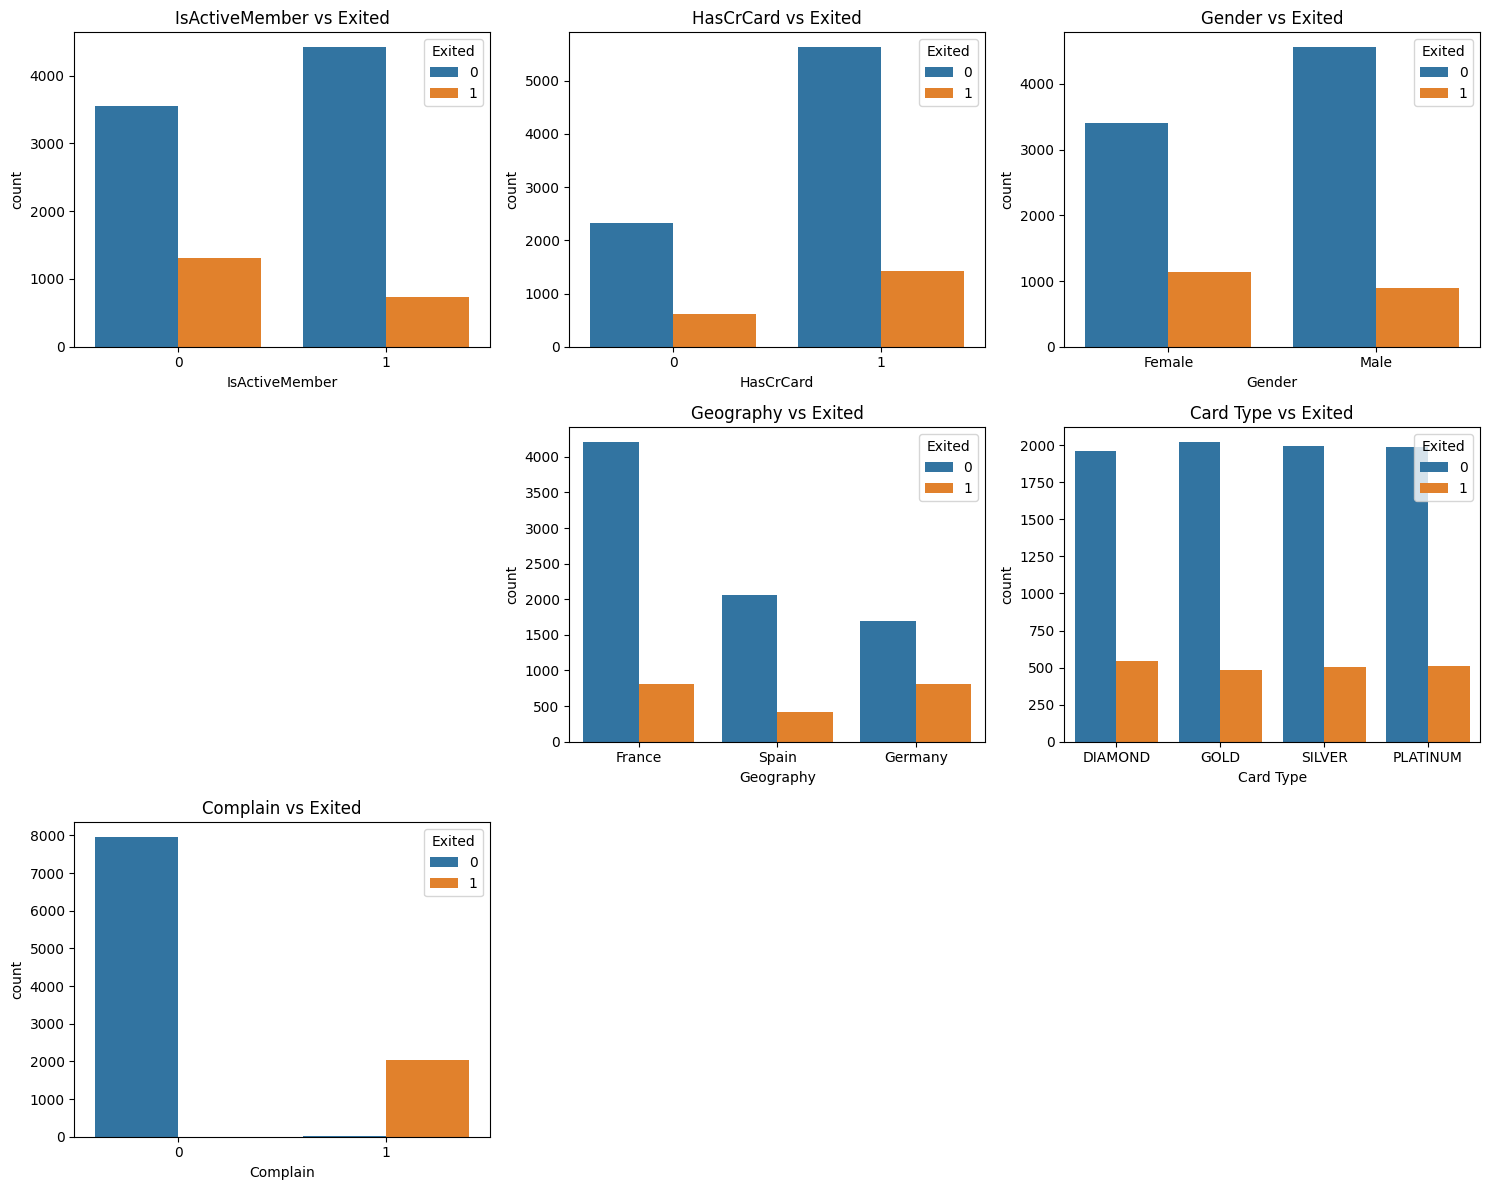

In [ ]:
# Configuração do tamanho da figura
plt.figure(figsize=(15, 12))

# Loop para criar os gráficos com a separação por Churn
for i, col in enumerate(var_qualitativas):
    # Pular a própria variável Exited para não ficar redundante
    if col == 'Exited':
        continue

    plt.subplot(3, 3, i + 1)
    # Aqui adicionamos o hue='Exited'
    sns.countplot(data=df_model, x=col, hue='Exited')
    plt.title(f'{col} vs Exited')
    plt.tight_layout()

plt.show()

In [ ]:
df_model.groupby('Exited')['Complain'].value_counts()


Exited  Complain
0       0           7952
        1             10
1       1           2034
        0              4
Name: count, dtype: int64

---

#### 📊 Análise das Variáveis Categóricas

---

#### ⭐ **1. Clientes inativos têm maior propensão ao churn**

* Clientes com **IsActiveMember = 0** apresentam uma taxa de churn significativamente maior.
  ➡️ **Inatividade é um forte indicador de risco.**

---

#### ⭐ **2. Possuir cartão de crédito aumenta a chance de saída**

* No grupo que possui **HasCrCard = 1**, observa-se maior proporção de churn comparado aos que não têm cartão.
  ➡️ Pode indicar baixa utilização do produto, oferta inadequada ou benefício pouco relevante.

---

#### ⭐ **3. Mulheres apresentam maior taxa proporcional de churn**

* Embora ambos os gêneros estejam presentes de forma equilibrada, **o churn é proporcionalmente maior entre mulheres**.
  ➡️ Pode sugerir que o banco possua comunicação, serviço ou produtos mais alinhados ao público masculino.

---

#### ⭐ **4. A Alemanha concentra a maior taxa de churn**

* Entre os três países, a **Alemanha apresenta o maior volume proporcional de clientes que saíram**, seguida da França, e a Espanha é a mais estável.
  ➡️ Indica possível diferença regional de experiência, concorrência ou adequação dos produtos.

---

#### ⭐ **5. Tipo de cartão não influencia o churn**

* As categorias **Diamond, Gold, Silver e Platinum** apresentam proporções muito semelhantes de saída.
  ➡️ Portanto, **CardType não é um preditor relevante**.

---

#### ⭐ **6. Reclamações são extremamente associadas ao churn, mas não devem ser usadas no modelo**

* Quase **todos os clientes que reclamaram acabaram saindo**, enquanto praticamente ninguém que ficou registrou reclamação.
* Isso transforma `Complain` em uma variável quase determinística do churn.

##### ❗ Porém, essa variável **não deve ser utilizada** no modelo preditivo:

* **Carrega informação do futuro** — a reclamação ocorre **antes** do churn, mas pode estar muito próxima temporalmente.
* O modelo aprenderia a prever churn apenas porque ocorreu uma reclamação, gerando **data leakage**.
* Isso faria com que o modelo **ignorasse totalmente os sinais que antecedem a insatisfação**.
* O resultado seria um modelo “perfeito”, porém **inútil para prevenção**, pois só detectaria churn após o problema já ter acontecido.

➡️ **Conclusão:** usar `Complain` comprometeria a robustez e a utilidade do modelo.

---

### 🎯 **Resumo Executivo das Variáveis Categóricas**

Os fatores mais relevantes para churn são:

✔ **Inatividade (IsActiveMember = 0)**
✔ **Possuir cartão de crédito**
✔ **Ser mulher**
✔ **Residência na Alemanha**

Fatores com baixo impacto:

✘ **Tipo de cartão**
✘ **Distribuição igualitária em algumas categorias**
✘ **Complain (embora extremamente forte, não pode ser usada)**

---

## Correlações

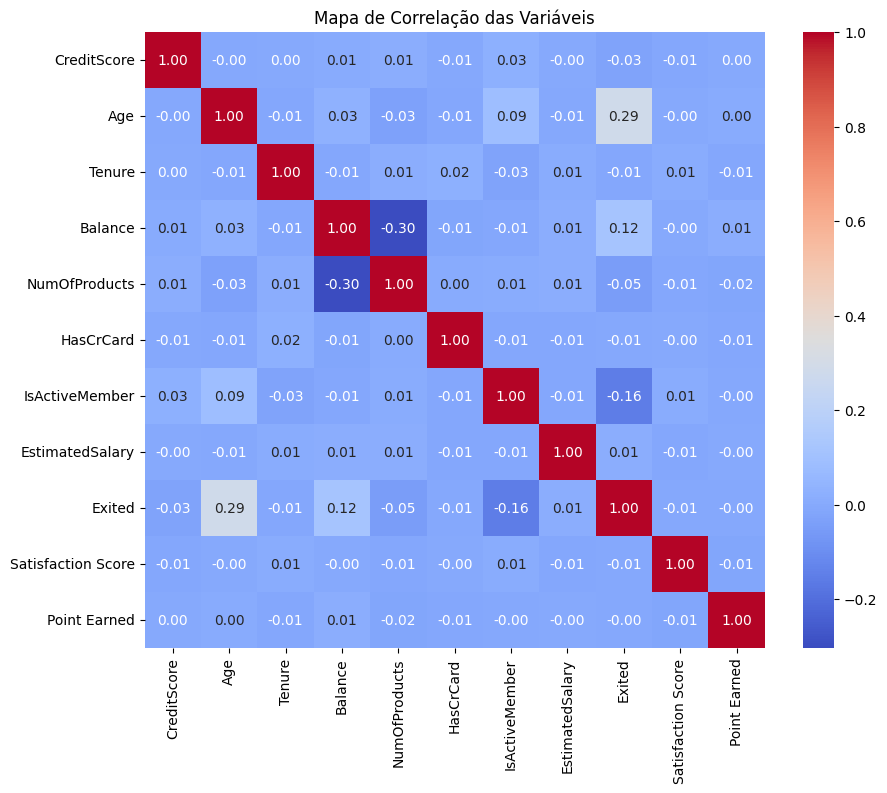

In [ ]:
# 1. Removendo a variável com Data Leakage
if 'Complain' in df_model.columns:
    df_model = df_model.drop('Complain', axis=1)

# 2. Gerando a Matriz de Correlação
plt.figure(figsize=(10, 8))
# Selecionando apenas colunas numéricas para a correlação
corr_matrix = df_model.corr(numeric_only=True)

# Plotando o Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Correlação das Variáveis')
plt.show()

Aqui está um **Markdown no mesmo padrão dos anteriores**, bem organizado, claro e com apenas os **insights realmente significativos do mapa de correlação**, mantendo o estilo profissional e direto.

---

#### 🔗 **Análise do Mapa de Correlação**

---

#### ⭐ **1. Idade tem a correlação mais alta com churn**

* A variável **Age** apresenta correlação **positiva moderada (≈ 0.29)** com `Exited`.
* Clientes mais velhos têm maior probabilidade de sair do banco.
  ➡️ **Idade é um dos preditores mais fortes entre as variáveis disponíveis.**

---

#### ⭐ **2. Clientes ativos têm menor probabilidade de churn**

* A variável **IsActiveMember** apresenta correlação **negativa (-0.16)** com `Exited`.
* Quanto mais ativo o cliente, menor a chance de abandonar o banco.
  ➡️ Ser ativo é um **importante fator de retenção**.

---

#### ⭐ **3. Saldo (Balance) possui correlação levemente positiva com churn**

* `Balance` apresenta correlação **positiva fraca (≈ 0.12)** com `Exited`.
* Clientes com saldos mais altos têm tendência levemente maior a sair, possivelmente:

  * buscando melhores oportunidades financeiras,
  * migrando para bancos com taxas menores,
  * ou utilizando a conta apenas como passagem.
    ➡️ Embora fraca, essa correlação sugere **comportamentos financeiros mais estratégicos** entre clientes com saldo maior.

---

#### ⭐ **4. Número de produtos tem leve correlação negativa com saldo**

* Há uma correlação de **-0.30 entre Balance e NumOfProducts**, indicando que:

  * quem tem mais produtos tende a manter saldos menores,
  * enquanto quem tem poucos produtos tende a manter saldos maiores.
    ➡️ Pode indicar diferentes perfis de uso: clientes “multisserviço” versus clientes “investidores”.

---

#### ⭐ **5. Outras variáveis apresentam correlações muito baixas**

* `CreditScore`, `Tenure`, `HasCrCard`, `EstimatedSalary`, `SatisfactionScore` e `Point Earned` têm correlações próximas de **zero**.
  ➡️ Isoladamente, **não explicam bem o churn**.

---

### 🎯 **Resumo Executivo do Mapa de Correlação**

Os fatores mais correlacionados com churn:

✔ **Idade (correlação positiva moderada)**
✔ **Ser inativo (correlação negativa relevante)**
✔ **Saldo (correlação positiva fraca, mas significativa)**

Variáveis com baixa relevância individual:

✘ **CreditScore**
✘ **Tenure**
✘ **EstimatedSalary**
✘ **HasCrCard**
✘ **SatisfactionScore**
✘ **Point Earned**

---

Se quiser, posso agora **integrar todos os insights quantitativos + categóricos + correlação** em um único relatório final para o notebook.


## Analise Estatistica

In [ ]:
from scipy import stats
import pandas as pd

def realizar_testes_estatisticos(df, target='Exited'):
    print(f"--- Análise Estatística de Impacto no Churn ({target}) ---")

    # 1. Teste para Variáveis Categóricas (Qui-Quadrado)
    # H0 (Hipótese Nula): Não existe relação entre a variável e o Churn.
    # H1 (Hipótese Alternativa): Existe uma relação significativa.
    cat_vars = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

    print("\n[Variáveis Categóricas - Teste Qui-Quadrado]")
    for col in cat_vars:
        if col in df.columns:
            # Cria tabela de contingência (cruzamento)
            contingency_table = pd.crosstab(df[col], df[target])
            # Calcula o Qui-Quadrado
            chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

            sig = "SIGNIFICANTE ✅" if p_value < 0.05 else "Não Significante ❌"
            print(f"- {col:<15} | p-value: {p_value:.4e} | {sig}")

    # 2. Teste para Variáveis Numéricas (Mann-Whitney)
    # Usamos Mann-Whitney porque a distribuição de idade/saldo não é perfeitamente normal
    # H0: A distribuição da variável é a mesma para quem sai e quem fica.
    num_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

    print("\n[Variáveis Numéricas - Teste Mann-Whitney U]")
    # Separamos os grupos
    group_churn = df[df[target] == 1]
    group_not_churn = df[df[target] == 0]

    for col in num_vars:
        if col in df.columns:
            stat, p_value = stats.mannwhitneyu(group_churn[col], group_not_churn[col])

            sig = "SIGNIFICANTE ✅" if p_value < 0.05 else "Não Significante ❌"
            print(f"- {col:<15} | p-value: {p_value:.4e} | {sig}")

# Chamando a função (use o seu dataframe ANTES do get_dummies)
realizar_testes_estatisticos(df_model)

--- Análise Estatística de Impacto no Churn (Exited) ---

[Variáveis Categóricas - Teste Qui-Quadrado]
- Geography       | p-value: 5.2457e-66 | SIGNIFICANTE ✅
- Gender          | p-value: 2.9254e-26 | SIGNIFICANTE ✅
- HasCrCard       | p-value: 5.0262e-01 | Não Significante ❌
- IsActiveMember  | p-value: 6.1532e-55 | SIGNIFICANTE ✅

[Variáveis Numéricas - Teste Mann-Whitney U]
- CreditScore     | p-value: 2.1751e-02 | SIGNIFICANTE ✅
- Age             | p-value: 2.7803e-230 | SIGNIFICANTE ✅
- Tenure          | p-value: 1.7296e-01 | Não Significante ❌
- Balance         | p-value: 1.1688e-28 | SIGNIFICANTE ✅
- NumOfProducts   | p-value: 7.2794e-36 | SIGNIFICANTE ✅
- EstimatedSalary | p-value: 2.1236e-01 | Não Significante ❌


# Pré-processamento de Dados

In [ ]:
from feature_engine.outliers import Winsorizer
import numpy as np

# --- ETAPA 1: Tratamento de Outliers (Winsorization) ---
# Definimos quais colunas queremos limpar os extremos
cols_para_limpar = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Point Earned']

# Instanciamos o Winsorizer usando IQR (Interquartile Range)
# fold=1.5 é o padrão estatístico para definir o que é outlier
winsor = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=cols_para_limpar)

# Aplicamos no dataframe
df_model = winsor.fit_transform(df_model)


# --- ETAPA 2: Transformação Logarítmica (O "Pulo do Gato") ---
# Como vimos na análise do outro notebook, isso ajuda a "normalizar" distribuições tortas
# Usamos log1p (log de x+1) para evitar erro matemático se o valor for 0
df_model['Age'] = np.log1p(df_model['Age'])
df_model['Balance'] = np.log1p(df_model['Balance'])


In [ ]:
# A França será nosso caso base, como temos a maior concentração de clientes.
df_model = pd.get_dummies(df_model, prefix=None, prefix_sep='_', columns=["Geography", "Gender","Card Type"], drop_first=True, dtype=int)


Feature Scaling

In [ ]:
cols_to_scale=["CreditScore","Balance","EstimatedSalary","Satisfaction Score","Point Earned","NumOfProducts","Tenure","Age"]

scaler = StandardScaler()
df_model[cols_to_scale] = scaler.fit_transform(df_model[cols_to_scale])
df_model.head()

CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
0    -0.326878  0.454290 -1.041760 -1.327358      -0.911583          1   
1    -0.440804  0.357397 -1.387538  0.694771      -0.911583          0   
2    -1.538636  0.454290  1.032908  0.809738       2.527057          1   
3     0.501675  0.156491 -1.387538 -1.327358       0.807737          0   
4     2.065569  0.548956 -1.041760  0.766810      -0.911583          1   

   IsActiveMember  EstimatedSalary  Exited  Satisfaction Score  Point Earned  \
0               1         0.021886       1           -0.721130     -0.630839   
1               1         0.216534       0           -0.009816     -0.666251   
2               0         0.240687       1           -0.009816     -1.015942   
3               0        -0.108918       0            1.412812     -1.135457   
4               1        -0.365276       0            1.412812     -0.803472   

   Geography_Germany  Geography_Spain  Gender_Male  Card Type_GOLD  \
0                  0                0            0               0   
1                  0                1            0               0   
2                  0                0            0               0   
3                  0                0            0               1   
4                  0                1            0               1   

   Card Type_PLATINUM  Card Type_SILVER  
0                   0                 0  
1                   0                 0  
2                   0                 0  
3                   0                 0  
4                   0                 0

## Separação de Dataset

In [ ]:
from sklearn.model_selection import train_test_split

X = df_model.drop('Exited', axis=1)
y = df_model['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y,
 test_size=0.3,
 random_state=0,
 stratify=y)
# Uso do Stratify garante que o seu treino e o seu teste mantenham exatamente essa mesma proporção. Sem isso, você poderia ter o azar de o teste ficar só com clientes que "Ficaram", o que mascararia a performance real do modelo

## Modelagem

#### Configuracao de MOdelos

In [ ]:
models_default = {
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "NeuralNetwork": MLPClassifier(),
    "XGBoost": XGBClassifier(),
    "AdaBoost": AdaBoostClassifier(),
}

#### Configuracao de paramentros

In [ ]:
param_grids = {
    "LogisticRegression": {
        'C': [0.1, 1.0, 10.0],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [500, 1000]
    },
    "RandomForest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    "DecisionTree": {
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "NeuralNetwork": {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001]
    },
     "AdaBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    "XGBoost": {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0]
    }

}


resultados = []

In [ ]:
def garantir_duas_colunas(scores):
    scores = np.array(scores)

    # Caso já tenha 2 colunas
    if scores.ndim == 2 and scores.shape[1] == 2:
        return scores

    # Caso seja 1D — binário
    if scores.ndim == 1:
        # Normalizar para [0,1]
        min_v = scores.min()
        max_v = scores.max()
        if max_v - min_v == 0:
            score_pos = np.zeros_like(scores)
        else:
            score_pos = (scores - min_v) / (max_v - min_v)

        score_neg = 1 - score_pos
        return np.vstack([score_neg, score_pos]).T

    # Caso seja 2D porém só com 1 coluna
    if scores.ndim == 2 and scores.shape[1] == 1:
        col = scores[:, 0]
        min_v = col.min()
        max_v = col.max()
        if max_v - min_v == 0:
            score_pos = np.zeros_like(col)
        else:
            score_pos = (col - min_v) / (max_v - min_v)

        score_neg = 1 - score_pos
        return np.vstack([score_neg, score_pos]).T


#### Classe ModelTrainer

In [ ]:
import os
import time
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score, make_scorer
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

class ModelTrainer:
    def __init__(self, X_train, y_train, X_test, y_test, models, param_grids=None, best_params=None):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.models = models
        self.param_grids = param_grids if param_grids else {}
        self.best_params = best_params if best_params else {}
        self.results = []
        self.best_model_info = {
            "pipeline": None,
            "name": "",
            "score": 0.0,
            "metric": ""
        }

    def _get_metric_score(self, y_true, y_pred, metric_name):
        """Calcula a pontuação baseada na métrica escolhida."""
        if metric_name == 'accuracy':
            return accuracy_score(y_true, y_pred)
        elif metric_name == 'recall':
            return recall_score(y_true, y_pred, average='macro')

        # --- ALTERAÇÃO 1: Adicionado suporte para Recall da Classe 1 ---
        elif metric_name == 'recall_1':
            return recall_score(y_true, y_pred, pos_label=1, average='binary')
        # -------------------------------------------------------------

        elif metric_name == 'precision':
            return precision_score(y_true, y_pred, average='macro')
        elif metric_name == 'f1':
            return f1_score(y_true, y_pred, average='macro')
        else:
            raise ValueError(f"Métrica '{metric_name}' não suportada.")

    def _preprocess_data(self, balanceamento, usar_pca):
        X_train_proc, y_train_proc = self.X_train, self.y_train
        X_test_proc = self.X_test

        if balanceamento == "SMOTE":
            sm = SMOTE(random_state=42)
            X_train_proc, y_train_proc = sm.fit_resample(X_train_proc, y_train_proc)
        elif balanceamento == "TomekLinks":
            tml = TomekLinks()
            X_train_proc, y_train_proc = tml.fit_resample(X_train_proc, y_train_proc)

        if usar_pca:
            pca = PCA(n_components=0.95)
            X_train_proc = pca.fit_transform(X_train_proc)
            X_test_proc = pca.transform(X_test_proc)

        return X_train_proc, y_train_proc, X_test_proc

    def train(self, metric_optimize='recall_1', balanceamento=None, usar_pca=False, tipo_parametros='default', salvar_parametros=True, path_salvar='/content/dados'):
        """
        Args:
            metric_optimize (str): Use 'recall_1' para focar na classe positiva.
        """
        if not os.path.exists(path_salvar):
            os.makedirs(path_salvar)
            print(f"📂 Diretório criado: {path_salvar}")

        self.results = []
        self.best_model_info = {"pipeline": None, "name": "", "score": 0.0, "metric": metric_optimize}

        X_train_ready, y_train_ready, X_test_ready = self._preprocess_data(balanceamento, usar_pca)

        print(f"Iniciando treinamento otimizando por: {metric_optimize.upper()}\n")

        for name, model in self.models.items():
            descricao_cenario = (
                f"{name} | Balanc: {balanceamento if balanceamento else 'None'} "
                f"| PCA: {'Sim' if usar_pca else 'Não'} | Params: {tipo_parametros}"
            )
            print(f"\n{'='*20} {name} {'='*20}")

            if tipo_parametros == "default" or name == "NaiveBayes":
                estimator = model
            else:
                params = self.param_grids.get(name) if tipo_parametros == "grid" else self.best_params.get(name)

                # --- ALTERAÇÃO 2: Mapeamento do GridSearch ---
                scoring_map = {
                    'accuracy': 'accuracy',
                    'recall': 'recall_macro',     # Media geral
                    'recall_1': 'recall',         # Foca na classe 1 (Binary)
                    'precision': 'precision_macro',
                    'f1': 'f1_macro'
                }
                # ---------------------------------------------

                if params:
                    estimator = GridSearchCV(
                        estimator=model,
                        param_grid=params,
                        cv=5,
                        n_jobs=-1,
                        scoring=scoring_map.get(metric_optimize, 'accuracy'),
                        verbose=1
                    )
                else:
                    print(f"⚠️ Aviso: Sem parâmetros definidos para {name}. Usando default.")
                    estimator = model

            inicio = time.time()
            estimator.fit(X_train_ready, y_train_ready)
            fim = time.time()
            tempo_treino = fim - inicio

            y_pred = estimator.predict(X_test_ready)

            # Usa a métrica escolhida (ex: recall da classe 1) para decidir o melhor
            score_atual = self._get_metric_score(self.y_test, y_pred, metric_optimize)

            # Métricas informativas
            acc = accuracy_score(self.y_test, y_pred)
            # Calcula o recall da classe 1 explicitamente para o log
            rec_class_1 = recall_score(self.y_test, y_pred, pos_label=1, average='binary')

            if score_atual > self.best_model_info["score"]:
                print(f"✨ Novo Recorde! {name} com {metric_optimize}: {score_atual:.4f}")
                self.best_model_info["score"] = score_atual
                self.best_model_info["pipeline"] = estimator
                self.best_model_info["name"] = name

            classes = unique_labels(self.y_test, y_pred)
            target_names = [f"Classe {c}" for c in classes]

            cm = confusion_matrix(self.y_test, y_pred, labels=classes)
            plt.figure(figsize=(6, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=target_names, yticklabels=target_names)
            plt.xlabel('Predição')
            plt.ylabel('Real')
            plt.title(f'Matriz de Confusão - {name}')
            plt.show()

            print(f"\nRelatório para {descricao_cenario}:")
            print(classification_report(self.y_test, y_pred, target_names=target_names))
            print(f"Tempo: {tempo_treino:.4f}s")

            best_params_found = estimator.best_params_ if hasattr(estimator, 'best_params_') else "N/A"

            self.results.append({
                "Modelo": name,
                "Configuração": descricao_cenario,
                f"Score Otimização ({metric_optimize})": score_atual,
                "Recall (Classe 1)": rec_class_1,
                "Acurácia": acc,
                "Tempo (s)": tempo_treino,
                "Melhores Parâmetros": best_params_found
            })

            if salvar_parametros and hasattr(estimator, 'best_params_'):
                 try:
                    joblib.dump(estimator.best_params_, f'{path_salvar}/parametros_{name}.pkl')
                 except Exception as e:
                    print(f"Erro ao salvar parametros: {e}")

            print("=" * 52)

        self._final_report(path_salvar)
        return self.best_model_info["pipeline"]

    def _final_report(self, path_salvar):
        df_resultados = pd.DataFrame(self.results)
        coluna_ordenacao = f"Score Otimização ({self.best_model_info['metric']})"
        df_resultados = df_resultados.sort_values(by=coluna_ordenacao, ascending=False)

        print("\n🏆 Tabela de Resultados Final:")
        try:
            from IPython.display import display
            display(df_resultados)
        except ImportError:
            print(df_resultados)

        if self.best_model_info["pipeline"]:
            nome_modelo = self.best_model_info["name"]
            joblib.dump(self.best_model_info["pipeline"], f'{path_salvar}/{nome_modelo}_melhor_modelo.pkl')
            print(f"\n💾 Melhor modelo salvo: {nome_modelo} (Score: {self.best_model_info['score']:.4f})")

Pipleine

In [ ]:
models_best_parameters={}

# 1. Instanciar a classe com seus dados
trainer = ModelTrainer(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    models=models_default,       # Seu dicionário de modelos
    param_grids=param_grids,     # Seus parâmetros para GridSearch
    best_params=models_best_parameters # (Opcional) Se tiver melhores params salvos
)

Cenarios

🚀 Iniciando bateria de testes com 15 cenários...


>>> 🧪 Testando Cenário: Default
📂 Diretório criado: /content/dados
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
✨ Novo Recorde! LogisticRegression com recall_1: 0.2439


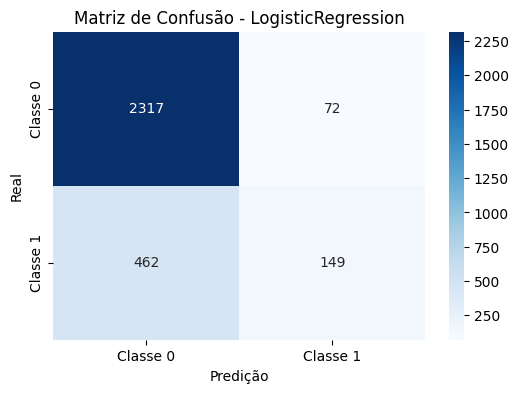


Relatório para LogisticRegression | Balanc: None | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.83      0.97      0.90      2389
    Classe 1       0.67      0.24      0.36       611

    accuracy                           0.82      3000
   macro avg       0.75      0.61      0.63      3000
weighted avg       0.80      0.82      0.79      3000

Tempo: 0.0301s

==================== RandomForest ====================
✨ Novo Recorde! RandomForest com recall_1: 0.4223


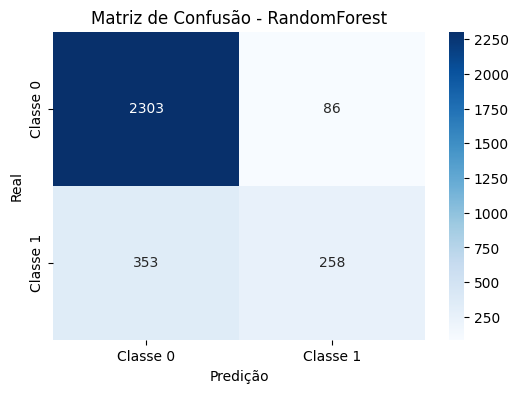


Relatório para RandomForest | Balanc: None | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.87      0.96      0.91      2389
    Classe 1       0.75      0.42      0.54       611

    accuracy                           0.85      3000
   macro avg       0.81      0.69      0.73      3000
weighted avg       0.84      0.85      0.84      3000

Tempo: 1.4839s

==================== SVM ====================


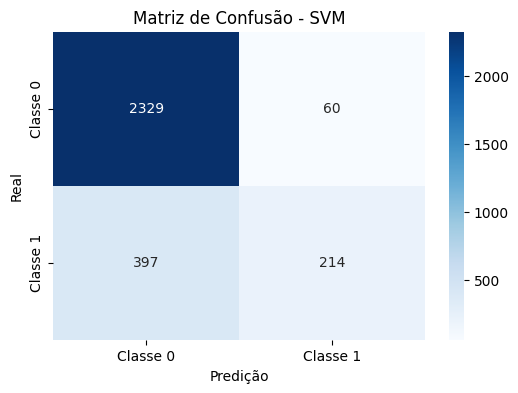


Relatório para SVM | Balanc: None | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.85      0.97      0.91      2389
    Classe 1       0.78      0.35      0.48       611

    accuracy                           0.85      3000
   macro avg       0.82      0.66      0.70      3000
weighted avg       0.84      0.85      0.82      3000

Tempo: 1.3589s

==================== KNN ====================


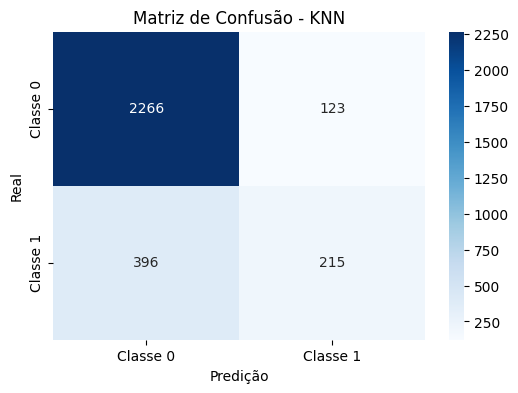


Relatório para KNN | Balanc: None | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.85      0.95      0.90      2389
    Classe 1       0.64      0.35      0.45       611

    accuracy                           0.83      3000
   macro avg       0.74      0.65      0.68      3000
weighted avg       0.81      0.83      0.81      3000

Tempo: 0.0039s

==================== DecisionTree ====================
✨ Novo Recorde! DecisionTree com recall_1: 0.4926


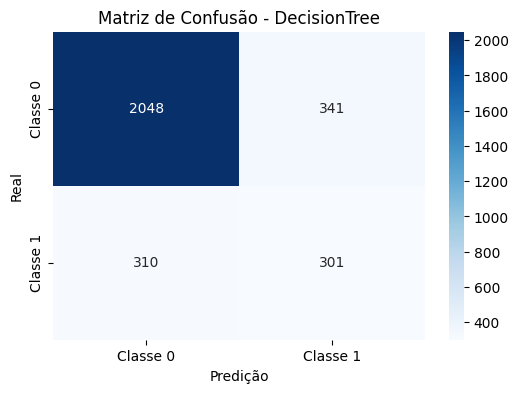


Relatório para DecisionTree | Balanc: None | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.87      0.86      0.86      2389
    Classe 1       0.47      0.49      0.48       611

    accuracy                           0.78      3000
   macro avg       0.67      0.67      0.67      3000
weighted avg       0.79      0.78      0.78      3000

Tempo: 0.0706s

==================== NeuralNetwork ====================


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


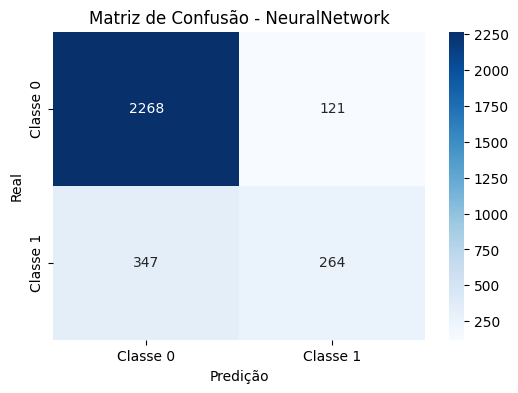


Relatório para NeuralNetwork | Balanc: None | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.87      0.95      0.91      2389
    Classe 1       0.69      0.43      0.53       611

    accuracy                           0.84      3000
   macro avg       0.78      0.69      0.72      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 5.7736s

==================== XGBoost ====================


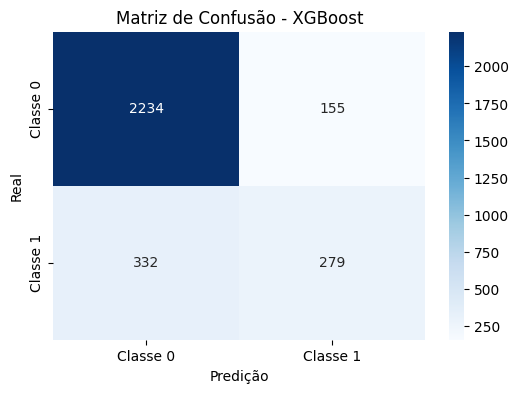


Relatório para XGBoost | Balanc: None | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.90      2389
    Classe 1       0.64      0.46      0.53       611

    accuracy                           0.84      3000
   macro avg       0.76      0.70      0.72      3000
weighted avg       0.82      0.84      0.83      3000

Tempo: 0.2444s

==================== AdaBoost ====================


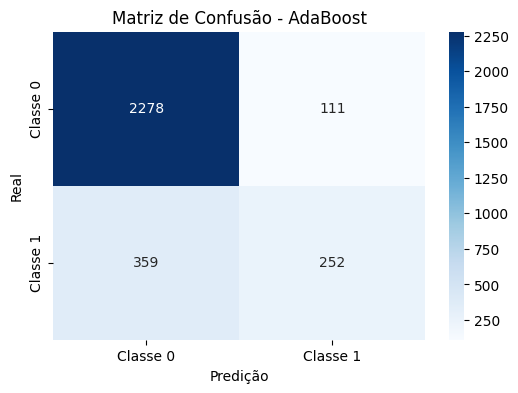


Relatório para AdaBoost | Balanc: None | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.86      0.95      0.91      2389
    Classe 1       0.69      0.41      0.52       611

    accuracy                           0.84      3000
   macro avg       0.78      0.68      0.71      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 0.4273s

🏆 Tabela de Resultados Final:


Modelo                                       Configuração  \
4        DecisionTree  DecisionTree | Balanc: None | PCA: Não | Param...   
6             XGBoost  XGBoost | Balanc: None | PCA: Não | Params: de...   
5       NeuralNetwork  NeuralNetwork | Balanc: None | PCA: Não | Para...   
1        RandomForest  RandomForest | Balanc: None | PCA: Não | Param...   
7            AdaBoost  AdaBoost | Balanc: None | PCA: Não | Params: d...   
3                 KNN    KNN | Balanc: None | PCA: Não | Params: default   
2                 SVM    SVM | Balanc: None | PCA: Não | Params: default   
0  LogisticRegression  LogisticRegression | Balanc: None | PCA: Não |...   

   Score Otimização (recall_1)  Recall (Classe 1)  Acurácia  Tempo (s)  \
4                     0.492635           0.492635  0.783000   0.070612   
6                     0.456628           0.456628  0.837667   0.244423   
5                     0.432079           0.432079  0.844000   5.773642   
1                     0.422259           0.422259  0.853667   1.483920   
7                     0.412439           0.412439  0.843333   0.427307   
3                     0.351882           0.351882  0.827000   0.003857   
2                     0.350245           0.350245  0.847667   1.358870   
0                     0.243863           0.243863  0.822000   0.030113   

  Melhores Parâmetros  
4                 N/A  
6                 N/A  
5                 N/A  
1                 N/A  
7                 N/A  
3                 N/A  
2                 N/A  
0                 N/A


💾 Melhor modelo salvo: DecisionTree (Score: 0.4926)

>>> 🧪 Testando Cenário: Default + SMOTE
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
✨ Novo Recorde! LogisticRegression com recall_1: 0.6236


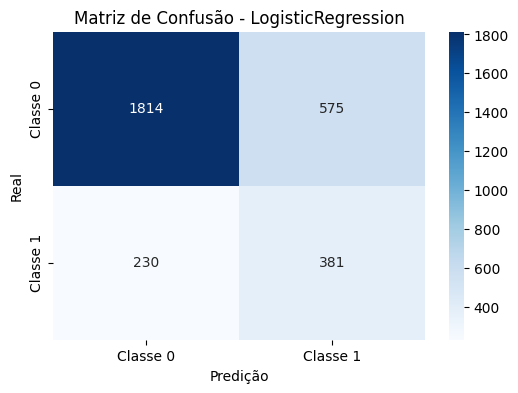


Relatório para LogisticRegression | Balanc: SMOTE | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.89      0.76      0.82      2389
    Classe 1       0.40      0.62      0.49       611

    accuracy                           0.73      3000
   macro avg       0.64      0.69      0.65      3000
weighted avg       0.79      0.73      0.75      3000

Tempo: 0.0279s

==================== RandomForest ====================


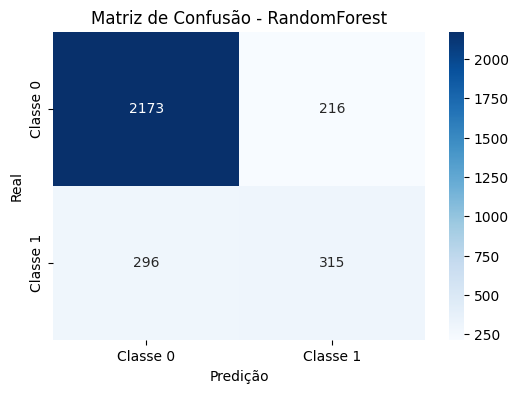


Relatório para RandomForest | Balanc: SMOTE | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.88      0.91      0.89      2389
    Classe 1       0.59      0.52      0.55       611

    accuracy                           0.83      3000
   macro avg       0.74      0.71      0.72      3000
weighted avg       0.82      0.83      0.82      3000

Tempo: 2.5850s

==================== SVM ====================


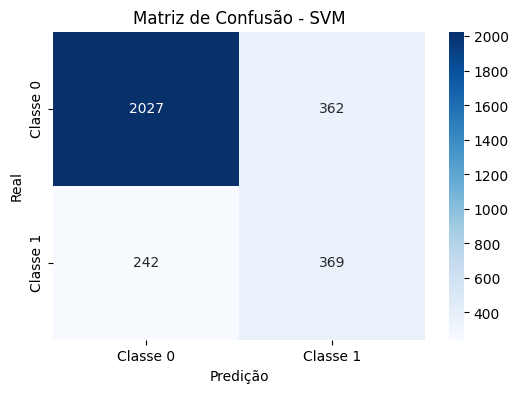


Relatório para SVM | Balanc: SMOTE | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.89      0.85      0.87      2389
    Classe 1       0.50      0.60      0.55       611

    accuracy                           0.80      3000
   macro avg       0.70      0.73      0.71      3000
weighted avg       0.81      0.80      0.81      3000

Tempo: 4.3862s

==================== KNN ====================
✨ Novo Recorde! KNN com recall_1: 0.6481


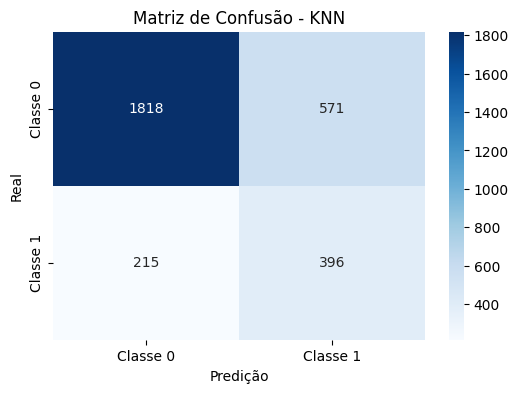


Relatório para KNN | Balanc: SMOTE | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.89      0.76      0.82      2389
    Classe 1       0.41      0.65      0.50       611

    accuracy                           0.74      3000
   macro avg       0.65      0.70      0.66      3000
weighted avg       0.80      0.74      0.76      3000

Tempo: 0.0067s

==================== DecisionTree ====================


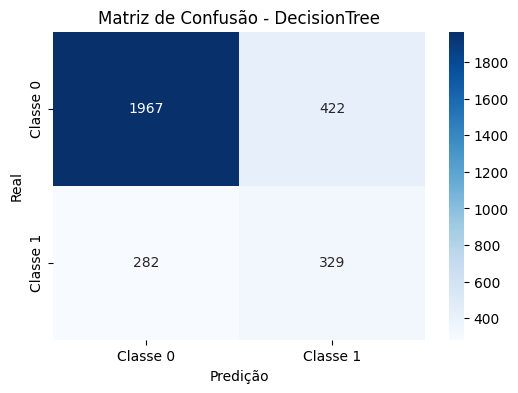


Relatório para DecisionTree | Balanc: SMOTE | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.87      0.82      0.85      2389
    Classe 1       0.44      0.54      0.48       611

    accuracy                           0.77      3000
   macro avg       0.66      0.68      0.67      3000
weighted avg       0.79      0.77      0.77      3000

Tempo: 0.1389s

==================== NeuralNetwork ====================


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


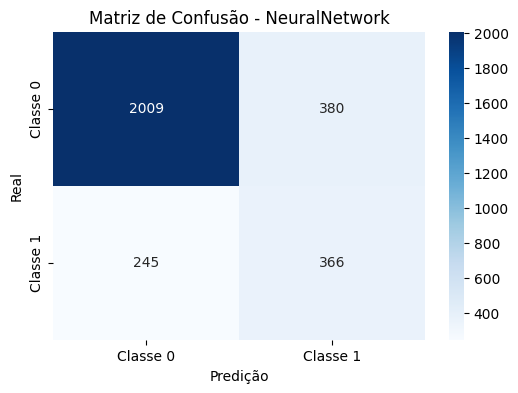


Relatório para NeuralNetwork | Balanc: SMOTE | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.89      0.84      0.87      2389
    Classe 1       0.49      0.60      0.54       611

    accuracy                           0.79      3000
   macro avg       0.69      0.72      0.70      3000
weighted avg       0.81      0.79      0.80      3000

Tempo: 8.0704s

==================== XGBoost ====================


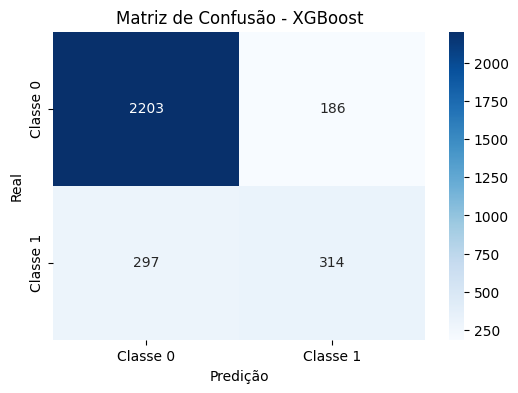


Relatório para XGBoost | Balanc: SMOTE | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.88      0.92      0.90      2389
    Classe 1       0.63      0.51      0.57       611

    accuracy                           0.84      3000
   macro avg       0.75      0.72      0.73      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 0.2641s

==================== AdaBoost ====================


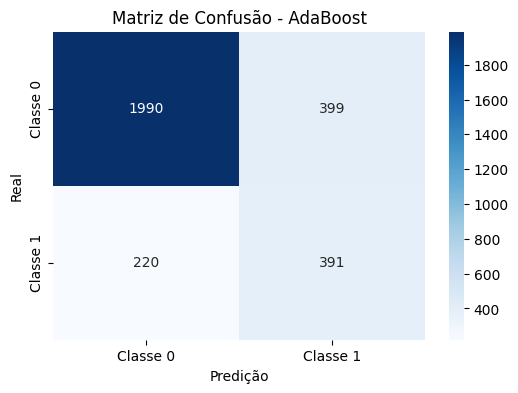


Relatório para AdaBoost | Balanc: SMOTE | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.90      0.83      0.87      2389
    Classe 1       0.49      0.64      0.56       611

    accuracy                           0.79      3000
   macro avg       0.70      0.74      0.71      3000
weighted avg       0.82      0.79      0.80      3000

Tempo: 0.8621s

🏆 Tabela de Resultados Final:


Modelo                                       Configuração  \
3                 KNN   KNN | Balanc: SMOTE | PCA: Não | Params: default   
7            AdaBoost  AdaBoost | Balanc: SMOTE | PCA: Não | Params: ...   
0  LogisticRegression  LogisticRegression | Balanc: SMOTE | PCA: Não ...   
2                 SVM   SVM | Balanc: SMOTE | PCA: Não | Params: default   
5       NeuralNetwork  NeuralNetwork | Balanc: SMOTE | PCA: Não | Par...   
4        DecisionTree  DecisionTree | Balanc: SMOTE | PCA: Não | Para...   
1        RandomForest  RandomForest | Balanc: SMOTE | PCA: Não | Para...   
6             XGBoost  XGBoost | Balanc: SMOTE | PCA: Não | Params: d...   

   Score Otimização (recall_1)  Recall (Classe 1)  Acurácia  Tempo (s)  \
3                     0.648118           0.648118  0.738000   0.006678   
7                     0.639935           0.639935  0.793667   0.862143   
0                     0.623568           0.623568  0.731667   0.027896   
2                     0.603928           0.603928  0.798667   4.386165   
5                     0.599018           0.599018  0.791667   8.070408   
4                     0.538462           0.538462  0.765333   0.138912   
1                     0.515548           0.515548  0.829333   2.584993   
6                     0.513912           0.513912  0.839000   0.264070   

  Melhores Parâmetros  
3                 N/A  
7                 N/A  
0                 N/A  
2                 N/A  
5                 N/A  
4                 N/A  
1                 N/A  
6                 N/A


💾 Melhor modelo salvo: KNN (Score: 0.6481)

>>> 🧪 Testando Cenário: Default + Tomek
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
✨ Novo Recorde! LogisticRegression com recall_1: 0.2831


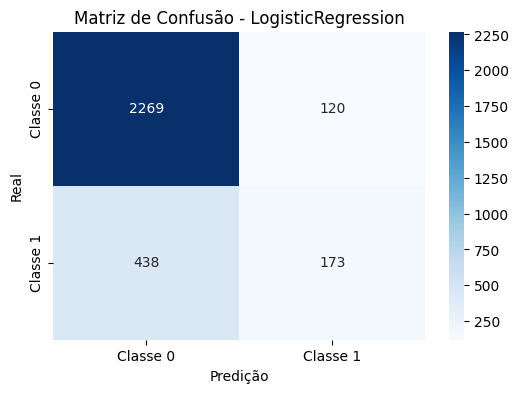


Relatório para LogisticRegression | Balanc: TomekLinks | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.84      0.95      0.89      2389
    Classe 1       0.59      0.28      0.38       611

    accuracy                           0.81      3000
   macro avg       0.71      0.62      0.64      3000
weighted avg       0.79      0.81      0.79      3000

Tempo: 0.0325s

==================== RandomForest ====================
✨ Novo Recorde! RandomForest com recall_1: 0.4452


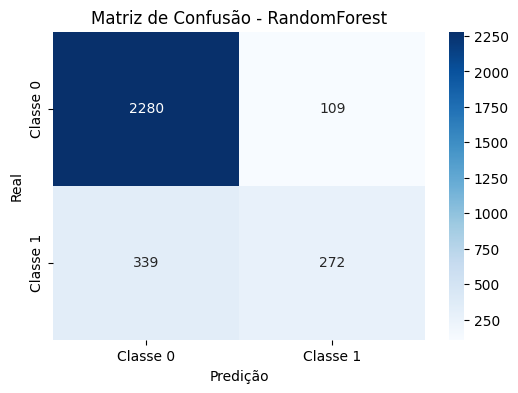


Relatório para RandomForest | Balanc: TomekLinks | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.87      0.95      0.91      2389
    Classe 1       0.71      0.45      0.55       611

    accuracy                           0.85      3000
   macro avg       0.79      0.70      0.73      3000
weighted avg       0.84      0.85      0.84      3000

Tempo: 1.5597s

==================== SVM ====================


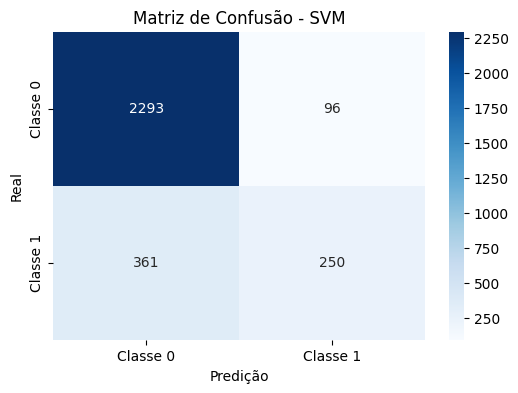


Relatório para SVM | Balanc: TomekLinks | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.86      0.96      0.91      2389
    Classe 1       0.72      0.41      0.52       611

    accuracy                           0.85      3000
   macro avg       0.79      0.68      0.72      3000
weighted avg       0.84      0.85      0.83      3000

Tempo: 1.0058s

==================== KNN ====================


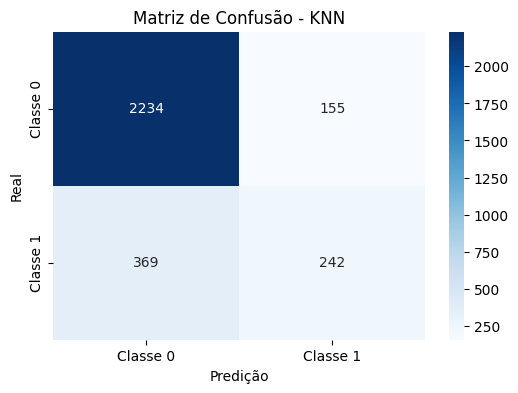


Relatório para KNN | Balanc: TomekLinks | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.86      0.94      0.90      2389
    Classe 1       0.61      0.40      0.48       611

    accuracy                           0.83      3000
   macro avg       0.73      0.67      0.69      3000
weighted avg       0.81      0.83      0.81      3000

Tempo: 0.0038s

==================== DecisionTree ====================
✨ Novo Recorde! DecisionTree com recall_1: 0.5172


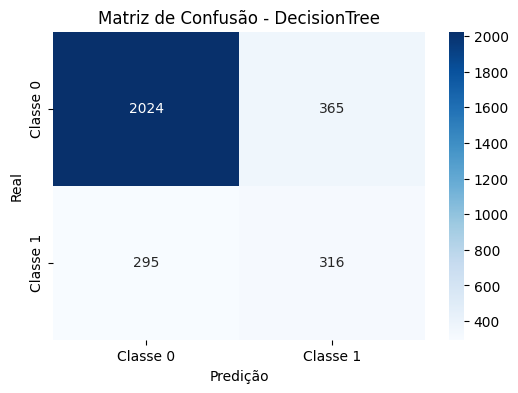


Relatório para DecisionTree | Balanc: TomekLinks | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.87      0.85      0.86      2389
    Classe 1       0.46      0.52      0.49       611

    accuracy                           0.78      3000
   macro avg       0.67      0.68      0.67      3000
weighted avg       0.79      0.78      0.78      3000

Tempo: 0.0726s

==================== NeuralNetwork ====================


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


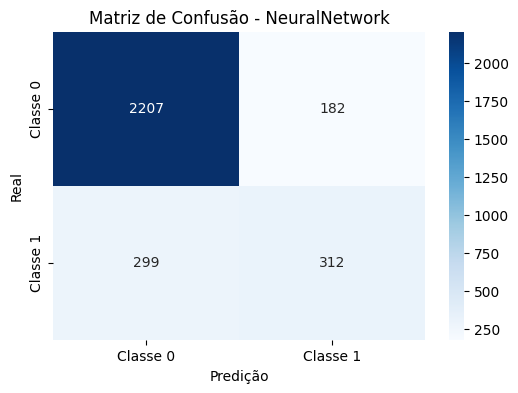


Relatório para NeuralNetwork | Balanc: TomekLinks | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.88      0.92      0.90      2389
    Classe 1       0.63      0.51      0.56       611

    accuracy                           0.84      3000
   macro avg       0.76      0.72      0.73      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 4.8054s

==================== XGBoost ====================


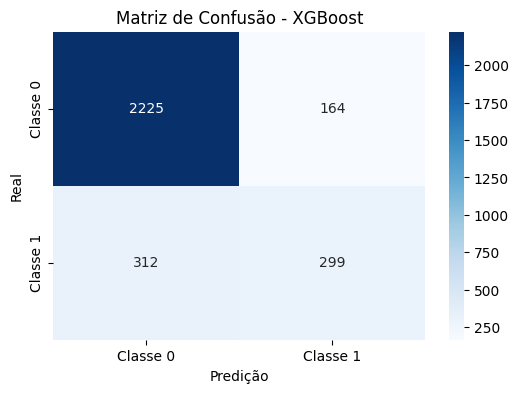


Relatório para XGBoost | Balanc: TomekLinks | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.88      0.93      0.90      2389
    Classe 1       0.65      0.49      0.56       611

    accuracy                           0.84      3000
   macro avg       0.76      0.71      0.73      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 0.2176s

==================== AdaBoost ====================


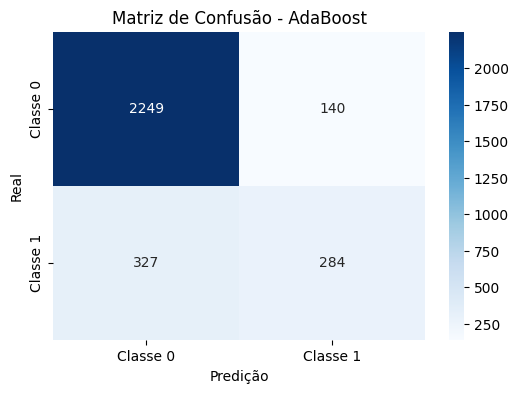


Relatório para AdaBoost | Balanc: TomekLinks | PCA: Não | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.91      2389
    Classe 1       0.67      0.46      0.55       611

    accuracy                           0.84      3000
   macro avg       0.77      0.70      0.73      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 0.4057s

🏆 Tabela de Resultados Final:


Modelo                                       Configuração  \
4        DecisionTree  DecisionTree | Balanc: TomekLinks | PCA: Não |...   
5       NeuralNetwork  NeuralNetwork | Balanc: TomekLinks | PCA: Não ...   
6             XGBoost  XGBoost | Balanc: TomekLinks | PCA: Não | Para...   
7            AdaBoost  AdaBoost | Balanc: TomekLinks | PCA: Não | Par...   
1        RandomForest  RandomForest | Balanc: TomekLinks | PCA: Não |...   
2                 SVM  SVM | Balanc: TomekLinks | PCA: Não | Params: ...   
3                 KNN  KNN | Balanc: TomekLinks | PCA: Não | Params: ...   
0  LogisticRegression  LogisticRegression | Balanc: TomekLinks | PCA:...   

   Score Otimização (recall_1)  Recall (Classe 1)  Acurácia  Tempo (s)  \
4                     0.517185           0.517185  0.780000   0.072565   
5                     0.510638           0.510638  0.839667   4.805366   
6                     0.489362           0.489362  0.841333   0.217551   
7                     0.464812           0.464812  0.844333   0.405712   
1                     0.445172           0.445172  0.850667   1.559678   
2                     0.409165           0.409165  0.847667   1.005766   
3                     0.396072           0.396072  0.825333   0.003814   
0                     0.283142           0.283142  0.814000   0.032462   

  Melhores Parâmetros  
4                 N/A  
5                 N/A  
6                 N/A  
7                 N/A  
1                 N/A  
2                 N/A  
3                 N/A  
0                 N/A


💾 Melhor modelo salvo: DecisionTree (Score: 0.5172)

>>> 🧪 Testando Cenário: Default + PCA + SMOTE
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
✨ Novo Recorde! LogisticRegression com recall_1: 0.6498


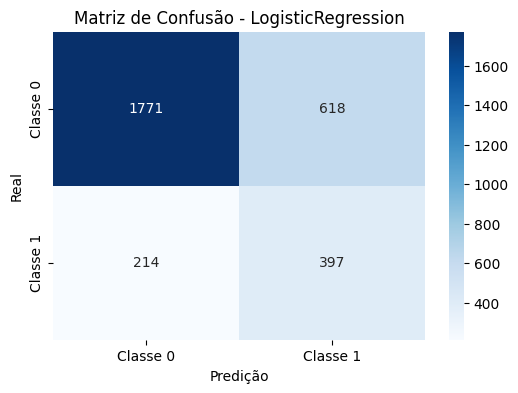


Relatório para LogisticRegression | Balanc: SMOTE | PCA: Sim | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.89      0.74      0.81      2389
    Classe 1       0.39      0.65      0.49       611

    accuracy                           0.72      3000
   macro avg       0.64      0.70      0.65      3000
weighted avg       0.79      0.72      0.74      3000

Tempo: 0.0339s

==================== RandomForest ====================


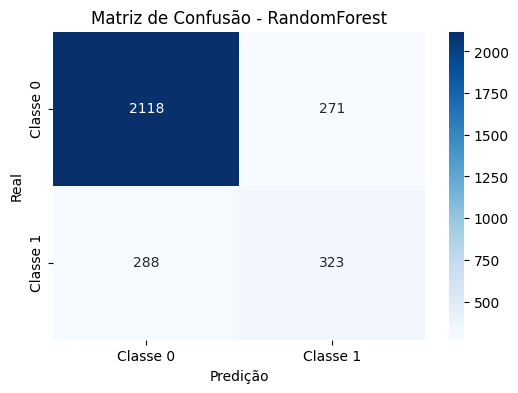


Relatório para RandomForest | Balanc: SMOTE | PCA: Sim | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.88      0.89      0.88      2389
    Classe 1       0.54      0.53      0.54       611

    accuracy                           0.81      3000
   macro avg       0.71      0.71      0.71      3000
weighted avg       0.81      0.81      0.81      3000

Tempo: 6.1752s

==================== SVM ====================


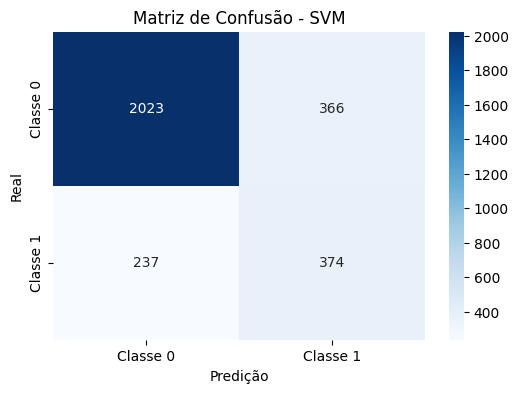


Relatório para SVM | Balanc: SMOTE | PCA: Sim | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.90      0.85      0.87      2389
    Classe 1       0.51      0.61      0.55       611

    accuracy                           0.80      3000
   macro avg       0.70      0.73      0.71      3000
weighted avg       0.82      0.80      0.81      3000

Tempo: 3.9635s

==================== KNN ====================


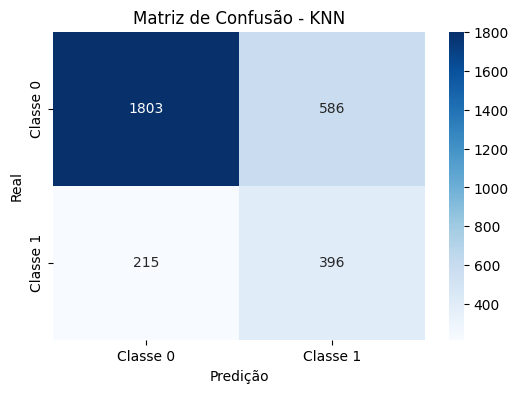


Relatório para KNN | Balanc: SMOTE | PCA: Sim | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.89      0.75      0.82      2389
    Classe 1       0.40      0.65      0.50       611

    accuracy                           0.73      3000
   macro avg       0.65      0.70      0.66      3000
weighted avg       0.79      0.73      0.75      3000

Tempo: 0.0246s

==================== DecisionTree ====================


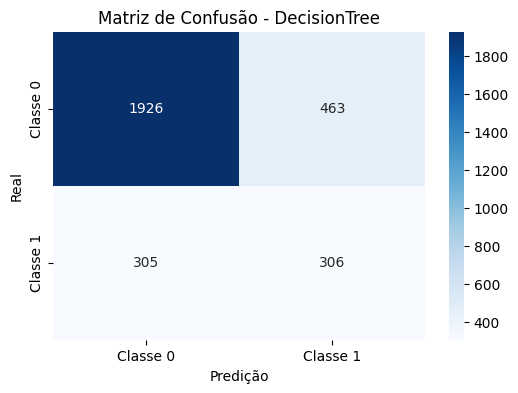


Relatório para DecisionTree | Balanc: SMOTE | PCA: Sim | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.86      0.81      0.83      2389
    Classe 1       0.40      0.50      0.44       611

    accuracy                           0.74      3000
   macro avg       0.63      0.65      0.64      3000
weighted avg       0.77      0.74      0.75      3000

Tempo: 0.3714s

==================== NeuralNetwork ====================


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


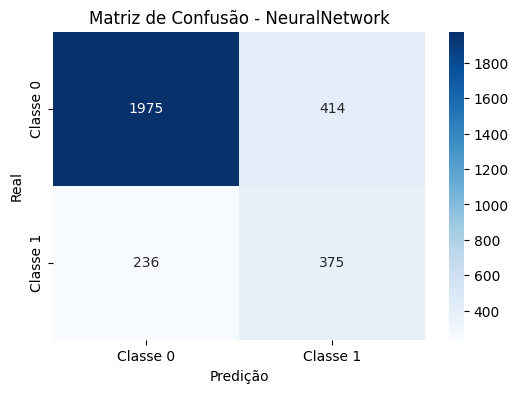


Relatório para NeuralNetwork | Balanc: SMOTE | PCA: Sim | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.89      0.83      0.86      2389
    Classe 1       0.48      0.61      0.54       611

    accuracy                           0.78      3000
   macro avg       0.68      0.72      0.70      3000
weighted avg       0.81      0.78      0.79      3000

Tempo: 8.5533s

==================== XGBoost ====================


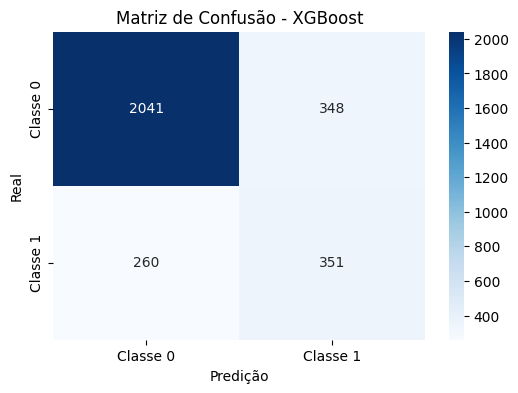


Relatório para XGBoost | Balanc: SMOTE | PCA: Sim | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.89      0.85      0.87      2389
    Classe 1       0.50      0.57      0.54       611

    accuracy                           0.80      3000
   macro avg       0.69      0.71      0.70      3000
weighted avg       0.81      0.80      0.80      3000

Tempo: 0.5011s

==================== AdaBoost ====================


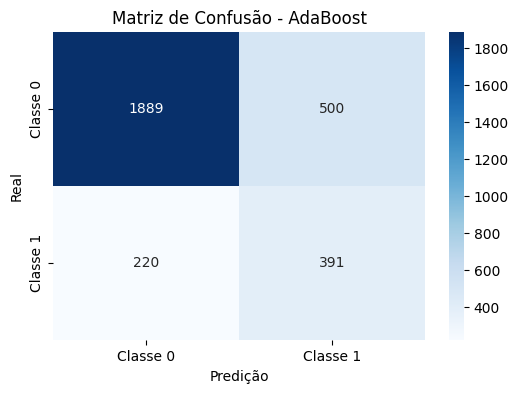


Relatório para AdaBoost | Balanc: SMOTE | PCA: Sim | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.90      0.79      0.84      2389
    Classe 1       0.44      0.64      0.52       611

    accuracy                           0.76      3000
   macro avg       0.67      0.72      0.68      3000
weighted avg       0.80      0.76      0.77      3000

Tempo: 1.8241s

🏆 Tabela de Resultados Final:


Modelo                                       Configuração  \
0  LogisticRegression  LogisticRegression | Balanc: SMOTE | PCA: Sim ...   
3                 KNN   KNN | Balanc: SMOTE | PCA: Sim | Params: default   
7            AdaBoost  AdaBoost | Balanc: SMOTE | PCA: Sim | Params: ...   
5       NeuralNetwork  NeuralNetwork | Balanc: SMOTE | PCA: Sim | Par...   
2                 SVM   SVM | Balanc: SMOTE | PCA: Sim | Params: default   
6             XGBoost  XGBoost | Balanc: SMOTE | PCA: Sim | Params: d...   
1        RandomForest  RandomForest | Balanc: SMOTE | PCA: Sim | Para...   
4        DecisionTree  DecisionTree | Balanc: SMOTE | PCA: Sim | Para...   

   Score Otimização (recall_1)  Recall (Classe 1)  Acurácia  Tempo (s)  \
0                     0.649755           0.649755  0.722667   0.033947   
3                     0.648118           0.648118  0.733000   0.024581   
7                     0.639935           0.639935  0.760000   1.824061   
5                     0.613748           0.613748  0.783333   8.553277   
2                     0.612111           0.612111  0.799000   3.963468   
6                     0.574468           0.574468  0.797333   0.501120   
1                     0.528642           0.528642  0.813667   6.175211   
4                     0.500818           0.500818  0.744000   0.371360   

  Melhores Parâmetros  
0                 N/A  
3                 N/A  
7                 N/A  
5                 N/A  
2                 N/A  
6                 N/A  
1                 N/A  
4                 N/A


💾 Melhor modelo salvo: LogisticRegression (Score: 0.6498)

>>> 🧪 Testando Cenário: Default + PCA + Tomek
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
✨ Novo Recorde! LogisticRegression com recall_1: 0.2700


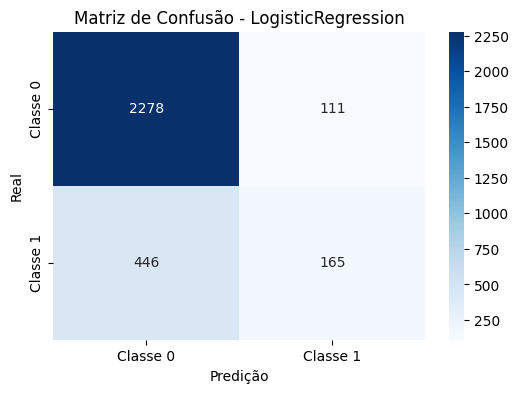


Relatório para LogisticRegression | Balanc: TomekLinks | PCA: Sim | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.84      0.95      0.89      2389
    Classe 1       0.60      0.27      0.37       611

    accuracy                           0.81      3000
   macro avg       0.72      0.61      0.63      3000
weighted avg       0.79      0.81      0.79      3000

Tempo: 0.0253s

==================== RandomForest ====================
✨ Novo Recorde! RandomForest com recall_1: 0.4108


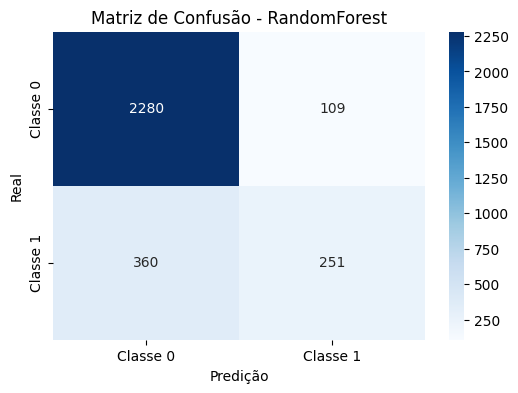


Relatório para RandomForest | Balanc: TomekLinks | PCA: Sim | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.86      0.95      0.91      2389
    Classe 1       0.70      0.41      0.52       611

    accuracy                           0.84      3000
   macro avg       0.78      0.68      0.71      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 4.3496s

==================== SVM ====================


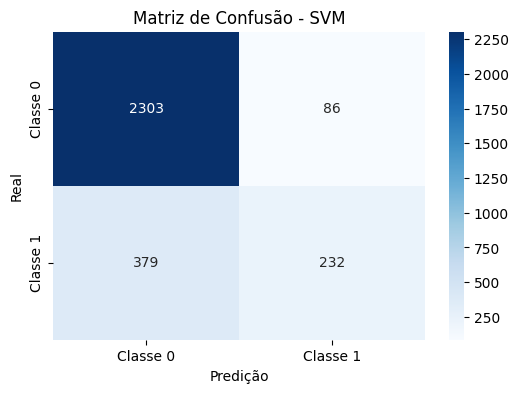


Relatório para SVM | Balanc: TomekLinks | PCA: Sim | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.86      0.96      0.91      2389
    Classe 1       0.73      0.38      0.50       611

    accuracy                           0.84      3000
   macro avg       0.79      0.67      0.70      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 1.1275s

==================== KNN ====================


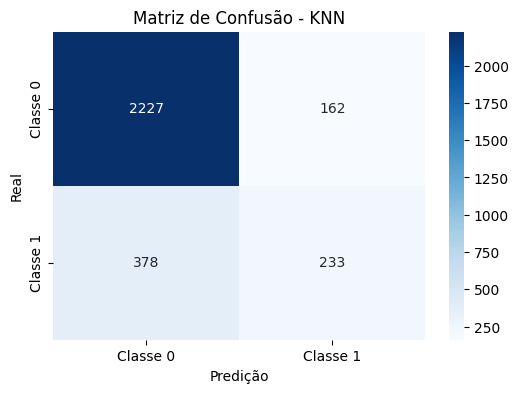


Relatório para KNN | Balanc: TomekLinks | PCA: Sim | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.85      0.93      0.89      2389
    Classe 1       0.59      0.38      0.46       611

    accuracy                           0.82      3000
   macro avg       0.72      0.66      0.68      3000
weighted avg       0.80      0.82      0.80      3000

Tempo: 0.0230s

==================== DecisionTree ====================
✨ Novo Recorde! DecisionTree com recall_1: 0.5123


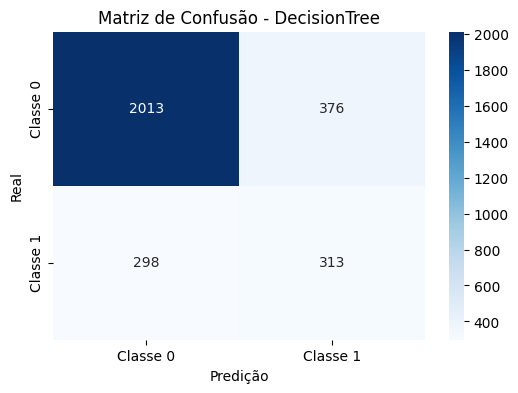


Relatório para DecisionTree | Balanc: TomekLinks | PCA: Sim | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.87      0.84      0.86      2389
    Classe 1       0.45      0.51      0.48       611

    accuracy                           0.78      3000
   macro avg       0.66      0.68      0.67      3000
weighted avg       0.79      0.78      0.78      3000

Tempo: 0.2376s

==================== NeuralNetwork ====================


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


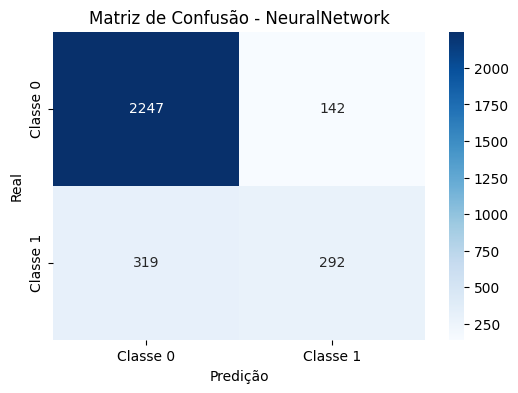


Relatório para NeuralNetwork | Balanc: TomekLinks | PCA: Sim | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.88      0.94      0.91      2389
    Classe 1       0.67      0.48      0.56       611

    accuracy                           0.85      3000
   macro avg       0.77      0.71      0.73      3000
weighted avg       0.83      0.85      0.84      3000

Tempo: 4.5861s

==================== XGBoost ====================


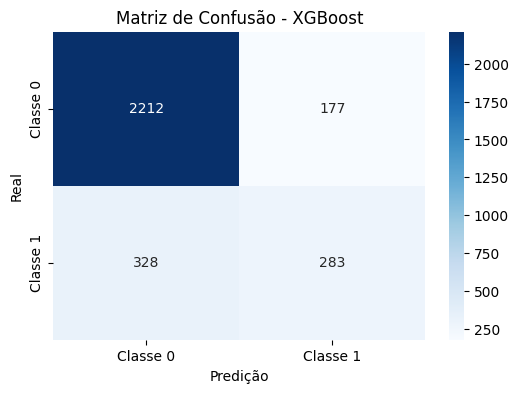


Relatório para XGBoost | Balanc: TomekLinks | PCA: Sim | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.87      0.93      0.90      2389
    Classe 1       0.62      0.46      0.53       611

    accuracy                           0.83      3000
   macro avg       0.74      0.69      0.71      3000
weighted avg       0.82      0.83      0.82      3000

Tempo: 0.3932s

==================== AdaBoost ====================


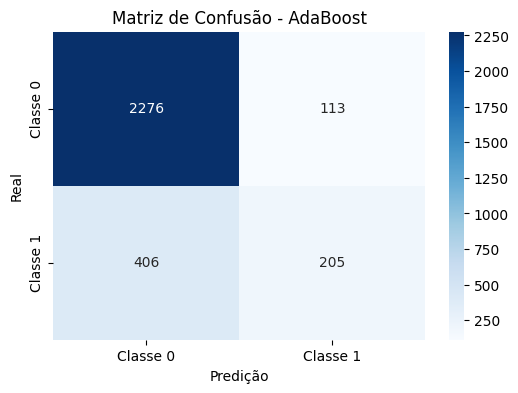


Relatório para AdaBoost | Balanc: TomekLinks | PCA: Sim | Params: default:
              precision    recall  f1-score   support

    Classe 0       0.85      0.95      0.90      2389
    Classe 1       0.64      0.34      0.44       611

    accuracy                           0.83      3000
   macro avg       0.75      0.64      0.67      3000
weighted avg       0.81      0.83      0.80      3000

Tempo: 1.2798s

🏆 Tabela de Resultados Final:


Modelo                                       Configuração  \
4        DecisionTree  DecisionTree | Balanc: TomekLinks | PCA: Sim |...   
5       NeuralNetwork  NeuralNetwork | Balanc: TomekLinks | PCA: Sim ...   
6             XGBoost  XGBoost | Balanc: TomekLinks | PCA: Sim | Para...   
1        RandomForest  RandomForest | Balanc: TomekLinks | PCA: Sim |...   
3                 KNN  KNN | Balanc: TomekLinks | PCA: Sim | Params: ...   
2                 SVM  SVM | Balanc: TomekLinks | PCA: Sim | Params: ...   
7            AdaBoost  AdaBoost | Balanc: TomekLinks | PCA: Sim | Par...   
0  LogisticRegression  LogisticRegression | Balanc: TomekLinks | PCA:...   

   Score Otimização (recall_1)  Recall (Classe 1)  Acurácia  Tempo (s)  \
4                     0.512275           0.512275  0.775333   0.237551   
5                     0.477905           0.477905  0.846333   4.586086   
6                     0.463175           0.463175  0.831667   0.393164   
1                     0.410802           0.410802  0.843667   4.349554   
3                     0.381342           0.381342  0.820000   0.022952   
2                     0.379705           0.379705  0.845000   1.127455   
7                     0.335516           0.335516  0.827000   1.279808   
0                     0.270049           0.270049  0.814333   0.025297   

  Melhores Parâmetros  
4                 N/A  
5                 N/A  
6                 N/A  
1                 N/A  
3                 N/A  
2                 N/A  
7                 N/A  
0                 N/A


💾 Melhor modelo salvo: DecisionTree (Score: 0.5123)

>>> 🧪 Testando Cenário: Grid
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✨ Novo Recorde! LogisticRegression com recall_1: 0.2471


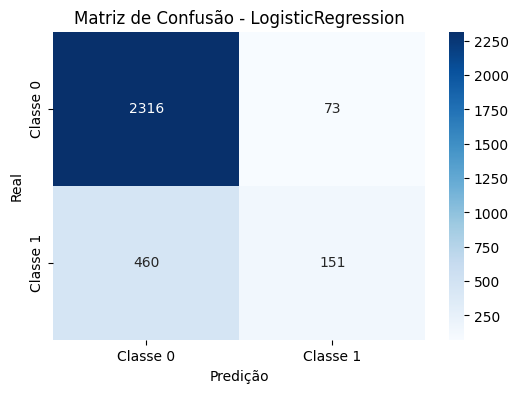


Relatório para LogisticRegression | Balanc: None | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.83      0.97      0.90      2389
    Classe 1       0.67      0.25      0.36       611

    accuracy                           0.82      3000
   macro avg       0.75      0.61      0.63      3000
weighted avg       0.80      0.82      0.79      3000

Tempo: 4.8424s

==================== RandomForest ====================
Fitting 5 folds for each of 36 candidates, totalling 180 fits
✨ Novo Recorde! RandomForest com recall_1: 0.4206


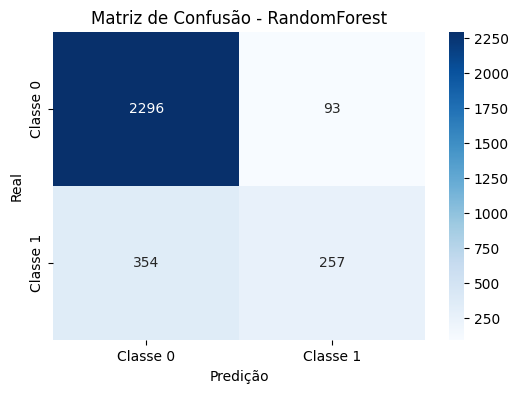


Relatório para RandomForest | Balanc: None | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.87      0.96      0.91      2389
    Classe 1       0.73      0.42      0.53       611

    accuracy                           0.85      3000
   macro avg       0.80      0.69      0.72      3000
weighted avg       0.84      0.85      0.83      3000

Tempo: 325.3268s

==================== SVM ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✨ Novo Recorde! SVM com recall_1: 0.4354


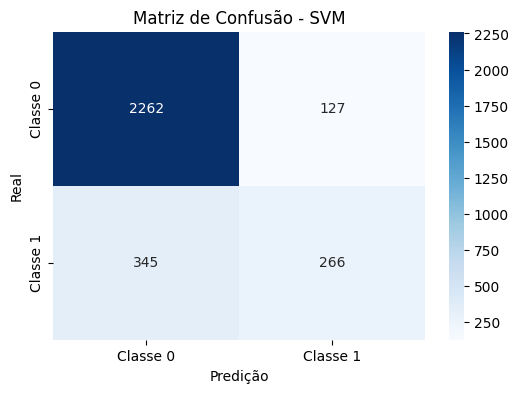


Relatório para SVM | Balanc: None | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.87      0.95      0.91      2389
    Classe 1       0.68      0.44      0.53       611

    accuracy                           0.84      3000
   macro avg       0.77      0.69      0.72      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 67.0429s

==================== KNN ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


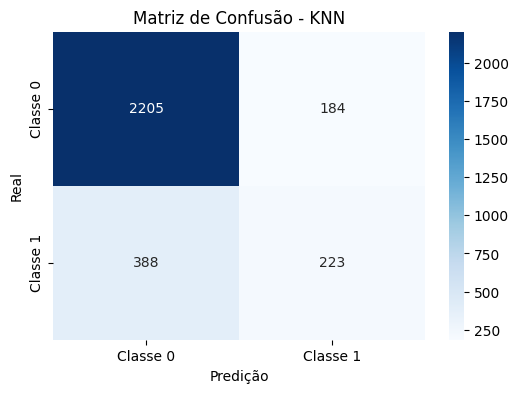


Relatório para KNN | Balanc: None | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.85      0.92      0.89      2389
    Classe 1       0.55      0.36      0.44       611

    accuracy                           0.81      3000
   macro avg       0.70      0.64      0.66      3000
weighted avg       0.79      0.81      0.79      3000

Tempo: 5.8316s

==================== DecisionTree ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✨ Novo Recorde! DecisionTree com recall_1: 0.4894


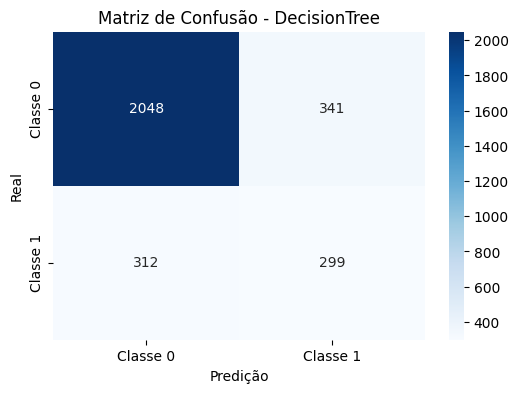


Relatório para DecisionTree | Balanc: None | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.87      0.86      0.86      2389
    Classe 1       0.47      0.49      0.48       611

    accuracy                           0.78      3000
   macro avg       0.67      0.67      0.67      3000
weighted avg       0.79      0.78      0.78      3000

Tempo: 3.7922s

==================== NeuralNetwork ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


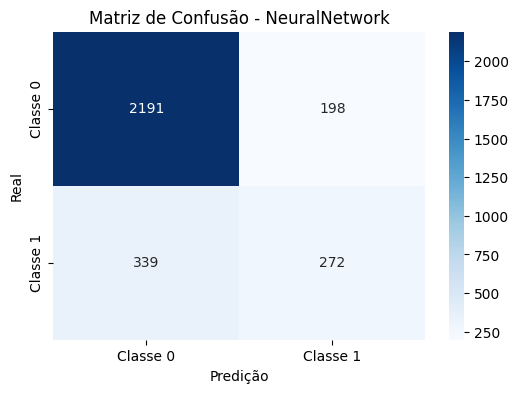


Relatório para NeuralNetwork | Balanc: None | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.87      0.92      0.89      2389
    Classe 1       0.58      0.45      0.50       611

    accuracy                           0.82      3000
   macro avg       0.72      0.68      0.70      3000
weighted avg       0.81      0.82      0.81      3000

Tempo: 321.8931s

==================== XGBoost ====================
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


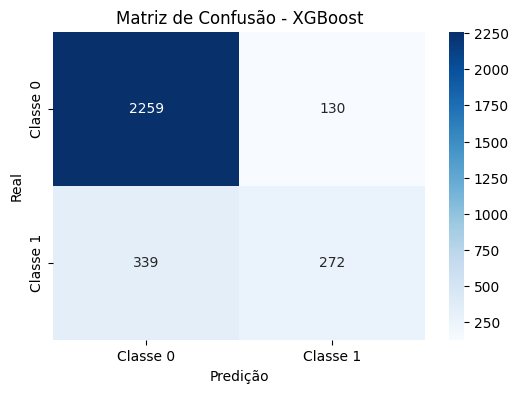


Relatório para XGBoost | Balanc: None | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.87      0.95      0.91      2389
    Classe 1       0.68      0.45      0.54       611

    accuracy                           0.84      3000
   macro avg       0.77      0.70      0.72      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 338.6693s

==================== AdaBoost ====================
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_

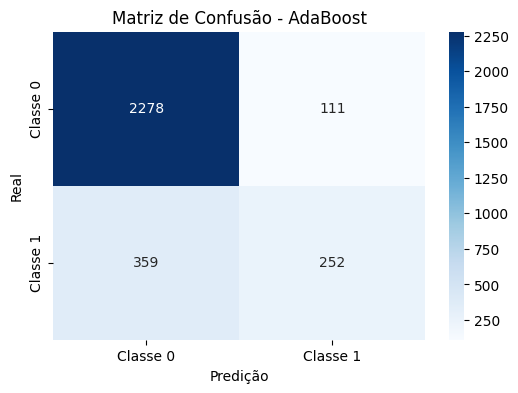


Relatório para AdaBoost | Balanc: None | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.86      0.95      0.91      2389
    Classe 1       0.69      0.41      0.52       611

    accuracy                           0.84      3000
   macro avg       0.78      0.68      0.71      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 33.4524s

🏆 Tabela de Resultados Final:


Modelo                                       Configuração  \
4        DecisionTree  DecisionTree | Balanc: None | PCA: Não | Param...   
5       NeuralNetwork  NeuralNetwork | Balanc: None | PCA: Não | Para...   
6             XGBoost   XGBoost | Balanc: None | PCA: Não | Params: grid   
2                 SVM       SVM | Balanc: None | PCA: Não | Params: grid   
1        RandomForest  RandomForest | Balanc: None | PCA: Não | Param...   
7            AdaBoost  AdaBoost | Balanc: None | PCA: Não | Params: grid   
3                 KNN       KNN | Balanc: None | PCA: Não | Params: grid   
0  LogisticRegression  LogisticRegression | Balanc: None | PCA: Não |...   

   Score Otimização (recall_1)  Recall (Classe 1)  Acurácia   Tempo (s)  \
4                     0.489362           0.489362  0.782333    3.792226   
5                     0.445172           0.445172  0.821000  321.893098   
6                     0.445172           0.445172  0.843667  338.669267   
2                     0.435352           0.435352  0.842667   67.042915   
1                     0.420622           0.420622  0.851000  325.326832   
7                     0.412439           0.412439  0.843333   33.452391   
3                     0.364975           0.364975  0.809333    5.831648   
0                     0.247136           0.247136  0.822333    4.842360   

                                 Melhores Parâmetros  
4  {'max_depth': None, 'min_samples_leaf': 1, 'mi...  
5  {'activation': 'relu', 'alpha': 0.0001, 'hidde...  
6  {'colsample_bytree': 1.0, 'learning_rate': 0.2...  
2       {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}  
1  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...  
7  {'algorithm': 'SAMME', 'learning_rate': 1.0, '...  
3  {'metric': 'euclidean', 'n_neighbors': 3, 'wei...  
0    {'C': 10.0, 'max_iter': 500, 'solver': 'lbfgs'}


💾 Melhor modelo salvo: DecisionTree (Score: 0.4894)

>>> 🧪 Testando Cenário: Grid + SMOTE
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✨ Novo Recorde! LogisticRegression com recall_1: 0.6236


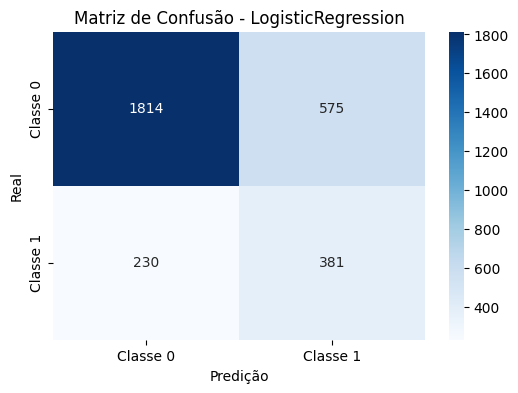


Relatório para LogisticRegression | Balanc: SMOTE | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.89      0.76      0.82      2389
    Classe 1       0.40      0.62      0.49       611

    accuracy                           0.73      3000
   macro avg       0.64      0.69      0.65      3000
weighted avg       0.79      0.73      0.75      3000

Tempo: 1.3676s

==================== RandomForest ====================
Fitting 5 folds for each of 36 candidates, totalling 180 fits


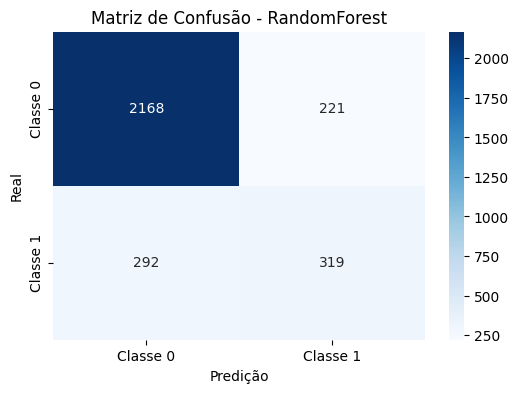


Relatório para RandomForest | Balanc: SMOTE | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.88      0.91      0.89      2389
    Classe 1       0.59      0.52      0.55       611

    accuracy                           0.83      3000
   macro avg       0.74      0.71      0.72      3000
weighted avg       0.82      0.83      0.82      3000

Tempo: 564.6677s

==================== SVM ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


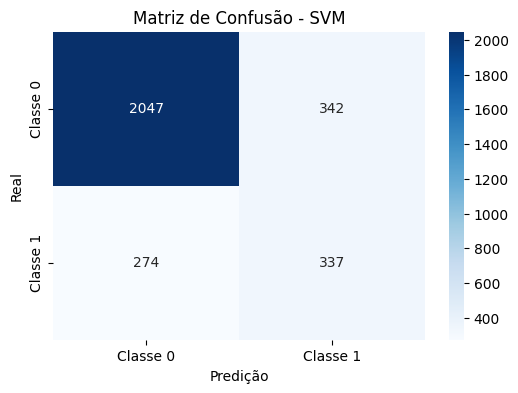


Relatório para SVM | Balanc: SMOTE | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.88      0.86      0.87      2389
    Classe 1       0.50      0.55      0.52       611

    accuracy                           0.79      3000
   macro avg       0.69      0.70      0.70      3000
weighted avg       0.80      0.79      0.80      3000

Tempo: 300.5654s

==================== KNN ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


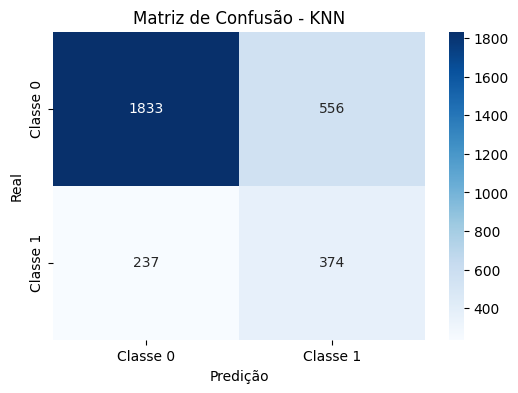


Relatório para KNN | Balanc: SMOTE | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.89      0.77      0.82      2389
    Classe 1       0.40      0.61      0.49       611

    accuracy                           0.74      3000
   macro avg       0.64      0.69      0.65      3000
weighted avg       0.79      0.74      0.75      3000

Tempo: 14.9367s

==================== DecisionTree ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


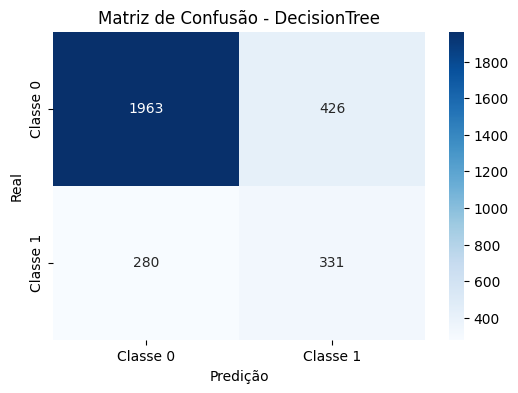


Relatório para DecisionTree | Balanc: SMOTE | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.88      0.82      0.85      2389
    Classe 1       0.44      0.54      0.48       611

    accuracy                           0.76      3000
   macro avg       0.66      0.68      0.67      3000
weighted avg       0.79      0.76      0.77      3000

Tempo: 4.7307s

==================== NeuralNetwork ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


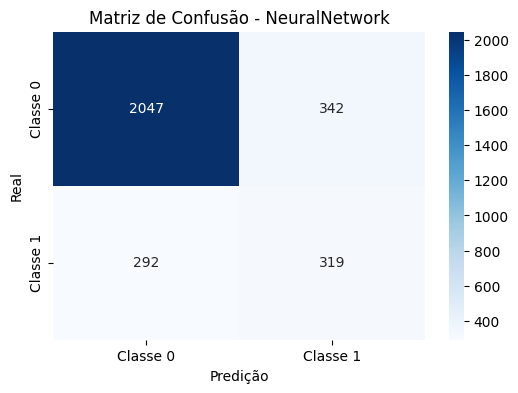


Relatório para NeuralNetwork | Balanc: SMOTE | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.88      0.86      0.87      2389
    Classe 1       0.48      0.52      0.50       611

    accuracy                           0.79      3000
   macro avg       0.68      0.69      0.68      3000
weighted avg       0.80      0.79      0.79      3000

Tempo: 535.0567s

==================== XGBoost ====================
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


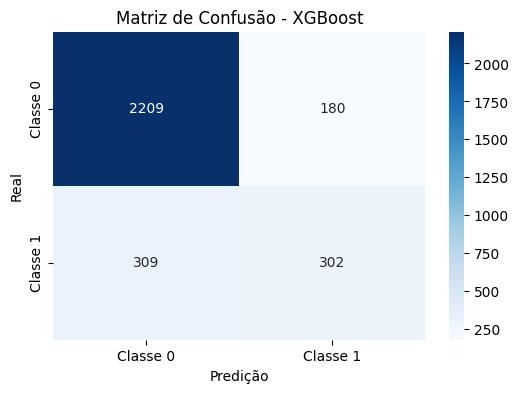


Relatório para XGBoost | Balanc: SMOTE | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.88      0.92      0.90      2389
    Classe 1       0.63      0.49      0.55       611

    accuracy                           0.84      3000
   macro avg       0.75      0.71      0.73      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 484.8184s

==================== AdaBoost ====================
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_

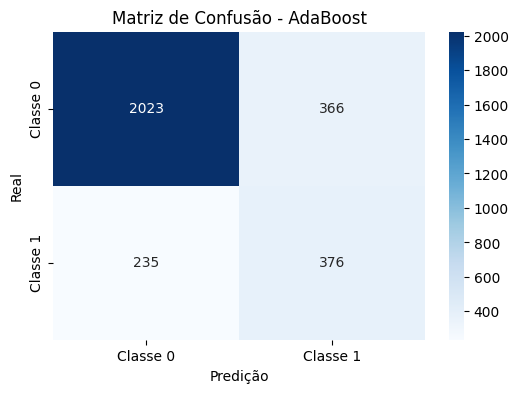


Relatório para AdaBoost | Balanc: SMOTE | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.90      0.85      0.87      2389
    Classe 1       0.51      0.62      0.56       611

    accuracy                           0.80      3000
   macro avg       0.70      0.73      0.71      3000
weighted avg       0.82      0.80      0.81      3000

Tempo: 56.0703s

🏆 Tabela de Resultados Final:


Modelo                                       Configuração  \
0  LogisticRegression  LogisticRegression | Balanc: SMOTE | PCA: Não ...   
7            AdaBoost  AdaBoost | Balanc: SMOTE | PCA: Não | Params: ...   
3                 KNN      KNN | Balanc: SMOTE | PCA: Não | Params: grid   
2                 SVM      SVM | Balanc: SMOTE | PCA: Não | Params: grid   
4        DecisionTree  DecisionTree | Balanc: SMOTE | PCA: Não | Para...   
1        RandomForest  RandomForest | Balanc: SMOTE | PCA: Não | Para...   
5       NeuralNetwork  NeuralNetwork | Balanc: SMOTE | PCA: Não | Par...   
6             XGBoost  XGBoost | Balanc: SMOTE | PCA: Não | Params: grid   

   Score Otimização (recall_1)  Recall (Classe 1)  Acurácia   Tempo (s)  \
0                     0.623568           0.623568  0.731667    1.367602   
7                     0.615385           0.615385  0.799667   56.070324   
3                     0.612111           0.612111  0.735667   14.936653   
2                     0.551555           0.551555  0.794667  300.565402   
4                     0.541735           0.541735  0.764667    4.730731   
1                     0.522095           0.522095  0.829000  564.667742   
5                     0.522095           0.522095  0.788667  535.056661   
6                     0.494272           0.494272  0.837000  484.818427   

                                 Melhores Parâmetros  
0  {'C': 1.0, 'max_iter': 500, 'solver': 'libline...  
7  {'algorithm': 'SAMME', 'learning_rate': 1.0, '...  
3  {'metric': 'euclidean', 'n_neighbors': 3, 'wei...  
2       {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}  
4  {'max_depth': None, 'min_samples_leaf': 1, 'mi...  
1  {'max_depth': None, 'min_samples_leaf': 1, 'mi...  
5  {'activation': 'tanh', 'alpha': 0.001, 'hidden...  
6  {'colsample_bytree': 1.0, 'learning_rate': 0.2...


💾 Melhor modelo salvo: LogisticRegression (Score: 0.6236)

>>> 🧪 Testando Cenário: Grid + Tomek
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✨ Novo Recorde! LogisticRegression com recall_1: 0.2831


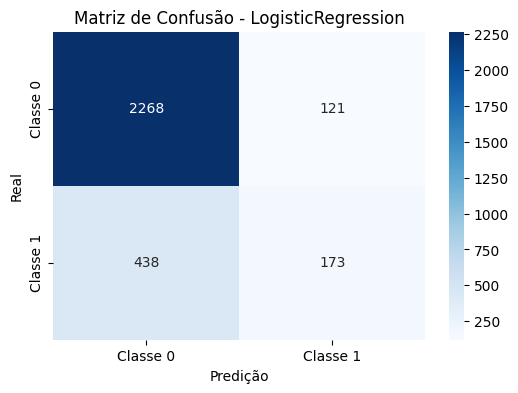


Relatório para LogisticRegression | Balanc: TomekLinks | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.84      0.95      0.89      2389
    Classe 1       0.59      0.28      0.38       611

    accuracy                           0.81      3000
   macro avg       0.71      0.62      0.64      3000
weighted avg       0.79      0.81      0.79      3000

Tempo: 1.1929s

==================== RandomForest ====================
Fitting 5 folds for each of 36 candidates, totalling 180 fits
✨ Novo Recorde! RandomForest com recall_1: 0.4501


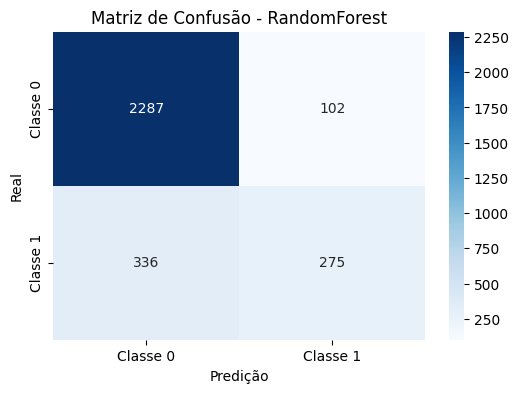


Relatório para RandomForest | Balanc: TomekLinks | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.87      0.96      0.91      2389
    Classe 1       0.73      0.45      0.56       611

    accuracy                           0.85      3000
   macro avg       0.80      0.70      0.73      3000
weighted avg       0.84      0.85      0.84      3000

Tempo: 311.0942s

==================== SVM ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✨ Novo Recorde! SVM com recall_1: 0.4926


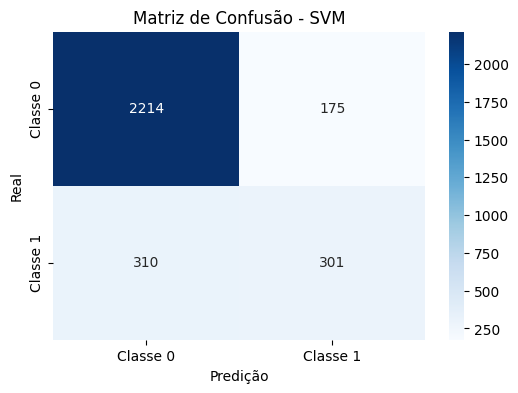


Relatório para SVM | Balanc: TomekLinks | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.88      0.93      0.90      2389
    Classe 1       0.63      0.49      0.55       611

    accuracy                           0.84      3000
   macro avg       0.75      0.71      0.73      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 69.0780s

==================== KNN ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


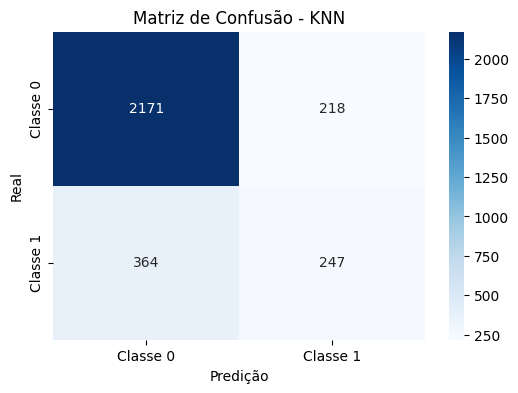


Relatório para KNN | Balanc: TomekLinks | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.86      0.91      0.88      2389
    Classe 1       0.53      0.40      0.46       611

    accuracy                           0.81      3000
   macro avg       0.69      0.66      0.67      3000
weighted avg       0.79      0.81      0.80      3000

Tempo: 5.5188s

==================== DecisionTree ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


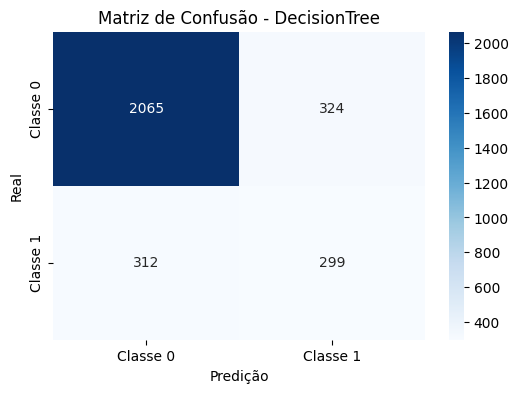


Relatório para DecisionTree | Balanc: TomekLinks | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.87      0.86      0.87      2389
    Classe 1       0.48      0.49      0.48       611

    accuracy                           0.79      3000
   macro avg       0.67      0.68      0.68      3000
weighted avg       0.79      0.79      0.79      3000

Tempo: 3.4827s

==================== NeuralNetwork ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


✨ Novo Recorde! NeuralNetwork com recall_1: 0.5450


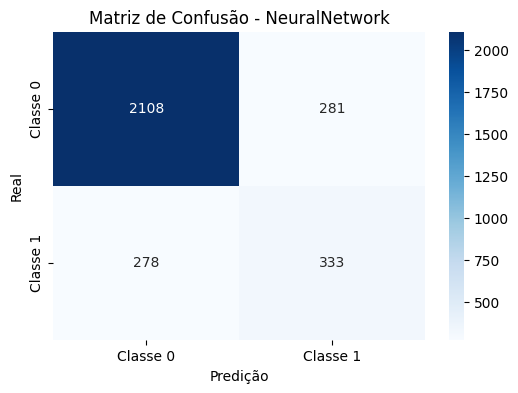


Relatório para NeuralNetwork | Balanc: TomekLinks | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.88      0.88      0.88      2389
    Classe 1       0.54      0.55      0.54       611

    accuracy                           0.81      3000
   macro avg       0.71      0.71      0.71      3000
weighted avg       0.81      0.81      0.81      3000

Tempo: 320.0672s

==================== XGBoost ====================
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


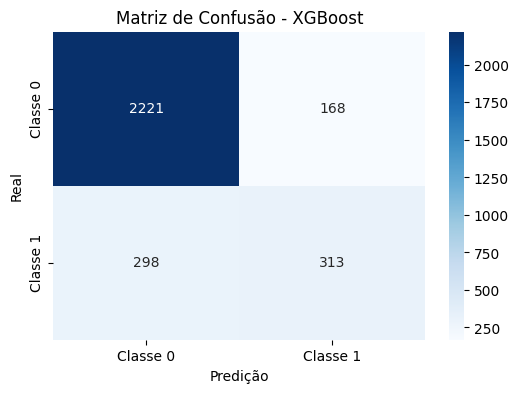


Relatório para XGBoost | Balanc: TomekLinks | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.88      0.93      0.91      2389
    Classe 1       0.65      0.51      0.57       611

    accuracy                           0.84      3000
   macro avg       0.77      0.72      0.74      3000
weighted avg       0.83      0.84      0.84      3000

Tempo: 332.3041s

==================== AdaBoost ====================
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_

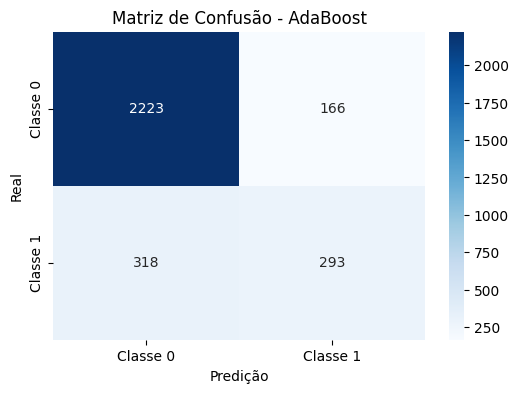


Relatório para AdaBoost | Balanc: TomekLinks | PCA: Não | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.87      0.93      0.90      2389
    Classe 1       0.64      0.48      0.55       611

    accuracy                           0.84      3000
   macro avg       0.76      0.71      0.72      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 31.1662s

🏆 Tabela de Resultados Final:


Modelo                                       Configuração  \
5       NeuralNetwork  NeuralNetwork | Balanc: TomekLinks | PCA: Não ...   
6             XGBoost  XGBoost | Balanc: TomekLinks | PCA: Não | Para...   
2                 SVM  SVM | Balanc: TomekLinks | PCA: Não | Params: ...   
4        DecisionTree  DecisionTree | Balanc: TomekLinks | PCA: Não |...   
7            AdaBoost  AdaBoost | Balanc: TomekLinks | PCA: Não | Par...   
1        RandomForest  RandomForest | Balanc: TomekLinks | PCA: Não |...   
3                 KNN  KNN | Balanc: TomekLinks | PCA: Não | Params: ...   
0  LogisticRegression  LogisticRegression | Balanc: TomekLinks | PCA:...   

   Score Otimização (recall_1)  Recall (Classe 1)  Acurácia   Tempo (s)  \
5                     0.545008           0.545008  0.813667  320.067217   
6                     0.512275           0.512275  0.844667  332.304076   
2                     0.492635           0.492635  0.838333   69.077967   
4                     0.489362           0.489362  0.788000    3.482681   
7                     0.479542           0.479542  0.838667   31.166235   
1                     0.450082           0.450082  0.854000  311.094226   
3                     0.404255           0.404255  0.806000    5.518821   
0                     0.283142           0.283142  0.813667    1.192869   

                                 Melhores Parâmetros  
5  {'activation': 'tanh', 'alpha': 0.001, 'hidden...  
6  {'colsample_bytree': 1.0, 'learning_rate': 0.2...  
2       {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}  
4  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...  
7  {'algorithm': 'SAMME', 'learning_rate': 1.0, '...  
1  {'max_depth': None, 'min_samples_leaf': 1, 'mi...  
3  {'metric': 'euclidean', 'n_neighbors': 3, 'wei...  
0  {'C': 10.0, 'max_iter': 500, 'solver': 'liblin...


💾 Melhor modelo salvo: NeuralNetwork (Score: 0.5450)

>>> 🧪 Testando Cenário: Grid + PCA + SMOTE
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✨ Novo Recorde! LogisticRegression com recall_1: 0.6498


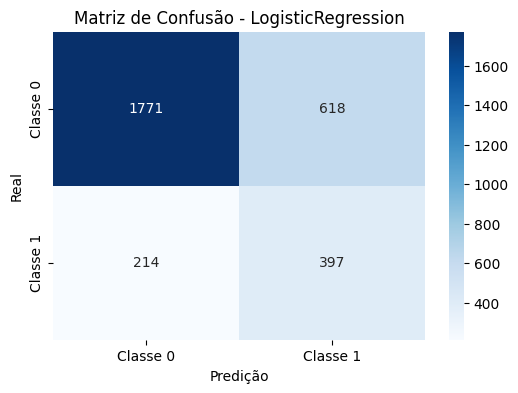


Relatório para LogisticRegression | Balanc: SMOTE | PCA: Sim | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.89      0.74      0.81      2389
    Classe 1       0.39      0.65      0.49       611

    accuracy                           0.72      3000
   macro avg       0.64      0.70      0.65      3000
weighted avg       0.79      0.72      0.74      3000

Tempo: 1.3312s

==================== RandomForest ====================
Fitting 5 folds for each of 36 candidates, totalling 180 fits


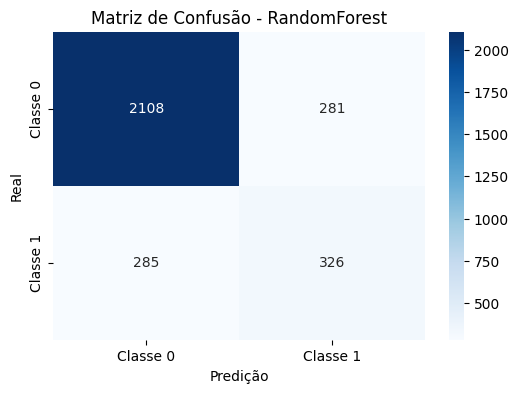


Relatório para RandomForest | Balanc: SMOTE | PCA: Sim | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.88      0.88      0.88      2389
    Classe 1       0.54      0.53      0.54       611

    accuracy                           0.81      3000
   macro avg       0.71      0.71      0.71      3000
weighted avg       0.81      0.81      0.81      3000

Tempo: 1124.8848s

==================== SVM ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


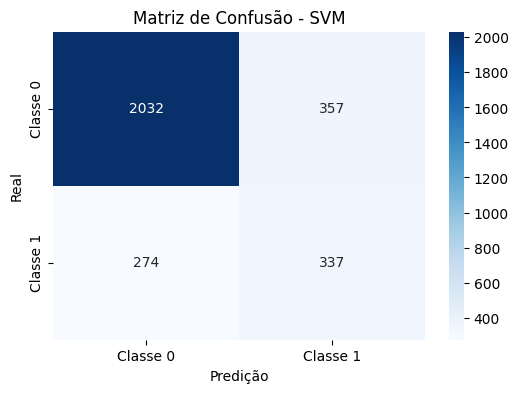


Relatório para SVM | Balanc: SMOTE | PCA: Sim | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.88      0.85      0.87      2389
    Classe 1       0.49      0.55      0.52       611

    accuracy                           0.79      3000
   macro avg       0.68      0.70      0.69      3000
weighted avg       0.80      0.79      0.79      3000

Tempo: 314.6460s

==================== KNN ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


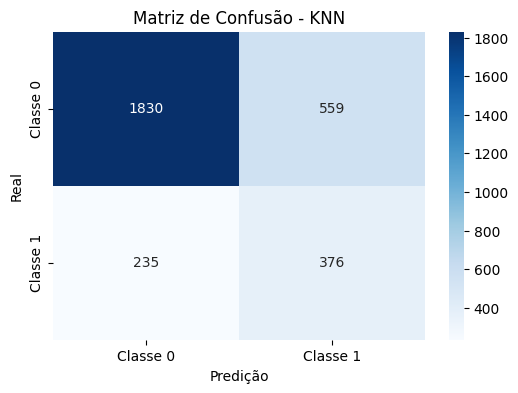


Relatório para KNN | Balanc: SMOTE | PCA: Sim | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.89      0.77      0.82      2389
    Classe 1       0.40      0.62      0.49       611

    accuracy                           0.74      3000
   macro avg       0.64      0.69      0.65      3000
weighted avg       0.79      0.74      0.75      3000

Tempo: 23.0825s

==================== DecisionTree ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


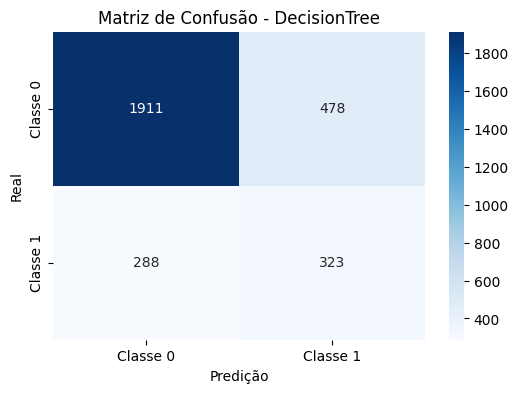


Relatório para DecisionTree | Balanc: SMOTE | PCA: Sim | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.87      0.80      0.83      2389
    Classe 1       0.40      0.53      0.46       611

    accuracy                           0.74      3000
   macro avg       0.64      0.66      0.65      3000
weighted avg       0.77      0.74      0.76      3000

Tempo: 11.9481s

==================== NeuralNetwork ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


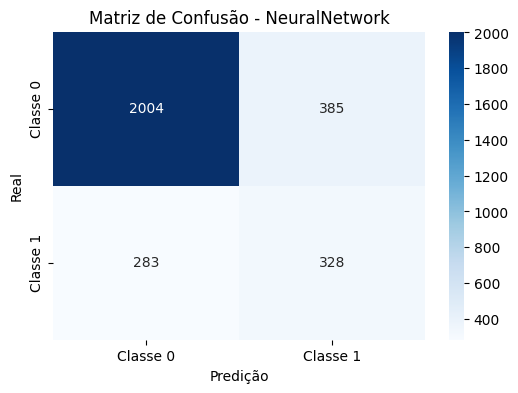


Relatório para NeuralNetwork | Balanc: SMOTE | PCA: Sim | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.88      0.84      0.86      2389
    Classe 1       0.46      0.54      0.50       611

    accuracy                           0.78      3000
   macro avg       0.67      0.69      0.68      3000
weighted avg       0.79      0.78      0.78      3000

Tempo: 522.9604s

==================== XGBoost ====================
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


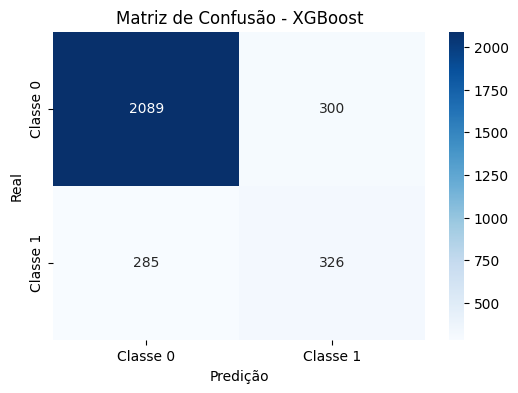


Relatório para XGBoost | Balanc: SMOTE | PCA: Sim | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.88      0.87      0.88      2389
    Classe 1       0.52      0.53      0.53       611

    accuracy                           0.81      3000
   macro avg       0.70      0.70      0.70      3000
weighted avg       0.81      0.81      0.81      3000

Tempo: 761.0956s

==================== AdaBoost ====================
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_

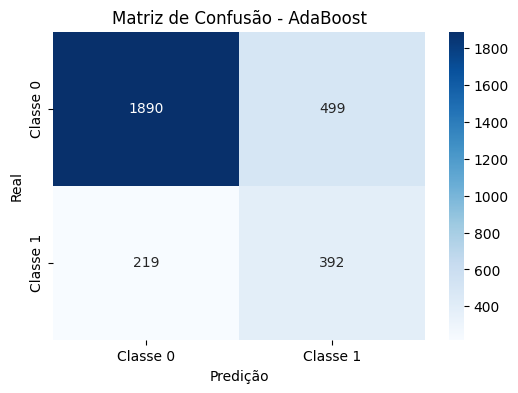


Relatório para AdaBoost | Balanc: SMOTE | PCA: Sim | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.90      0.79      0.84      2389
    Classe 1       0.44      0.64      0.52       611

    accuracy                           0.76      3000
   macro avg       0.67      0.72      0.68      3000
weighted avg       0.80      0.76      0.78      3000

Tempo: 129.2567s

🏆 Tabela de Resultados Final:


Modelo                                       Configuração  \
0  LogisticRegression  LogisticRegression | Balanc: SMOTE | PCA: Sim ...   
7            AdaBoost  AdaBoost | Balanc: SMOTE | PCA: Sim | Params: ...   
3                 KNN      KNN | Balanc: SMOTE | PCA: Sim | Params: grid   
2                 SVM      SVM | Balanc: SMOTE | PCA: Sim | Params: grid   
5       NeuralNetwork  NeuralNetwork | Balanc: SMOTE | PCA: Sim | Par...   
1        RandomForest  RandomForest | Balanc: SMOTE | PCA: Sim | Para...   
6             XGBoost  XGBoost | Balanc: SMOTE | PCA: Sim | Params: grid   
4        DecisionTree  DecisionTree | Balanc: SMOTE | PCA: Sim | Para...   

   Score Otimização (recall_1)  Recall (Classe 1)  Acurácia    Tempo (s)  \
0                     0.649755           0.649755  0.722667     1.331189   
7                     0.641571           0.641571  0.760667   129.256670   
3                     0.615385           0.615385  0.735333    23.082547   
2                     0.551555           0.551555  0.789667   314.646046   
5                     0.536825           0.536825  0.777333   522.960374   
1                     0.533552           0.533552  0.811333  1124.884835   
6                     0.533552           0.533552  0.805000   761.095633   
4                     0.528642           0.528642  0.744667    11.948112   

                                 Melhores Parâmetros  
0     {'C': 0.1, 'max_iter': 500, 'solver': 'lbfgs'}  
7  {'algorithm': 'SAMME', 'learning_rate': 1.0, '...  
3  {'metric': 'euclidean', 'n_neighbors': 3, 'wei...  
2       {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}  
5  {'activation': 'tanh', 'alpha': 0.001, 'hidden...  
1  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...  
6  {'colsample_bytree': 0.8, 'learning_rate': 0.2...  
4  {'max_depth': None, 'min_samples_leaf': 1, 'mi...


💾 Melhor modelo salvo: LogisticRegression (Score: 0.6498)

>>> 🧪 Testando Cenário: Grid + PCA + Tomek
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✨ Novo Recorde! LogisticRegression com recall_1: 0.2717


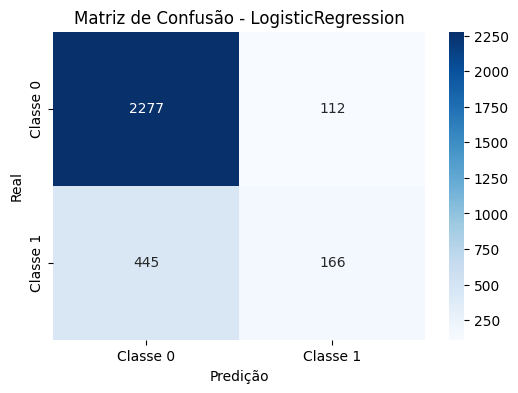


Relatório para LogisticRegression | Balanc: TomekLinks | PCA: Sim | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.84      0.95      0.89      2389
    Classe 1       0.60      0.27      0.37       611

    accuracy                           0.81      3000
   macro avg       0.72      0.61      0.63      3000
weighted avg       0.79      0.81      0.79      3000

Tempo: 0.7076s

==================== RandomForest ====================
Fitting 5 folds for each of 36 candidates, totalling 180 fits
✨ Novo Recorde! RandomForest com recall_1: 0.4108


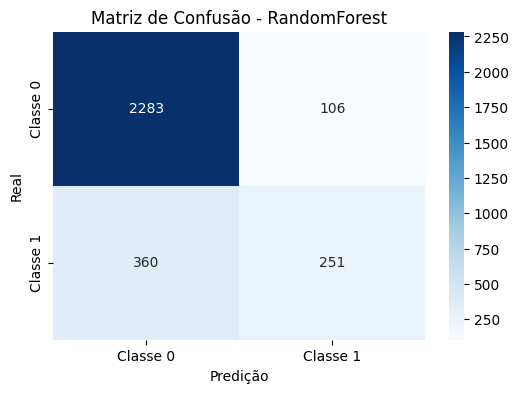


Relatório para RandomForest | Balanc: TomekLinks | PCA: Sim | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.86      0.96      0.91      2389
    Classe 1       0.70      0.41      0.52       611

    accuracy                           0.84      3000
   macro avg       0.78      0.68      0.71      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 734.2859s

==================== SVM ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✨ Novo Recorde! SVM com recall_1: 0.4632


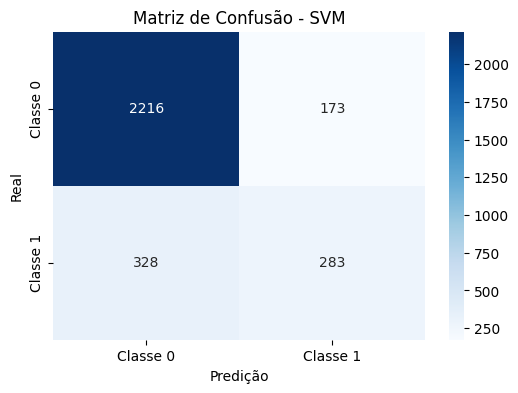


Relatório para SVM | Balanc: TomekLinks | PCA: Sim | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.87      0.93      0.90      2389
    Classe 1       0.62      0.46      0.53       611

    accuracy                           0.83      3000
   macro avg       0.75      0.70      0.71      3000
weighted avg       0.82      0.83      0.82      3000

Tempo: 68.0865s

==================== KNN ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


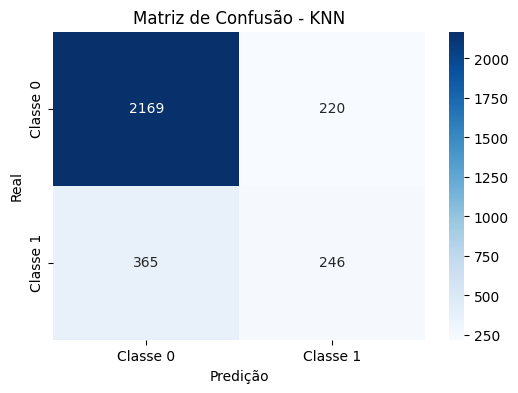


Relatório para KNN | Balanc: TomekLinks | PCA: Sim | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.86      0.91      0.88      2389
    Classe 1       0.53      0.40      0.46       611

    accuracy                           0.81      3000
   macro avg       0.69      0.66      0.67      3000
weighted avg       0.79      0.81      0.79      3000

Tempo: 12.2749s

==================== DecisionTree ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✨ Novo Recorde! DecisionTree com recall_1: 0.5188


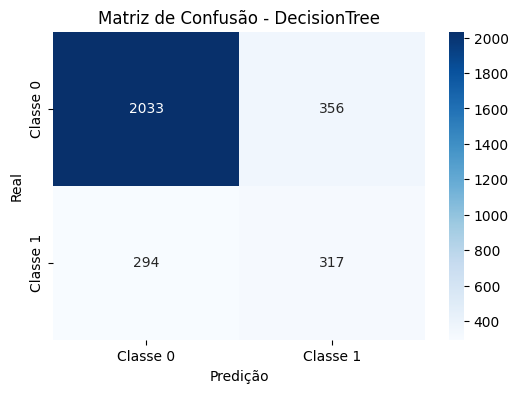


Relatório para DecisionTree | Balanc: TomekLinks | PCA: Sim | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.87      0.85      0.86      2389
    Classe 1       0.47      0.52      0.49       611

    accuracy                           0.78      3000
   macro avg       0.67      0.68      0.68      3000
weighted avg       0.79      0.78      0.79      3000

Tempo: 7.3033s

==================== NeuralNetwork ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


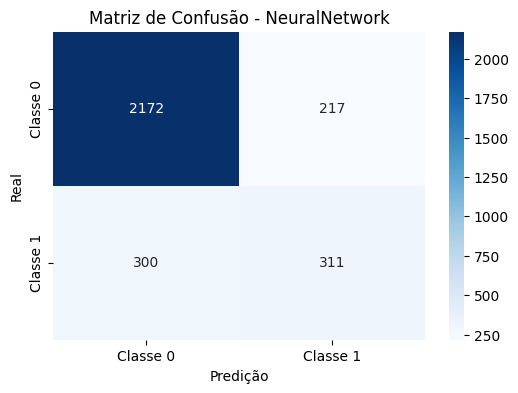


Relatório para NeuralNetwork | Balanc: TomekLinks | PCA: Sim | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.88      0.91      0.89      2389
    Classe 1       0.59      0.51      0.55       611

    accuracy                           0.83      3000
   macro avg       0.73      0.71      0.72      3000
weighted avg       0.82      0.83      0.82      3000

Tempo: 322.3913s

==================== XGBoost ====================
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


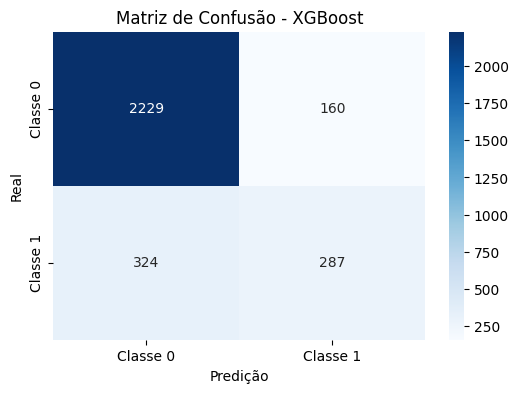


Relatório para XGBoost | Balanc: TomekLinks | PCA: Sim | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.87      0.93      0.90      2389
    Classe 1       0.64      0.47      0.54       611

    accuracy                           0.84      3000
   macro avg       0.76      0.70      0.72      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 579.2709s

==================== AdaBoost ====================
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_

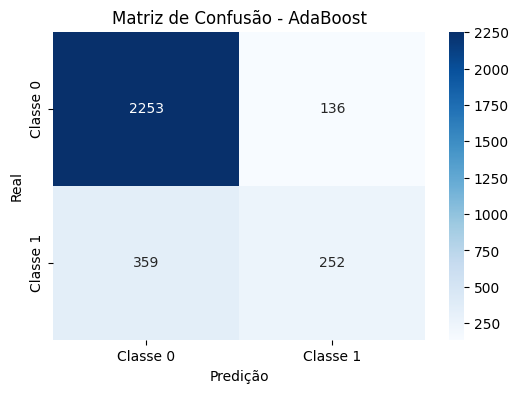


Relatório para AdaBoost | Balanc: TomekLinks | PCA: Sim | Params: grid:
              precision    recall  f1-score   support

    Classe 0       0.86      0.94      0.90      2389
    Classe 1       0.65      0.41      0.50       611

    accuracy                           0.83      3000
   macro avg       0.76      0.68      0.70      3000
weighted avg       0.82      0.83      0.82      3000

Tempo: 85.8789s

🏆 Tabela de Resultados Final:


Modelo                                       Configuração  \
4        DecisionTree  DecisionTree | Balanc: TomekLinks | PCA: Sim |...   
5       NeuralNetwork  NeuralNetwork | Balanc: TomekLinks | PCA: Sim ...   
6             XGBoost  XGBoost | Balanc: TomekLinks | PCA: Sim | Para...   
2                 SVM  SVM | Balanc: TomekLinks | PCA: Sim | Params: ...   
7            AdaBoost  AdaBoost | Balanc: TomekLinks | PCA: Sim | Par...   
1        RandomForest  RandomForest | Balanc: TomekLinks | PCA: Sim |...   
3                 KNN  KNN | Balanc: TomekLinks | PCA: Sim | Params: ...   
0  LogisticRegression  LogisticRegression | Balanc: TomekLinks | PCA:...   

   Score Otimização (recall_1)  Recall (Classe 1)  Acurácia   Tempo (s)  \
4                     0.518822           0.518822  0.783333    7.303290   
5                     0.509002           0.509002  0.827667  322.391322   
6                     0.469722           0.469722  0.838667  579.270850   
2                     0.463175           0.463175  0.833000   68.086469   
7                     0.412439           0.412439  0.835000   85.878891   
1                     0.410802           0.410802  0.844667  734.285912   
3                     0.402619           0.402619  0.805000   12.274885   
0                     0.271686           0.271686  0.814333    0.707644   

                                 Melhores Parâmetros  
4  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...  
5  {'activation': 'tanh', 'alpha': 0.001, 'hidden...  
6  {'colsample_bytree': 0.8, 'learning_rate': 0.2...  
2       {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}  
7  {'algorithm': 'SAMME', 'learning_rate': 1.0, '...  
1  {'max_depth': None, 'min_samples_leaf': 1, 'mi...  
3  {'metric': 'euclidean', 'n_neighbors': 3, 'wei...  
0    {'C': 10.0, 'max_iter': 500, 'solver': 'lbfgs'}


💾 Melhor modelo salvo: DecisionTree (Score: 0.5188)

>>> 🧪 Testando Cenário: Best
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
⚠️ Aviso: Sem parâmetros definidos para LogisticRegression. Usando default.
✨ Novo Recorde! LogisticRegression com recall_1: 0.2439


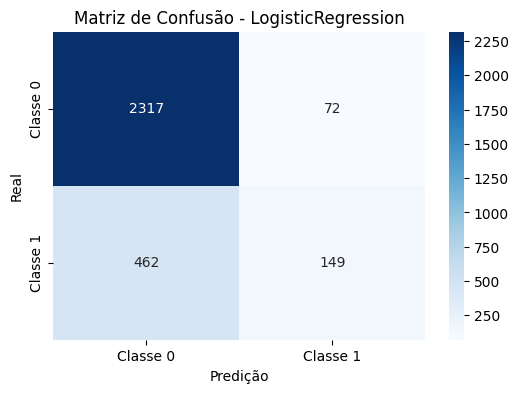


Relatório para LogisticRegression | Balanc: None | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.83      0.97      0.90      2389
    Classe 1       0.67      0.24      0.36       611

    accuracy                           0.82      3000
   macro avg       0.75      0.61      0.63      3000
weighted avg       0.80      0.82      0.79      3000

Tempo: 0.0716s

==================== RandomForest ====================
⚠️ Aviso: Sem parâmetros definidos para RandomForest. Usando default.
✨ Novo Recorde! RandomForest com recall_1: 0.4304


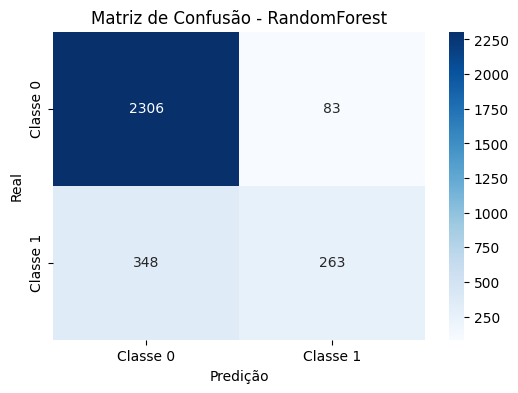


Relatório para RandomForest | Balanc: None | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.87      0.97      0.91      2389
    Classe 1       0.76      0.43      0.55       611

    accuracy                           0.86      3000
   macro avg       0.81      0.70      0.73      3000
weighted avg       0.85      0.86      0.84      3000

Tempo: 1.5698s

==================== SVM ====================
⚠️ Aviso: Sem parâmetros definidos para SVM. Usando default.


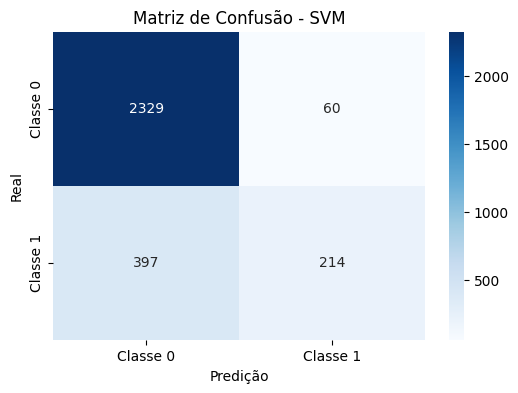


Relatório para SVM | Balanc: None | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.85      0.97      0.91      2389
    Classe 1       0.78      0.35      0.48       611

    accuracy                           0.85      3000
   macro avg       0.82      0.66      0.70      3000
weighted avg       0.84      0.85      0.82      3000

Tempo: 1.2450s

==================== KNN ====================
⚠️ Aviso: Sem parâmetros definidos para KNN. Usando default.


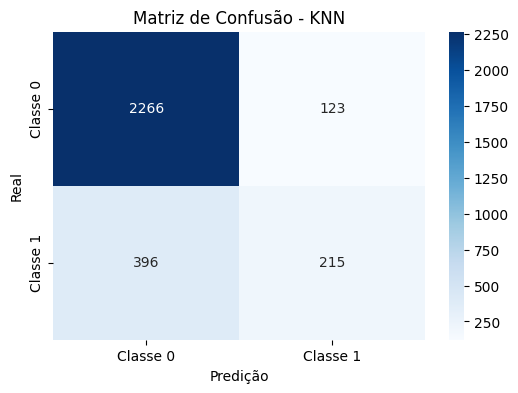


Relatório para KNN | Balanc: None | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.85      0.95      0.90      2389
    Classe 1       0.64      0.35      0.45       611

    accuracy                           0.83      3000
   macro avg       0.74      0.65      0.68      3000
weighted avg       0.81      0.83      0.81      3000

Tempo: 0.0052s

==================== DecisionTree ====================
⚠️ Aviso: Sem parâmetros definidos para DecisionTree. Usando default.
✨ Novo Recorde! DecisionTree com recall_1: 0.4828


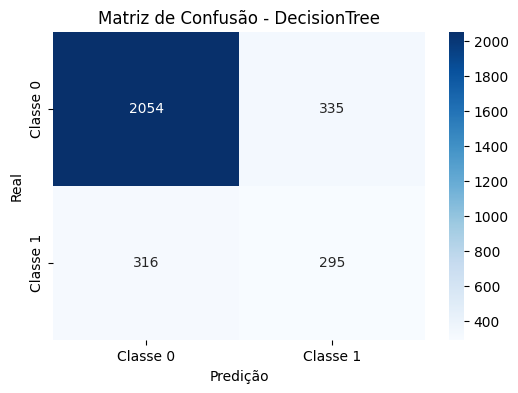


Relatório para DecisionTree | Balanc: None | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.87      0.86      0.86      2389
    Classe 1       0.47      0.48      0.48       611

    accuracy                           0.78      3000
   macro avg       0.67      0.67      0.67      3000
weighted avg       0.79      0.78      0.78      3000

Tempo: 0.0791s

==================== NeuralNetwork ====================
⚠️ Aviso: Sem parâmetros definidos para NeuralNetwork. Usando default.


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


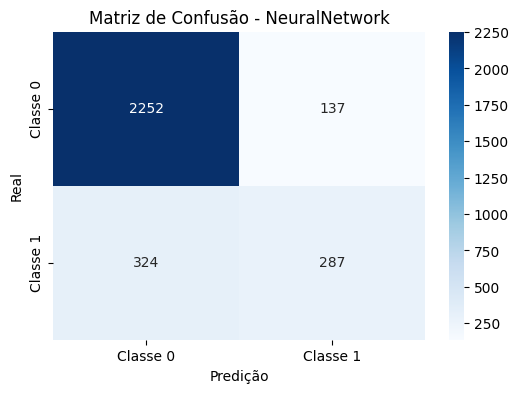


Relatório para NeuralNetwork | Balanc: None | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.91      2389
    Classe 1       0.68      0.47      0.55       611

    accuracy                           0.85      3000
   macro avg       0.78      0.71      0.73      3000
weighted avg       0.83      0.85      0.84      3000

Tempo: 6.0626s

==================== XGBoost ====================
⚠️ Aviso: Sem parâmetros definidos para XGBoost. Usando default.


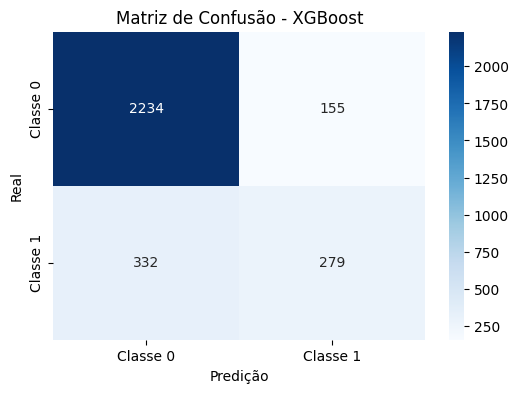


Relatório para XGBoost | Balanc: None | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.90      2389
    Classe 1       0.64      0.46      0.53       611

    accuracy                           0.84      3000
   macro avg       0.76      0.70      0.72      3000
weighted avg       0.82      0.84      0.83      3000

Tempo: 0.3122s

==================== AdaBoost ====================
⚠️ Aviso: Sem parâmetros definidos para AdaBoost. Usando default.


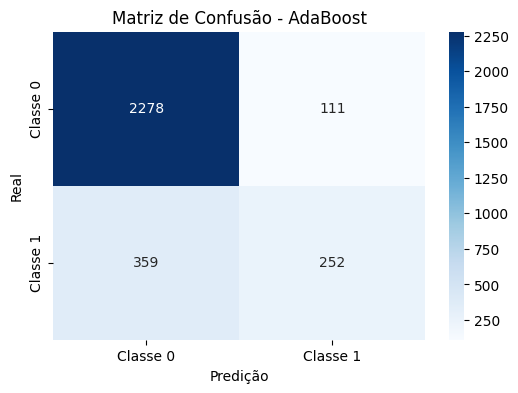


Relatório para AdaBoost | Balanc: None | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.86      0.95      0.91      2389
    Classe 1       0.69      0.41      0.52       611

    accuracy                           0.84      3000
   macro avg       0.78      0.68      0.71      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 0.4603s

🏆 Tabela de Resultados Final:


Modelo                                       Configuração  \
4        DecisionTree  DecisionTree | Balanc: None | PCA: Não | Param...   
5       NeuralNetwork  NeuralNetwork | Balanc: None | PCA: Não | Para...   
6             XGBoost   XGBoost | Balanc: None | PCA: Não | Params: best   
1        RandomForest  RandomForest | Balanc: None | PCA: Não | Param...   
7            AdaBoost  AdaBoost | Balanc: None | PCA: Não | Params: best   
3                 KNN       KNN | Balanc: None | PCA: Não | Params: best   
2                 SVM       SVM | Balanc: None | PCA: Não | Params: best   
0  LogisticRegression  LogisticRegression | Balanc: None | PCA: Não |...   

   Score Otimização (recall_1)  Recall (Classe 1)  Acurácia  Tempo (s)  \
4                     0.482815           0.482815  0.783000   0.079057   
5                     0.469722           0.469722  0.846333   6.062617   
6                     0.456628           0.456628  0.837667   0.312210   
1                     0.430442           0.430442  0.856333   1.569761   
7                     0.412439           0.412439  0.843333   0.460304   
3                     0.351882           0.351882  0.827000   0.005189   
2                     0.350245           0.350245  0.847667   1.245025   
0                     0.243863           0.243863  0.822000   0.071620   

  Melhores Parâmetros  
4                 N/A  
5                 N/A  
6                 N/A  
1                 N/A  
7                 N/A  
3                 N/A  
2                 N/A  
0                 N/A


💾 Melhor modelo salvo: DecisionTree (Score: 0.4828)

>>> 🧪 Testando Cenário: Best + SMOTE
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
⚠️ Aviso: Sem parâmetros definidos para LogisticRegression. Usando default.
✨ Novo Recorde! LogisticRegression com recall_1: 0.6236


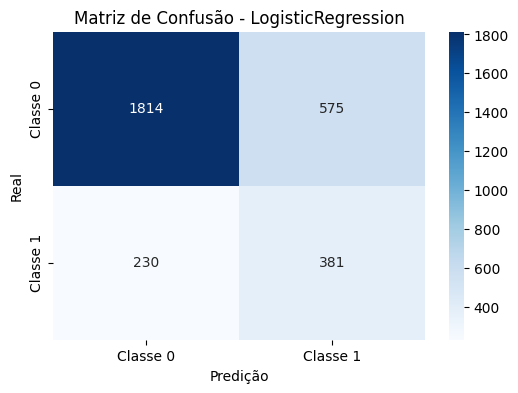


Relatório para LogisticRegression | Balanc: SMOTE | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.89      0.76      0.82      2389
    Classe 1       0.40      0.62      0.49       611

    accuracy                           0.73      3000
   macro avg       0.64      0.69      0.65      3000
weighted avg       0.79      0.73      0.75      3000

Tempo: 0.0734s

==================== RandomForest ====================
⚠️ Aviso: Sem parâmetros definidos para RandomForest. Usando default.


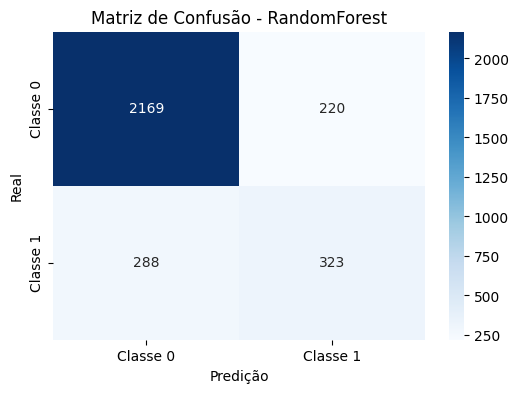


Relatório para RandomForest | Balanc: SMOTE | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.88      0.91      0.90      2389
    Classe 1       0.59      0.53      0.56       611

    accuracy                           0.83      3000
   macro avg       0.74      0.72      0.73      3000
weighted avg       0.82      0.83      0.83      3000

Tempo: 2.6811s

==================== SVM ====================
⚠️ Aviso: Sem parâmetros definidos para SVM. Usando default.


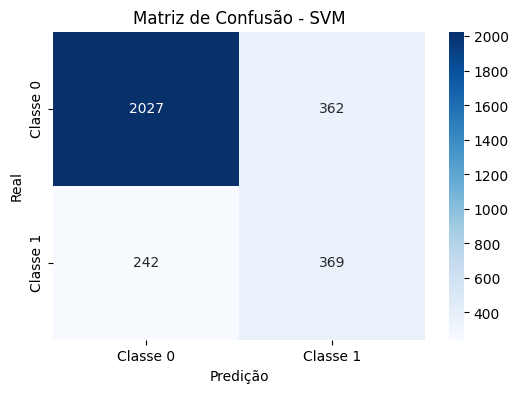


Relatório para SVM | Balanc: SMOTE | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.89      0.85      0.87      2389
    Classe 1       0.50      0.60      0.55       611

    accuracy                           0.80      3000
   macro avg       0.70      0.73      0.71      3000
weighted avg       0.81      0.80      0.81      3000

Tempo: 3.7925s

==================== KNN ====================
⚠️ Aviso: Sem parâmetros definidos para KNN. Usando default.
✨ Novo Recorde! KNN com recall_1: 0.6481


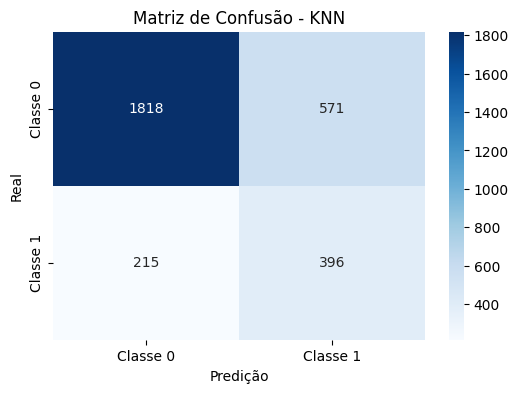


Relatório para KNN | Balanc: SMOTE | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.89      0.76      0.82      2389
    Classe 1       0.41      0.65      0.50       611

    accuracy                           0.74      3000
   macro avg       0.65      0.70      0.66      3000
weighted avg       0.80      0.74      0.76      3000

Tempo: 0.0043s

==================== DecisionTree ====================
⚠️ Aviso: Sem parâmetros definidos para DecisionTree. Usando default.


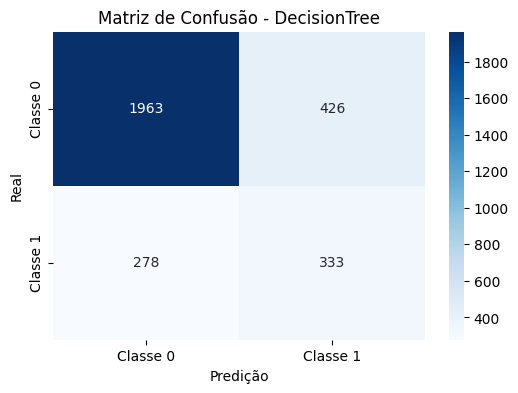


Relatório para DecisionTree | Balanc: SMOTE | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.88      0.82      0.85      2389
    Classe 1       0.44      0.55      0.49       611

    accuracy                           0.77      3000
   macro avg       0.66      0.68      0.67      3000
weighted avg       0.79      0.77      0.77      3000

Tempo: 0.1846s

==================== NeuralNetwork ====================
⚠️ Aviso: Sem parâmetros definidos para NeuralNetwork. Usando default.


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


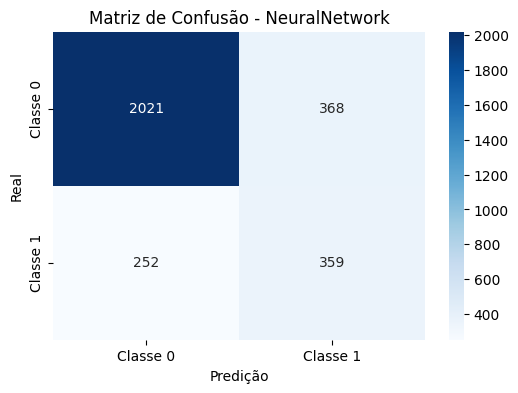


Relatório para NeuralNetwork | Balanc: SMOTE | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.89      0.85      0.87      2389
    Classe 1       0.49      0.59      0.54       611

    accuracy                           0.79      3000
   macro avg       0.69      0.72      0.70      3000
weighted avg       0.81      0.79      0.80      3000

Tempo: 8.5051s

==================== XGBoost ====================
⚠️ Aviso: Sem parâmetros definidos para XGBoost. Usando default.


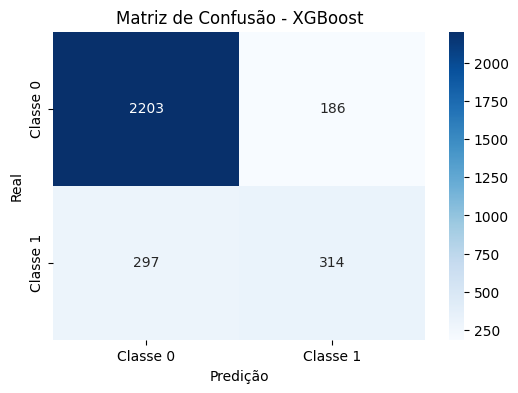


Relatório para XGBoost | Balanc: SMOTE | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.88      0.92      0.90      2389
    Classe 1       0.63      0.51      0.57       611

    accuracy                           0.84      3000
   macro avg       0.75      0.72      0.73      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 0.3928s

==================== AdaBoost ====================
⚠️ Aviso: Sem parâmetros definidos para AdaBoost. Usando default.


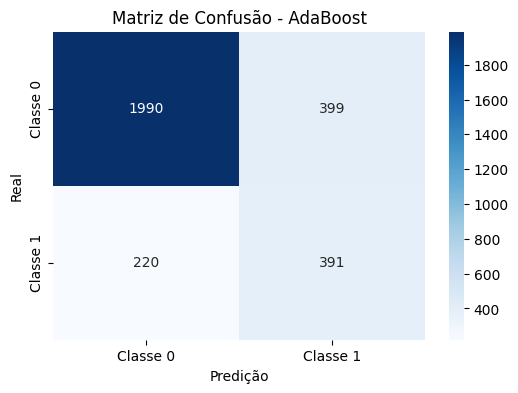


Relatório para AdaBoost | Balanc: SMOTE | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.90      0.83      0.87      2389
    Classe 1       0.49      0.64      0.56       611

    accuracy                           0.79      3000
   macro avg       0.70      0.74      0.71      3000
weighted avg       0.82      0.79      0.80      3000

Tempo: 0.7658s

🏆 Tabela de Resultados Final:


Modelo                                       Configuração  \
3                 KNN      KNN | Balanc: SMOTE | PCA: Não | Params: best   
7            AdaBoost  AdaBoost | Balanc: SMOTE | PCA: Não | Params: ...   
0  LogisticRegression  LogisticRegression | Balanc: SMOTE | PCA: Não ...   
2                 SVM      SVM | Balanc: SMOTE | PCA: Não | Params: best   
5       NeuralNetwork  NeuralNetwork | Balanc: SMOTE | PCA: Não | Par...   
4        DecisionTree  DecisionTree | Balanc: SMOTE | PCA: Não | Para...   
1        RandomForest  RandomForest | Balanc: SMOTE | PCA: Não | Para...   
6             XGBoost  XGBoost | Balanc: SMOTE | PCA: Não | Params: best   

   Score Otimização (recall_1)  Recall (Classe 1)  Acurácia  Tempo (s)  \
3                     0.648118           0.648118  0.738000   0.004284   
7                     0.639935           0.639935  0.793667   0.765840   
0                     0.623568           0.623568  0.731667   0.073369   
2                     0.603928           0.603928  0.798667   3.792475   
5                     0.587561           0.587561  0.793333   8.505124   
4                     0.545008           0.545008  0.765333   0.184625   
1                     0.528642           0.528642  0.830667   2.681096   
6                     0.513912           0.513912  0.839000   0.392846   

  Melhores Parâmetros  
3                 N/A  
7                 N/A  
0                 N/A  
2                 N/A  
5                 N/A  
4                 N/A  
1                 N/A  
6                 N/A


💾 Melhor modelo salvo: KNN (Score: 0.6481)

>>> 🧪 Testando Cenário: Best + Tomek
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
⚠️ Aviso: Sem parâmetros definidos para LogisticRegression. Usando default.
✨ Novo Recorde! LogisticRegression com recall_1: 0.2831


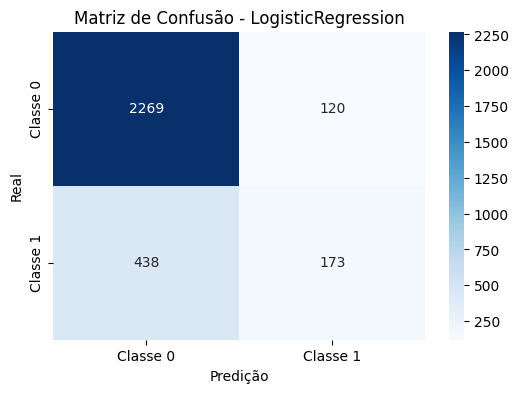


Relatório para LogisticRegression | Balanc: TomekLinks | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.84      0.95      0.89      2389
    Classe 1       0.59      0.28      0.38       611

    accuracy                           0.81      3000
   macro avg       0.71      0.62      0.64      3000
weighted avg       0.79      0.81      0.79      3000

Tempo: 0.0155s

==================== RandomForest ====================
⚠️ Aviso: Sem parâmetros definidos para RandomForest. Usando default.
✨ Novo Recorde! RandomForest com recall_1: 0.4435


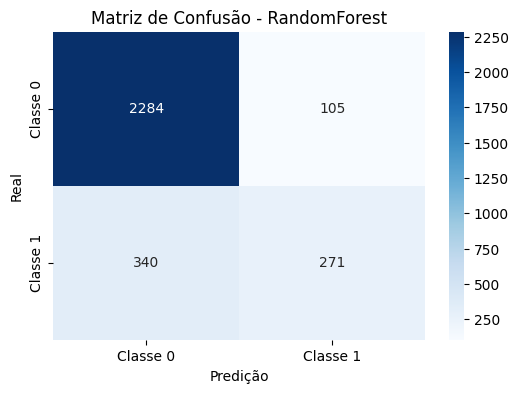


Relatório para RandomForest | Balanc: TomekLinks | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.87      0.96      0.91      2389
    Classe 1       0.72      0.44      0.55       611

    accuracy                           0.85      3000
   macro avg       0.80      0.70      0.73      3000
weighted avg       0.84      0.85      0.84      3000

Tempo: 1.9209s

==================== SVM ====================
⚠️ Aviso: Sem parâmetros definidos para SVM. Usando default.


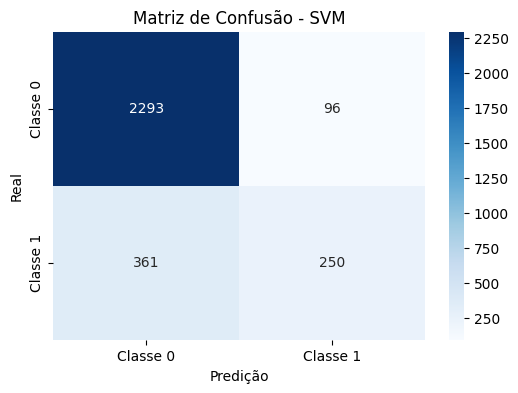


Relatório para SVM | Balanc: TomekLinks | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.86      0.96      0.91      2389
    Classe 1       0.72      0.41      0.52       611

    accuracy                           0.85      3000
   macro avg       0.79      0.68      0.72      3000
weighted avg       0.84      0.85      0.83      3000

Tempo: 1.4269s

==================== KNN ====================
⚠️ Aviso: Sem parâmetros definidos para KNN. Usando default.


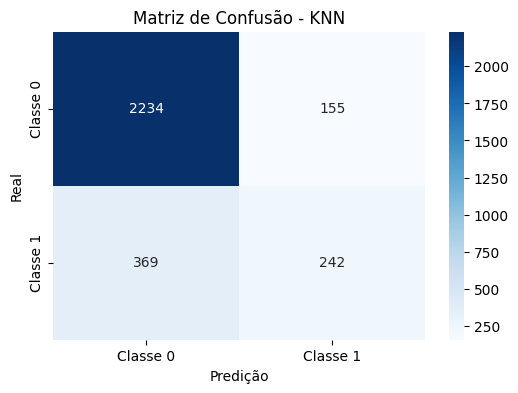


Relatório para KNN | Balanc: TomekLinks | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.86      0.94      0.90      2389
    Classe 1       0.61      0.40      0.48       611

    accuracy                           0.83      3000
   macro avg       0.73      0.67      0.69      3000
weighted avg       0.81      0.83      0.81      3000

Tempo: 0.0038s

==================== DecisionTree ====================
⚠️ Aviso: Sem parâmetros definidos para DecisionTree. Usando default.
✨ Novo Recorde! DecisionTree com recall_1: 0.5221


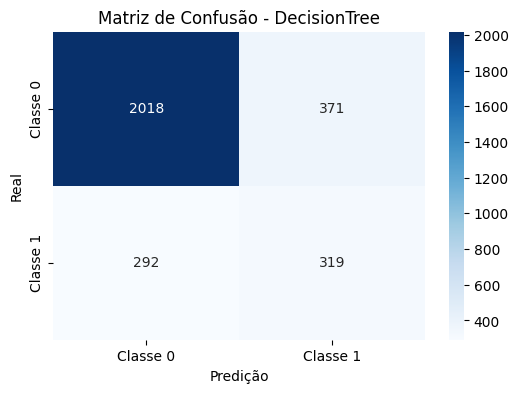


Relatório para DecisionTree | Balanc: TomekLinks | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.87      0.84      0.86      2389
    Classe 1       0.46      0.52      0.49       611

    accuracy                           0.78      3000
   macro avg       0.67      0.68      0.67      3000
weighted avg       0.79      0.78      0.78      3000

Tempo: 0.0912s

==================== NeuralNetwork ====================
⚠️ Aviso: Sem parâmetros definidos para NeuralNetwork. Usando default.


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


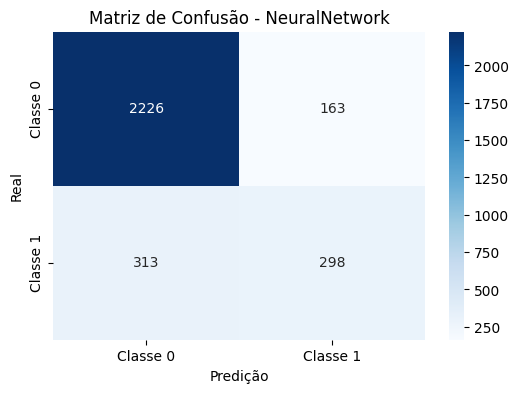


Relatório para NeuralNetwork | Balanc: TomekLinks | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.88      0.93      0.90      2389
    Classe 1       0.65      0.49      0.56       611

    accuracy                           0.84      3000
   macro avg       0.76      0.71      0.73      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 4.7829s

==================== XGBoost ====================
⚠️ Aviso: Sem parâmetros definidos para XGBoost. Usando default.


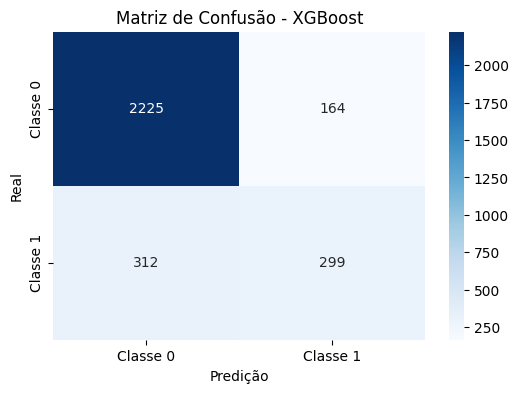


Relatório para XGBoost | Balanc: TomekLinks | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.88      0.93      0.90      2389
    Classe 1       0.65      0.49      0.56       611

    accuracy                           0.84      3000
   macro avg       0.76      0.71      0.73      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 0.3374s

==================== AdaBoost ====================
⚠️ Aviso: Sem parâmetros definidos para AdaBoost. Usando default.


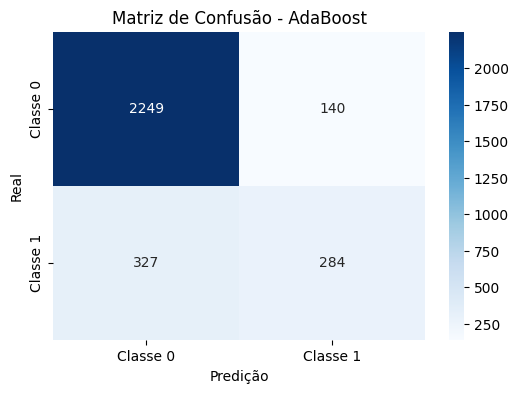


Relatório para AdaBoost | Balanc: TomekLinks | PCA: Não | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.91      2389
    Classe 1       0.67      0.46      0.55       611

    accuracy                           0.84      3000
   macro avg       0.77      0.70      0.73      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 0.4536s

🏆 Tabela de Resultados Final:


Modelo                                       Configuração  \
4        DecisionTree  DecisionTree | Balanc: TomekLinks | PCA: Não |...   
6             XGBoost  XGBoost | Balanc: TomekLinks | PCA: Não | Para...   
5       NeuralNetwork  NeuralNetwork | Balanc: TomekLinks | PCA: Não ...   
7            AdaBoost  AdaBoost | Balanc: TomekLinks | PCA: Não | Par...   
1        RandomForest  RandomForest | Balanc: TomekLinks | PCA: Não |...   
2                 SVM  SVM | Balanc: TomekLinks | PCA: Não | Params: ...   
3                 KNN  KNN | Balanc: TomekLinks | PCA: Não | Params: ...   
0  LogisticRegression  LogisticRegression | Balanc: TomekLinks | PCA:...   

   Score Otimização (recall_1)  Recall (Classe 1)  Acurácia  Tempo (s)  \
4                     0.522095           0.522095  0.779000   0.091163   
6                     0.489362           0.489362  0.841333   0.337393   
5                     0.487725           0.487725  0.841333   4.782852   
7                     0.464812           0.464812  0.844333   0.453628   
1                     0.443535           0.443535  0.851667   1.920920   
2                     0.409165           0.409165  0.847667   1.426881   
3                     0.396072           0.396072  0.825333   0.003844   
0                     0.283142           0.283142  0.814000   0.015530   

  Melhores Parâmetros  
4                 N/A  
6                 N/A  
5                 N/A  
7                 N/A  
1                 N/A  
2                 N/A  
3                 N/A  
0                 N/A


💾 Melhor modelo salvo: DecisionTree (Score: 0.5221)

>>> 🧪 Testando Cenário: Best + PCA + SMOTE
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
⚠️ Aviso: Sem parâmetros definidos para LogisticRegression. Usando default.
✨ Novo Recorde! LogisticRegression com recall_1: 0.6498


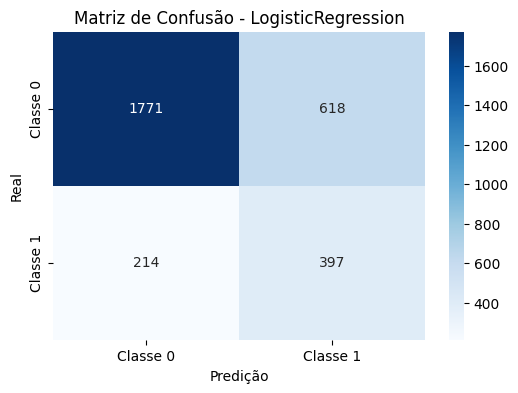


Relatório para LogisticRegression | Balanc: SMOTE | PCA: Sim | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.89      0.74      0.81      2389
    Classe 1       0.39      0.65      0.49       611

    accuracy                           0.72      3000
   macro avg       0.64      0.70      0.65      3000
weighted avg       0.79      0.72      0.74      3000

Tempo: 0.0303s

==================== RandomForest ====================
⚠️ Aviso: Sem parâmetros definidos para RandomForest. Usando default.


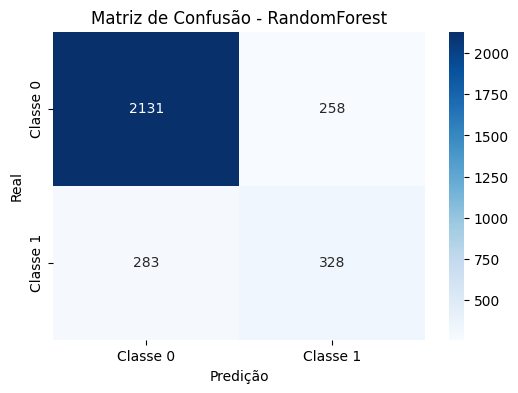


Relatório para RandomForest | Balanc: SMOTE | PCA: Sim | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.88      0.89      0.89      2389
    Classe 1       0.56      0.54      0.55       611

    accuracy                           0.82      3000
   macro avg       0.72      0.71      0.72      3000
weighted avg       0.82      0.82      0.82      3000

Tempo: 6.2581s

==================== SVM ====================
⚠️ Aviso: Sem parâmetros definidos para SVM. Usando default.


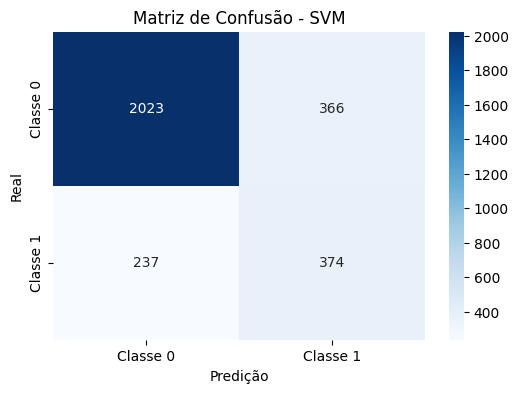


Relatório para SVM | Balanc: SMOTE | PCA: Sim | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.90      0.85      0.87      2389
    Classe 1       0.51      0.61      0.55       611

    accuracy                           0.80      3000
   macro avg       0.70      0.73      0.71      3000
weighted avg       0.82      0.80      0.81      3000

Tempo: 4.0924s

==================== KNN ====================
⚠️ Aviso: Sem parâmetros definidos para KNN. Usando default.


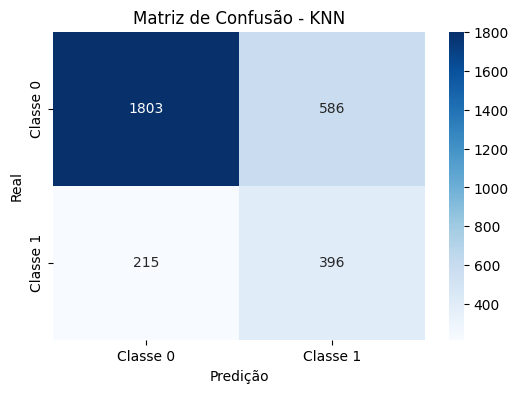


Relatório para KNN | Balanc: SMOTE | PCA: Sim | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.89      0.75      0.82      2389
    Classe 1       0.40      0.65      0.50       611

    accuracy                           0.73      3000
   macro avg       0.65      0.70      0.66      3000
weighted avg       0.79      0.73      0.75      3000

Tempo: 0.0368s

==================== DecisionTree ====================
⚠️ Aviso: Sem parâmetros definidos para DecisionTree. Usando default.


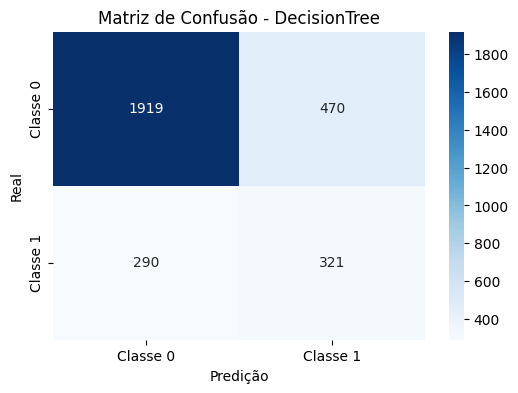


Relatório para DecisionTree | Balanc: SMOTE | PCA: Sim | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.87      0.80      0.83      2389
    Classe 1       0.41      0.53      0.46       611

    accuracy                           0.75      3000
   macro avg       0.64      0.66      0.65      3000
weighted avg       0.77      0.75      0.76      3000

Tempo: 0.3798s

==================== NeuralNetwork ====================
⚠️ Aviso: Sem parâmetros definidos para NeuralNetwork. Usando default.


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


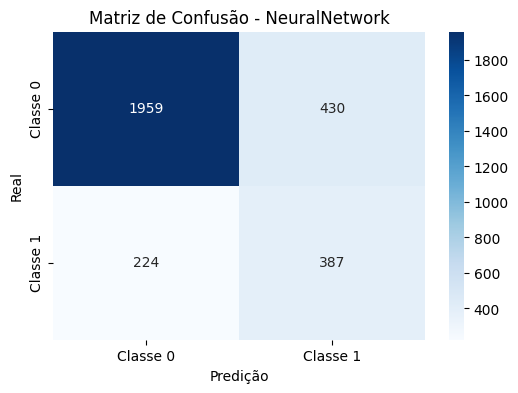


Relatório para NeuralNetwork | Balanc: SMOTE | PCA: Sim | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.90      0.82      0.86      2389
    Classe 1       0.47      0.63      0.54       611

    accuracy                           0.78      3000
   macro avg       0.69      0.73      0.70      3000
weighted avg       0.81      0.78      0.79      3000

Tempo: 8.6011s

==================== XGBoost ====================
⚠️ Aviso: Sem parâmetros definidos para XGBoost. Usando default.


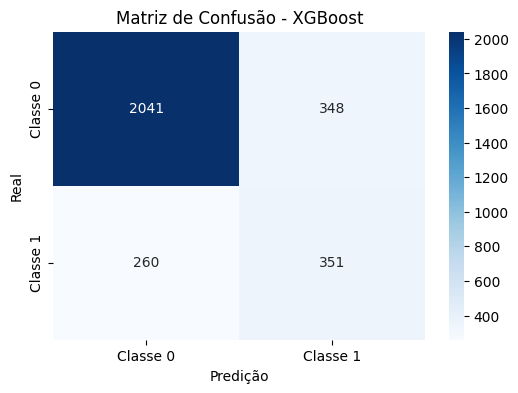


Relatório para XGBoost | Balanc: SMOTE | PCA: Sim | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.89      0.85      0.87      2389
    Classe 1       0.50      0.57      0.54       611

    accuracy                           0.80      3000
   macro avg       0.69      0.71      0.70      3000
weighted avg       0.81      0.80      0.80      3000

Tempo: 0.5632s

==================== AdaBoost ====================
⚠️ Aviso: Sem parâmetros definidos para AdaBoost. Usando default.


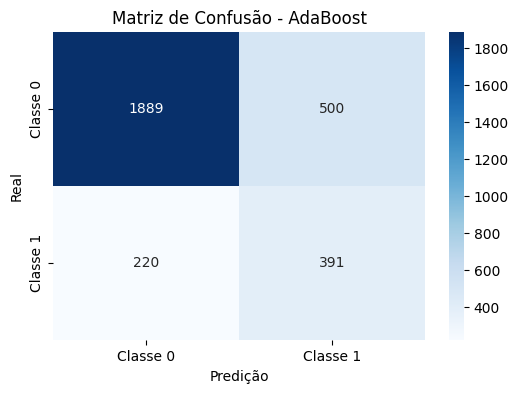


Relatório para AdaBoost | Balanc: SMOTE | PCA: Sim | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.90      0.79      0.84      2389
    Classe 1       0.44      0.64      0.52       611

    accuracy                           0.76      3000
   macro avg       0.67      0.72      0.68      3000
weighted avg       0.80      0.76      0.77      3000

Tempo: 1.8081s

🏆 Tabela de Resultados Final:


Modelo                                       Configuração  \
0  LogisticRegression  LogisticRegression | Balanc: SMOTE | PCA: Sim ...   
3                 KNN      KNN | Balanc: SMOTE | PCA: Sim | Params: best   
7            AdaBoost  AdaBoost | Balanc: SMOTE | PCA: Sim | Params: ...   
5       NeuralNetwork  NeuralNetwork | Balanc: SMOTE | PCA: Sim | Par...   
2                 SVM      SVM | Balanc: SMOTE | PCA: Sim | Params: best   
6             XGBoost  XGBoost | Balanc: SMOTE | PCA: Sim | Params: best   
1        RandomForest  RandomForest | Balanc: SMOTE | PCA: Sim | Para...   
4        DecisionTree  DecisionTree | Balanc: SMOTE | PCA: Sim | Para...   

   Score Otimização (recall_1)  Recall (Classe 1)  Acurácia  Tempo (s)  \
0                     0.649755           0.649755  0.722667   0.030322   
3                     0.648118           0.648118  0.733000   0.036767   
7                     0.639935           0.639935  0.760000   1.808083   
5                     0.633388           0.633388  0.782000   8.601071   
2                     0.612111           0.612111  0.799000   4.092432   
6                     0.574468           0.574468  0.797333   0.563246   
1                     0.536825           0.536825  0.819667   6.258106   
4                     0.525368           0.525368  0.746667   0.379792   

  Melhores Parâmetros  
0                 N/A  
3                 N/A  
7                 N/A  
5                 N/A  
2                 N/A  
6                 N/A  
1                 N/A  
4                 N/A


💾 Melhor modelo salvo: LogisticRegression (Score: 0.6498)

>>> 🧪 Testando Cenário: Best + PCA + Tomek
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
⚠️ Aviso: Sem parâmetros definidos para LogisticRegression. Usando default.
✨ Novo Recorde! LogisticRegression com recall_1: 0.2700


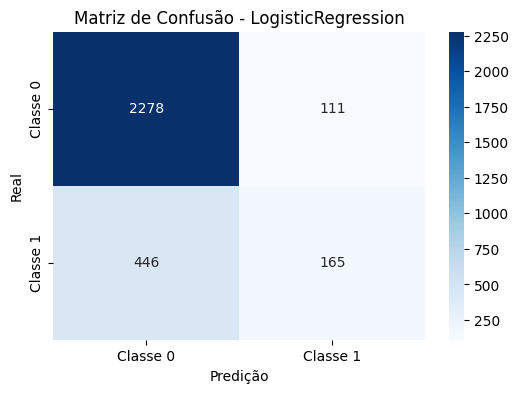


Relatório para LogisticRegression | Balanc: TomekLinks | PCA: Sim | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.84      0.95      0.89      2389
    Classe 1       0.60      0.27      0.37       611

    accuracy                           0.81      3000
   macro avg       0.72      0.61      0.63      3000
weighted avg       0.79      0.81      0.79      3000

Tempo: 0.0303s

==================== RandomForest ====================
⚠️ Aviso: Sem parâmetros definidos para RandomForest. Usando default.
✨ Novo Recorde! RandomForest com recall_1: 0.4124


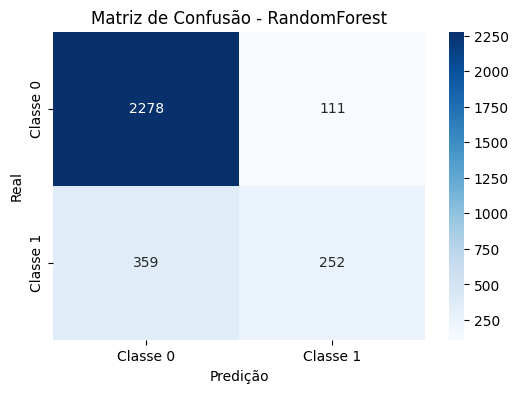


Relatório para RandomForest | Balanc: TomekLinks | PCA: Sim | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.86      0.95      0.91      2389
    Classe 1       0.69      0.41      0.52       611

    accuracy                           0.84      3000
   macro avg       0.78      0.68      0.71      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 4.5270s

==================== SVM ====================
⚠️ Aviso: Sem parâmetros definidos para SVM. Usando default.


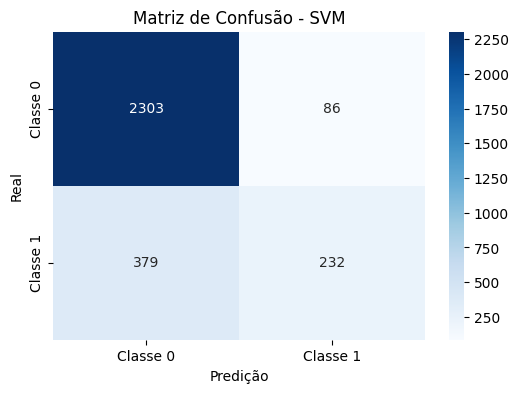


Relatório para SVM | Balanc: TomekLinks | PCA: Sim | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.86      0.96      0.91      2389
    Classe 1       0.73      0.38      0.50       611

    accuracy                           0.84      3000
   macro avg       0.79      0.67      0.70      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 1.1647s

==================== KNN ====================
⚠️ Aviso: Sem parâmetros definidos para KNN. Usando default.


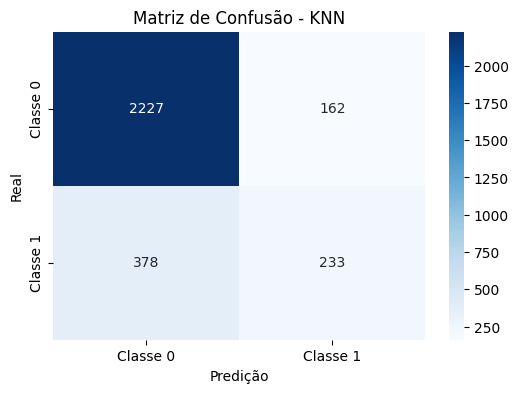


Relatório para KNN | Balanc: TomekLinks | PCA: Sim | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.85      0.93      0.89      2389
    Classe 1       0.59      0.38      0.46       611

    accuracy                           0.82      3000
   macro avg       0.72      0.66      0.68      3000
weighted avg       0.80      0.82      0.80      3000

Tempo: 0.0196s

==================== DecisionTree ====================
⚠️ Aviso: Sem parâmetros definidos para DecisionTree. Usando default.
✨ Novo Recorde! DecisionTree com recall_1: 0.5025


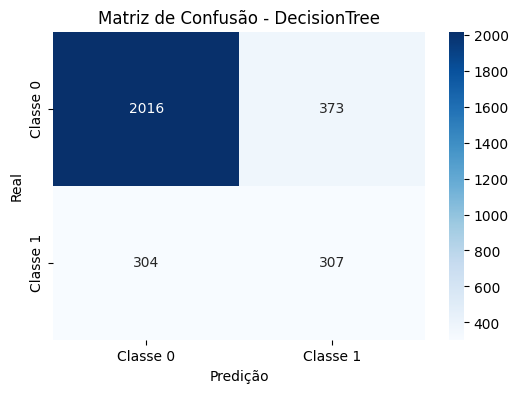


Relatório para DecisionTree | Balanc: TomekLinks | PCA: Sim | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.87      0.84      0.86      2389
    Classe 1       0.45      0.50      0.48       611

    accuracy                           0.77      3000
   macro avg       0.66      0.67      0.67      3000
weighted avg       0.78      0.77      0.78      3000

Tempo: 0.2683s

==================== NeuralNetwork ====================
⚠️ Aviso: Sem parâmetros definidos para NeuralNetwork. Usando default.


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


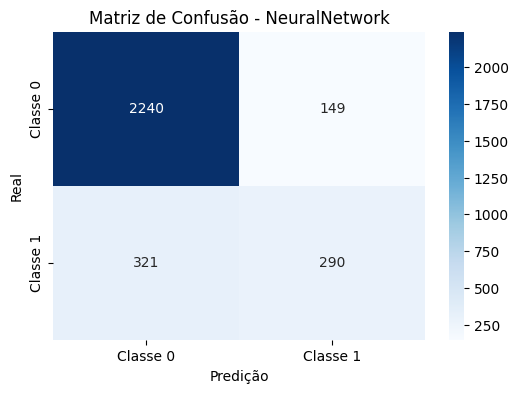


Relatório para NeuralNetwork | Balanc: TomekLinks | PCA: Sim | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.91      2389
    Classe 1       0.66      0.47      0.55       611

    accuracy                           0.84      3000
   macro avg       0.77      0.71      0.73      3000
weighted avg       0.83      0.84      0.83      3000

Tempo: 4.6303s

==================== XGBoost ====================
⚠️ Aviso: Sem parâmetros definidos para XGBoost. Usando default.


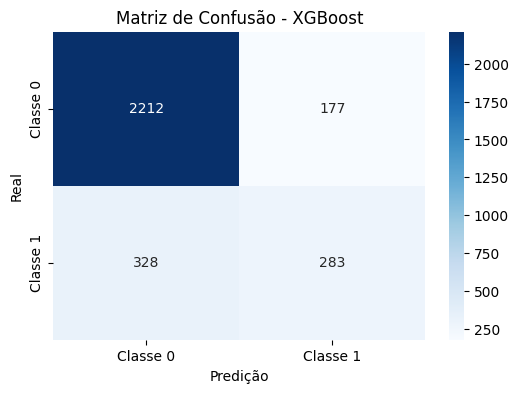


Relatório para XGBoost | Balanc: TomekLinks | PCA: Sim | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.87      0.93      0.90      2389
    Classe 1       0.62      0.46      0.53       611

    accuracy                           0.83      3000
   macro avg       0.74      0.69      0.71      3000
weighted avg       0.82      0.83      0.82      3000

Tempo: 0.5278s

==================== AdaBoost ====================
⚠️ Aviso: Sem parâmetros definidos para AdaBoost. Usando default.


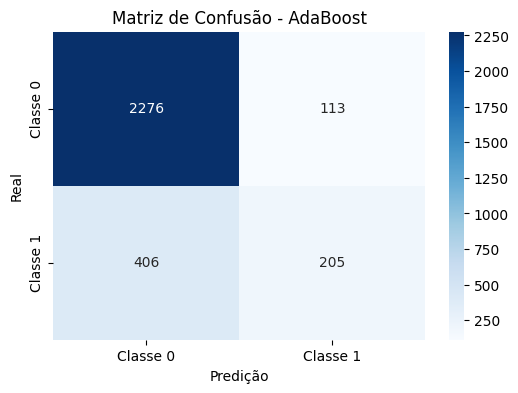


Relatório para AdaBoost | Balanc: TomekLinks | PCA: Sim | Params: best:
              precision    recall  f1-score   support

    Classe 0       0.85      0.95      0.90      2389
    Classe 1       0.64      0.34      0.44       611

    accuracy                           0.83      3000
   macro avg       0.75      0.64      0.67      3000
weighted avg       0.81      0.83      0.80      3000

Tempo: 1.1090s

🏆 Tabela de Resultados Final:


Modelo                                       Configuração  \
4        DecisionTree  DecisionTree | Balanc: TomekLinks | PCA: Sim |...   
5       NeuralNetwork  NeuralNetwork | Balanc: TomekLinks | PCA: Sim ...   
6             XGBoost  XGBoost | Balanc: TomekLinks | PCA: Sim | Para...   
1        RandomForest  RandomForest | Balanc: TomekLinks | PCA: Sim |...   
3                 KNN  KNN | Balanc: TomekLinks | PCA: Sim | Params: ...   
2                 SVM  SVM | Balanc: TomekLinks | PCA: Sim | Params: ...   
7            AdaBoost  AdaBoost | Balanc: TomekLinks | PCA: Sim | Par...   
0  LogisticRegression  LogisticRegression | Balanc: TomekLinks | PCA:...   

   Score Otimização (recall_1)  Recall (Classe 1)  Acurácia  Tempo (s)  \
4                     0.502455           0.502455  0.774333   0.268267   
5                     0.474632           0.474632  0.843333   4.630345   
6                     0.463175           0.463175  0.831667   0.527845   
1                     0.412439           0.412439  0.843333   4.527044   
3                     0.381342           0.381342  0.820000   0.019599   
2                     0.379705           0.379705  0.845000   1.164679   
7                     0.335516           0.335516  0.827000   1.108961   
0                     0.270049           0.270049  0.814333   0.030348   

  Melhores Parâmetros  
4                 N/A  
5                 N/A  
6                 N/A  
1                 N/A  
3                 N/A  
2                 N/A  
7                 N/A  
0                 N/A


💾 Melhor modelo salvo: DecisionTree (Score: 0.5025)

🏁 Todos os cenários finalizados!


In [ ]:
# Lista para armazenar o "Campeão" de cada cenário
resultados_scenarios = []

# Definição dos parâmetros para cada cenário
# Nota: 'balanceamento' deve corresponder exatamente ao if da classe ("SMOTE", "TomekLinks")
configs = [
    # --- DEFAULT (5) ---
    {"name": "Default",                     "bal": None,           "pca": False, "tipo": "default"},
    {"name": "Default + SMOTE",             "bal": "SMOTE",        "pca": False, "tipo": "default"},
    {"name": "Default + Tomek",             "bal": "TomekLinks",   "pca": False, "tipo": "default"},
    {"name": "Default + PCA + SMOTE",       "bal": "SMOTE",        "pca": True,  "tipo": "default"},
    {"name": "Default + PCA + Tomek",       "bal": "TomekLinks",   "pca": True,  "tipo": "default"},

    # --- GRID (5) ---
    {"name": "Grid",                        "bal": None,           "pca": False, "tipo": "grid"},
    {"name": "Grid + SMOTE",                "bal": "SMOTE",        "pca": False, "tipo": "grid"},
    {"name": "Grid + Tomek",                "bal": "TomekLinks",   "pca": False, "tipo": "grid"},
    {"name": "Grid + PCA + SMOTE",          "bal": "SMOTE",        "pca": True,  "tipo": "grid"},
    {"name": "Grid + PCA + Tomek",          "bal": "TomekLinks",   "pca": True,  "tipo": "grid"},

    # --- BEST PARAMS (5) ---
    {"name": "Best",                        "bal": None,           "pca": False, "tipo": "best"},
    {"name": "Best + SMOTE",                "bal": "SMOTE",        "pca": False, "tipo": "best"},
    {"name": "Best + Tomek",                "bal": "TomekLinks",   "pca": False, "tipo": "best"},
    {"name": "Best + PCA + SMOTE",          "bal": "SMOTE",        "pca": True,  "tipo": "best"},
    {"name": "Best + PCA + Tomek",          "bal": "TomekLinks",   "pca": True,  "tipo": "best"},
]


print(f"🚀 Iniciando bateria de testes com {len(configs)} cenários...\n")

# Loop de Execução
for config in configs:
    cenario_nome = config["name"]
    print(f"\n>>> 🧪 Testando Cenário: {cenario_nome}")

    # Chama o método train da classe
    # AQUI você escolhe a métrica global (ex: 'recall', 'accuracy', 'f1')
    melhor_pipeline_cenario = trainer.train(
        metric_optimize='recall_1',
        balanceamento=config["bal"],
        usar_pca=config["pca"],
        tipo_parametros=config["tipo"],
        salvar_parametros=True # Salva se encontrar algo bom
    )

    # Recupera as informações do vencedor deste cenário específico
    info_vencedor = trainer.best_model_info

    # Guarda o resultado para comparação final entre cenários
    resultados_scenarios.append({
        "Cenario": cenario_nome,
        "Melhor Modelo": info_vencedor['name'],
        "Score (Recall)": info_vencedor['score'],
        "Pipeline": melhor_pipeline_cenario
    })

print("\n🏁 Todos os cenários finalizados!")